This notebook is for creating graphs of the benchmark case study, specifically using datasets where all the data is available.

Currently this notebook resides in the `notebooks` folder, but in order for it to run, it must be moved out to the main folder. 

# Set up 

In [38]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm

import cobra
import os
os.getcwd()

from scipy import stats
import scipy as sp

from src import BMCA, util
import emll


# Perturbing boundary metabolites, specifically EtOH

First, we use data where [EtOH] is perturbed

In [39]:
# elasticity_to_CCC(BIOMD64, r.getScaledElasticityMatrix())
Teusink_ant ='data/interim/Antimony/BIOMD0000000064_e.ant' 
data_file = 'data/interim/generated_data/EtOHcompilation.csv'
data = pd.read_csv(data_file)

r = te.loada(Teusink_ant)

r.conservedMoietyAnalysis = True
r.steadyState()
scaledE = r.getScaledElasticityMatrix()

In [40]:
BIOMD64 = BMCA.BMCA(Teusink_ant, data_file)

Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

## Running ADVI

In [41]:
import numpy as np
import pymc as pm
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BIOMD64.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BIOMD64.Ey.to_numpy(), name='Ey'))

    trace_prior = pm.sample_prior_predictive(samples=1000)

Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]


In [42]:
with pymc_model:
    
    # e_obs = pm.Normal('e_obs', mu=BIOMD64.en.T, sigma=0.1)
    chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BIOMD64.xn.T)
    y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BIOMD64.yn.T)

    likelihood = pm.Deterministic('vn', (np.ones((17,30)) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
    v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BIOMD64.vn.squeeze().T)

pymc_model.free_RVs

[Ex_kinetic_entries ~ SkewNormal(0, 1, 5),
 Ex_capacity_entries ~ Laplace(0, 0.01),
 Ey_kinetic_entries ~ SkewNormal(0, 1, 5),
 Ey_capacity_entries ~ Laplace(0, 0.01)]

In [43]:
N_ITERATIONS = 50000
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = advi.fit(
        n=       N_ITERATIONS, 
        callbacks = [tracker],
        obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
        total_grad_norm_constraint=0.7,
        obj_n_mc=1)
    
    trace_vi = approx.sample(draws=1000, random_seed=1) 
    ppc_vi = pm.sample_posterior_predictive(trace_vi, random_seed=1)
    

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,679.1
Sampling: [chi_obs, v_hat_obs, y_obs]


### Plotting ADVI results

In [44]:
Ex_trace = (trace_vi['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)

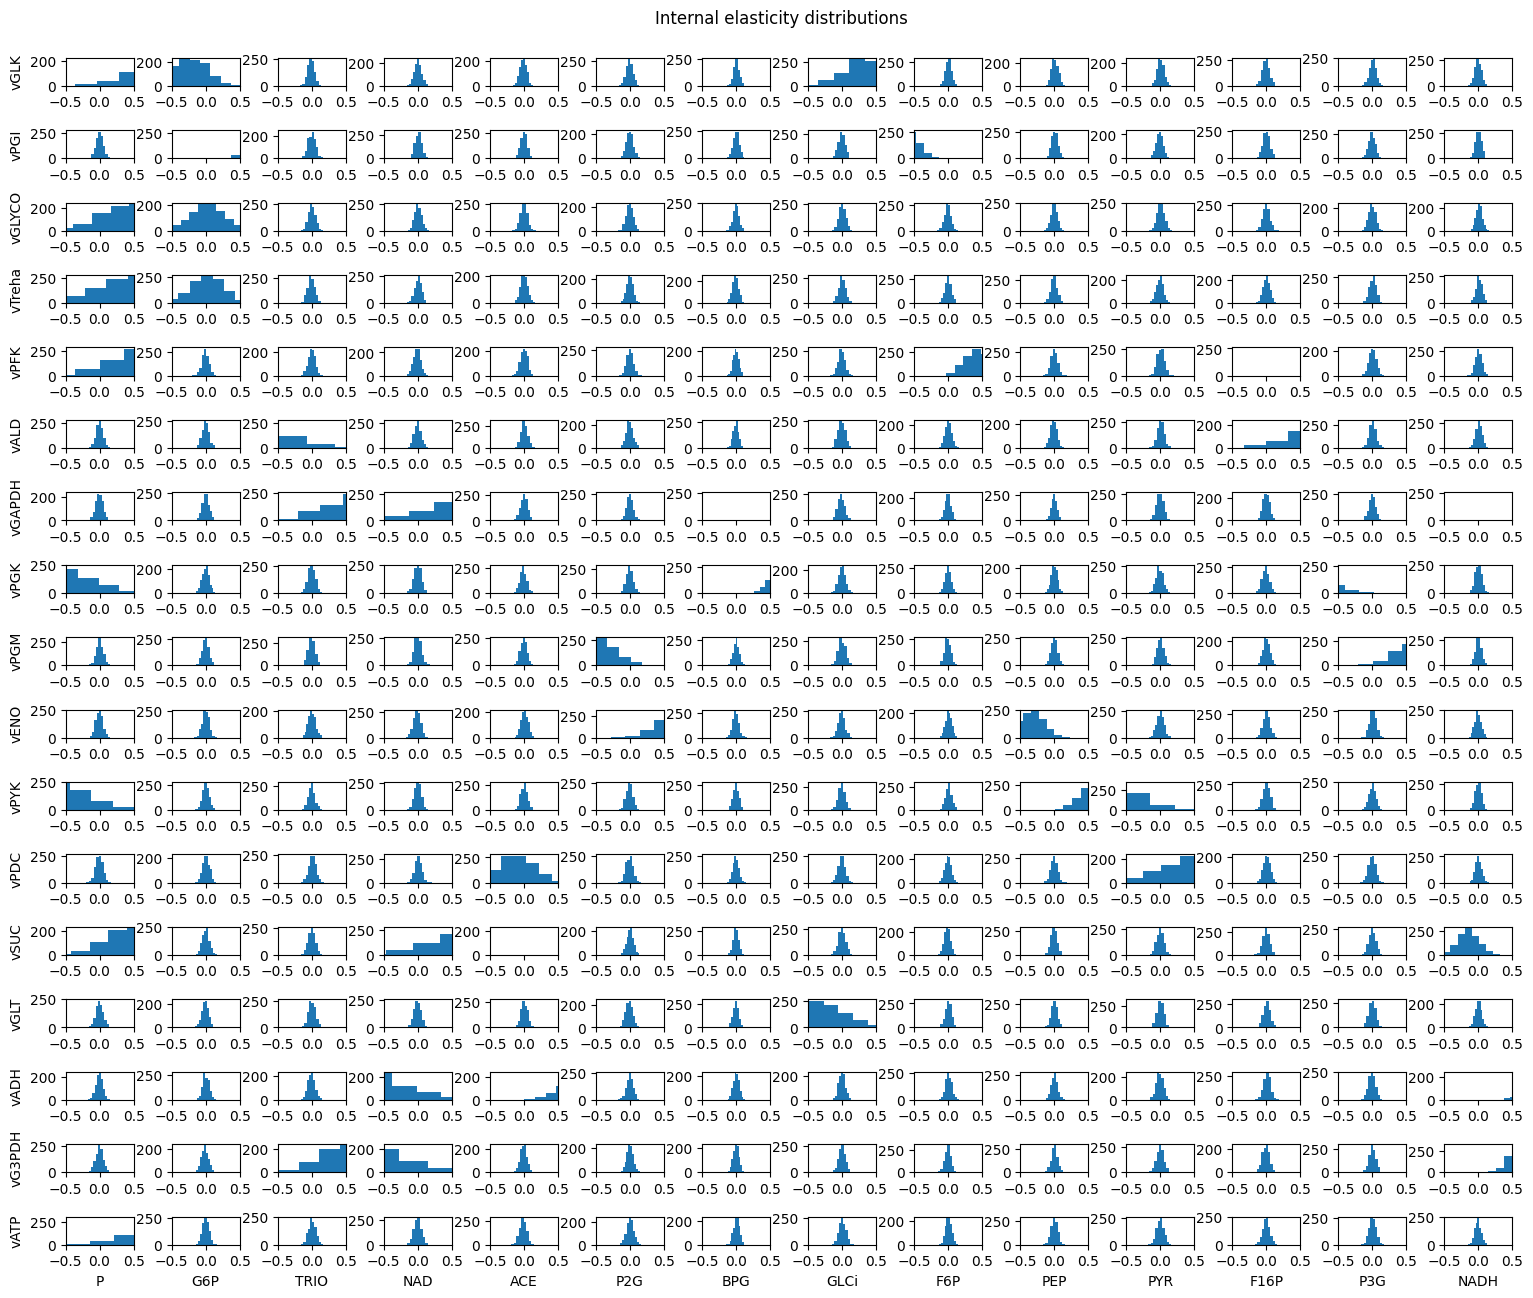

In [45]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,14, figsize=(15, 13)) 

fig.suptitle('Internal elasticity distributions\n')
fig.tight_layout()

for i in range(17):
  for ii in range(14):
    axs[i,ii].hist(Ex_trace[i,ii,:])
    axs[i,ii].set_xlim([-0.5,0.5])

    if ii == 0:
      axs[i,ii].set_ylabel(r.getReactionIds()[i])
    if i == 16: 
      axs[i,ii].set_xlabel(r.getFloatingSpeciesIds()[ii])

all distributions are unimodal so we estimate that the peak of the distribution is the median

In [46]:
Ex_peaks=[]

for i in range(Ex_trace.shape[0]):
    for ii in range(Ex_trace.shape[1]):
        Ex_peaks.append(np.percentile(Ex_trace[i,ii,:],50))


In [47]:
# these are the elasticity posteriors from Bayesian inference
x = np.array(Ex_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
x[abs(x) < 0.01] = 0

x = x.reshape((17,14))
Ex = pd.DataFrame(x, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds())
Ex

P       G6P      TRIO       NAD       ACE       P2G       BPG  \
vGLK    1.138390 -0.223774 -0.011839  0.000000 -0.010611  0.000000  0.000000   
vPGI    0.000000  1.007274  0.000000  0.000000  0.000000  0.000000  0.000000   
vGLYCO  0.488496  0.028217  0.000000  0.000000  0.000000  0.000000  0.000000   
vTreha  0.452768  0.040951  0.000000  0.000000  0.000000  0.000000  0.000000   
vPFK    0.708359  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
vALD    0.000000  0.000000 -0.984215  0.000000  0.000000  0.000000  0.000000   
vGAPDH  0.000000  0.000000  0.802614  0.883548  0.000000  0.000000 -0.958903   
vPGK   -0.672817  0.000000  0.000000  0.000000  0.000000  0.000000  0.619972   
vPGM    0.000000  0.000000  0.000000  0.000000  0.000000 -0.476228  0.000000   
vENO    0.000000  0.000000  0.000000  0.000000  0.000000  0.706818  0.000000   
vPYK   -0.718336  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
vPDC    0.000000  0.000000  0.010941  0.000000 -0.100757  0.000000  0.000000   
vSUC    0.572012  0.000000  0.000000  0.835499  1.344041  0.000000  0.000000   
vGLT    0.000000  0.000000  0.000000  0.000000  0.000000 -0.011796  0.000000   
vADH    0.000000  0.000000  0.000000 -0.817543  0.831859  0.000000  0.000000   
vG3PDH  0.000000 -0.011118  0.661516 -0.965186  0.000000  0.000000  0.000000   
vATP    1.048390  0.000000  0.000000  0.000000  0.000000  0.000000  0.010742   

            GLCi       F6P       PEP       PYR      F16P       P3G      NADH  
vGLK    0.343473  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
vPGI    0.000000 -0.602638  0.000000  0.000000  0.000000  0.000000  0.000000  
vGLYCO  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
vTreha  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.011341  
vPFK    0.000000  0.427014  0.000000  0.000000 -2.238309  0.000000  0.000000  
vALD    0.000000  0.000000  0.000000  0.000000  1.029229  0.000000  0.000000  
vGAPDH -0.010332  0.000000  0.000000  0.000000  0.000000  0.000000 -1.105617  
vPGK    0.000000  0.000000  0.000000 -0.011663  0.000000 -1.013780  0.000000  
vPGM    0.000000  0.000000  0.000000  0.000000  0.000000  0.715167  0.000000  
vENO    0.000000  0.000000 -0.334188  0.000000  0.000000  0.000000  0.000000  
vPYK    0.000000  0.000000  0.557758 -0.730031  0.000000  0.000000  0.000000  
vPDC    0.000000  0.000000  0.000000  0.531134  0.000000  0.000000  0.000000  
vSUC    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000 -0.150850  
vGLT   -0.316629  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
vADH    0.000000  0.000000  0.000000  0.000000  0.013106  0.000000  0.809378  
vG3PDH  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.579916  
vATP    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000

In [48]:
Ey_trace = (trace_vi['posterior']['Ey']).to_numpy().squeeze().transpose(1, 2, 0)
Ey_trace.shape

(17, 5, 1000)

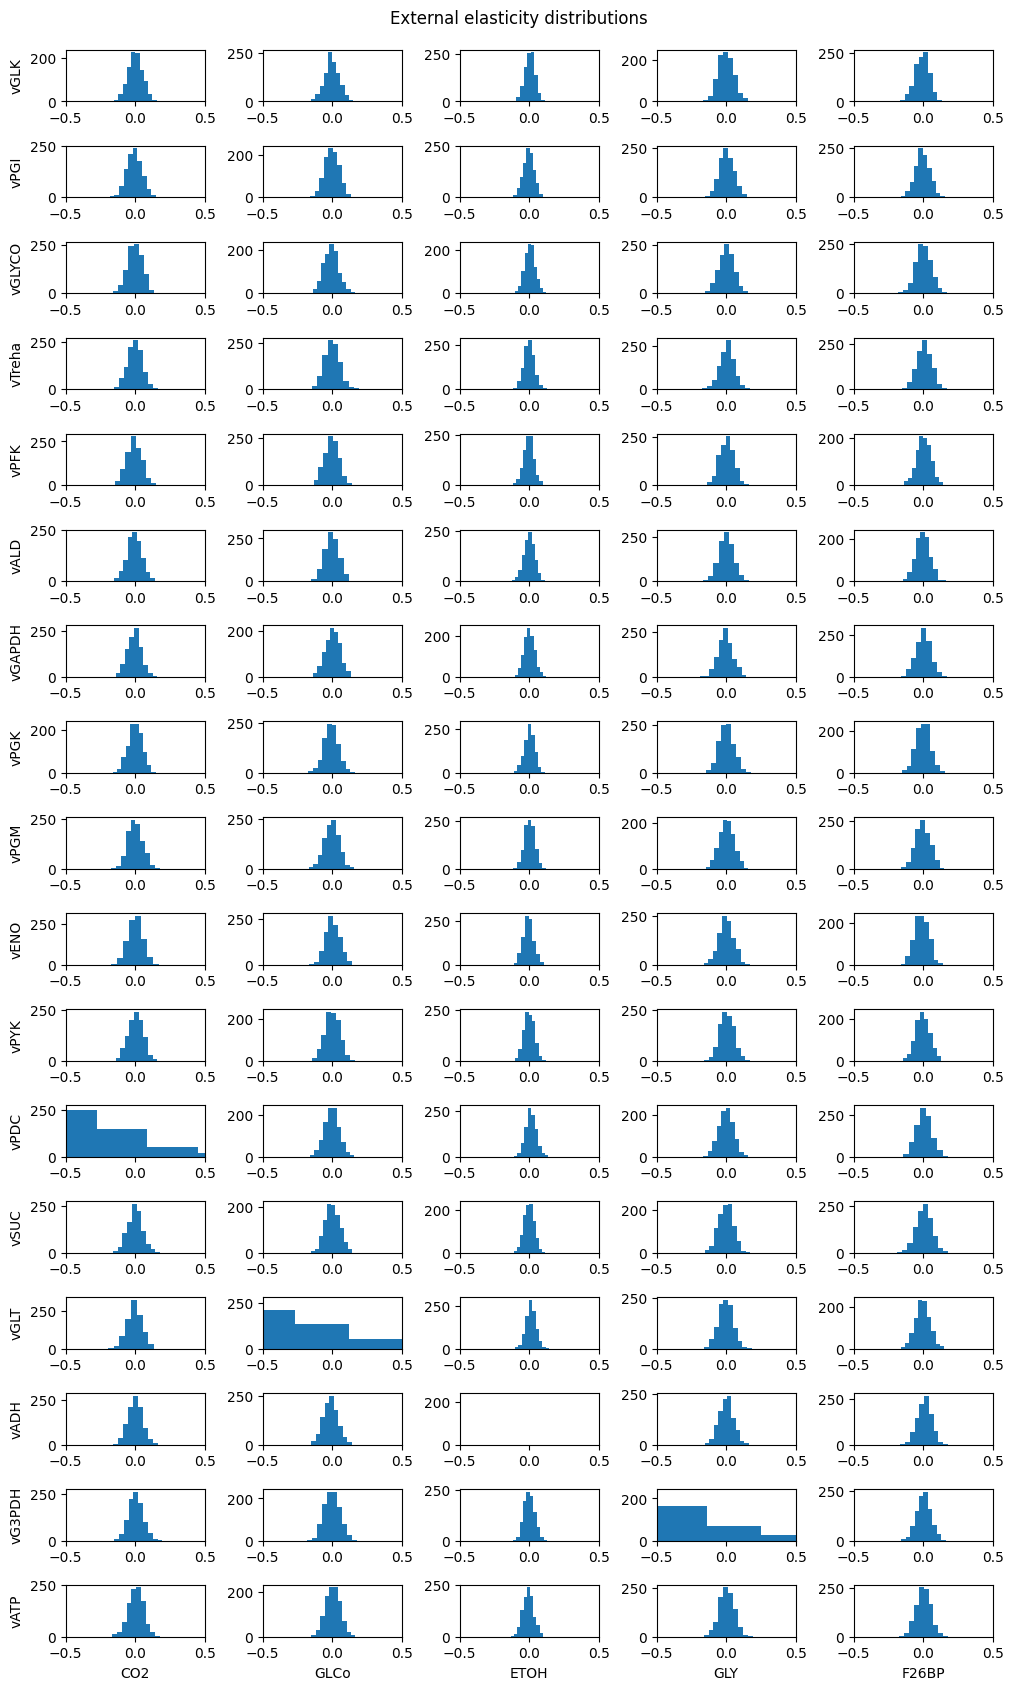

In [49]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,5, figsize=(10, 17)) 

fig.suptitle('External elasticity distributions\n')
fig.tight_layout()

for i in range(17):
  for ii in range(5):
    axs[i,ii].hist(Ey_trace[i,ii,:])
    axs[i,ii].set_xlim([-0.5,0.5])

    if ii == 0:
      axs[i,ii].set_ylabel(r.getReactionIds()[i])
    if i == 16: 
      axs[i,ii].set_xlabel(r.getBoundarySpeciesIds()[ii])

In [50]:
Ey_peaks=[]

for i in range(Ey_trace.shape[0]):
    for ii in range(Ey_trace.shape[1]):
        Ey_peaks.append(np.percentile(Ey_trace[i,ii,:],50))


In [51]:
# elasticities from Bayesian inf posteriors

y = np.array(Ey_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
y[abs(y) < 0.01] = 0

y = y.reshape((17,5))
Ey = pd.DataFrame(y, index=r.getReactionIds(), columns=r.getBoundarySpeciesIds())
Ey

CO2      GLCo      ETOH       GLY     F26BP
vGLK    0.000000  0.000000  0.000000  0.000000  0.000000
vPGI    0.000000  0.000000  0.000000  0.000000  0.000000
vGLYCO  0.000000  0.000000  0.000000  0.000000  0.000000
vTreha  0.000000  0.000000  0.000000  0.000000  0.000000
vPFK    0.000000  0.000000  0.000000  0.000000  0.000000
vALD    0.000000  0.000000  0.000000  0.000000  0.000000
vGAPDH  0.000000  0.000000  0.000000  0.000000  0.000000
vPGK    0.000000  0.000000  0.000000  0.000000  0.000000
vPGM    0.000000  0.000000  0.000000  0.000000  0.000000
vENO    0.000000  0.000000  0.000000  0.000000 -0.012956
vPYK    0.000000  0.000000  0.000000  0.000000  0.000000
vPDC   -0.667866  0.000000  0.012177  0.000000  0.000000
vSUC    0.000000  0.000000  0.000000  0.000000  0.000000
vGLT    0.000000 -0.759302  0.012689  0.000000  0.000000
vADH    0.000000 -0.011337 -0.791373  0.000000  0.011387
vG3PDH  0.000000  0.000000  0.000000 -0.903791  0.000000
vATP    0.000000  0.000000  0.000000  0.000000  0.000000

In [52]:
a = data['ETOH']/50
a.drop(a.index[0],inplace=True)

In [53]:
# get the real values
real_values = data[[i for i in data.columns if 'v_' in i]]
rel_real_values = real_values.div(real_values.iloc[0])
rel_real_values.drop(rel_real_values.index[0], inplace=True)
rel_real_values.columns = r.getReactionIds()
rel_real_values = rel_real_values.transpose()
rel_real_values.columns = a.round(2).values
rel_real_values


0.28      0.48      0.63      0.73      0.81      0.86      0.90  \
vGLK    1.013158  1.009094  1.006402  1.004547  1.003245  1.002322  1.001665   
vPGI    1.014996  1.010364  1.007296  1.005182  1.003698  1.002646  1.001897   
vGLYCO  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vTreha  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vPFK    1.014996  1.010364  1.007296  1.005182  1.003698  1.002646  1.001897   
vALD    1.014996  1.010364  1.007296  1.005182  1.003698  1.002646  1.001897   
vGAPDH  1.060226  1.039023  1.026441  1.018319  1.012855  1.009095  1.006468   
vPGK    1.060226  1.039023  1.026441  1.018319  1.012855  1.009095  1.006468   
vPGM    1.060226  1.039023  1.026441  1.018319  1.012855  1.009095  1.006468   
vENO    1.060226  1.039023  1.026441  1.018319  1.012855  1.009095  1.006468   
vPYK    1.060226  1.039023  1.026441  1.018319  1.012855  1.009095  1.006468   
vPDC    1.060226  1.039023  1.026441  1.018319  1.012855  1.009095  1.006468   
vSUC    0.675820  0.795449  0.863731  0.906671  0.935025  0.954292  0.967623   
vGLT    1.013158  1.009094  1.006402  1.004547  1.003245  1.002322  1.001665   
vADH    1.081886  1.052748  1.035609  1.024609  1.017241  1.012183  1.008657   
vG3PDH  0.675820  0.795449  0.863731  0.906671  0.935025  0.954292  0.967623   
vATP    1.222897  1.142294  1.095512  1.065753  1.045942  1.032401  1.022993   

            0.93      0.95      0.96      0.97      0.98      0.99      0.99  \
vGLK    1.001195  1.000858  1.000617  1.000444  1.000319  1.000230  1.000165   
vPGI    1.001362  1.000978  1.000703  1.000506  1.000364  1.000262  1.000188   
vGLYCO  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vTreha  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vPFK    1.001362  1.000978  1.000703  1.000506  1.000364  1.000262  1.000188   
vALD    1.001362  1.000978  1.000703  1.000506  1.000364  1.000262  1.000188   
vGAPDH  1.004616  1.003303  1.002367  1.001698  1.001220  1.000877  1.000630   
vPGK    1.004616  1.003303  1.002367  1.001698  1.001220  1.000877  1.000630   
vPGM    1.004616  1.003303  1.002367  1.001698  1.001220  1.000877  1.000630   
vENO    1.004616  1.003303  1.002367  1.001698  1.001220  1.000877  1.000630   
vPYK    1.004616  1.003303  1.002367  1.001698  1.001220  1.000877  1.000630   
vPDC    1.004616  1.003303  1.002367  1.001698  1.001220  1.000877  1.000630   
vSUC    0.976957  0.983547  0.988226  0.991560  0.993944  0.995650  0.996874   
vGLT    1.001195  1.000858  1.000617  1.000444  1.000319  1.000230  1.000165   
vADH    1.006175  1.004416  1.003164  1.002270  1.001630  1.001171  1.000842   
vG3PDH  0.976957  0.983547  0.988226  0.991560  0.993944  0.995650  0.996874   
vATP    1.016385  1.011710  1.008386  1.006014  1.004317  1.003101  1.002229   

        1.00      1.01      1.01      1.02      1.03      1.04      1.05  \
vGLK     1.0  0.999835  0.999771  0.999682  0.999558  0.999387  0.999149   
vPGI     1.0  0.999812  0.999739  0.999638  0.999497  0.999301  0.999030   
vGLYCO   1.0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vTreha   1.0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vPFK     1.0  0.999812  0.999739  0.999638  0.999497  0.999301  0.999030   
vALD     1.0  0.999812  0.999739  0.999638  0.999497  0.999301  0.999030   
vGAPDH   1.0  0.999373  0.999130  0.998793  0.998327  0.997682  0.996791   
vPGK     1.0  0.999373  0.999130  0.998793  0.998327  0.997682  0.996791   
vPGM     1.0  0.999373  0.999130  0.998793  0.998327  0.997682  0.996791   
vENO     1.0  0.999373  0.999130  0.998793  0.998327  0.997682  0.996791   
vPYK     1.0  0.999373  0.999130  0.998793  0.998327  0.997682  0.996791   
vPDC     1.0  0.999373  0.999130  0.998793  0.998327  0.997682  0.996791   
vSUC     1.0  1.003102  1.004304  1.005969  1.008270  1.011447  1.015821   
vGLT     1.0  0.999835  0.999771  0.999682  0.999558  0.999387  0.

In [54]:
# c_df is the flux calculated using the Bayesian inference PRIORS for elasticity
c = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + BIOMD64.Ex@(BIOMD64.xn).T + BIOMD64.Ey@(BIOMD64.yn).T)
c_df = pd.DataFrame(c) #, index=r.getReactionIds(), columns=a.round(2).values) 
c_df.index = r.getReactionIds()
c_df.columns = a.round(2).values
c_df = c_df.divide(c_df[1.00], axis=0)
c_df

0.28      0.48      0.63      0.73      0.81      0.86      0.90  \
vGLK    0.527154  0.712401  0.811909  0.872518  0.911809  0.938208  0.956345   
vPGI    0.822680  0.884880  0.922265  0.946359  0.962485  0.973531  0.981214   
vGLYCO  1.495558  1.301111  1.196813  1.133338  1.092214  1.064595  1.045627   
vTreha  1.495558  1.301111  1.196813  1.133338  1.092214  1.064595  1.045627   
vPFK    1.521604  1.331045  1.220366  1.150743  1.104846  1.073706  1.052185   
vALD    1.064559  1.036710  1.023502  1.015788  1.010875  1.007602  1.005364   
vGAPDH  0.947589  0.985627  0.996173  0.999595  1.000673  1.000910  1.000853   
vPGK    1.354944  1.203564  1.128954  1.085674  1.058484  1.040606  1.028504   
vPGM    0.957849  0.976317  0.985127  0.990161  0.993299  0.995354  0.996741   
vENO    0.807727  0.887966  0.928470  0.952253  0.967305  0.977253  0.984009   
vPYK    1.288661  1.144905  1.085084  1.053831  1.035552  1.024124  1.016664   
vPDC    1.552077  1.329172  1.213197  1.143652  1.098992  1.069174  1.048779   
vSUC    1.369896  1.241549  1.164705  1.114608  1.080671  1.057189  1.040731   
vGLT    1.198236  1.133268  1.092189  1.064706  1.045802  1.032593  1.023274   
vADH    1.228765  1.103847  1.059188  1.037064  1.024395  1.016540  1.011427   
vG3PDH  0.435465  0.651468  0.769936  0.843145  0.891067  0.923478  0.945844   
vATP    1.110474  1.073390  1.050455  1.035281  1.024912  1.017698  1.012623   

            0.93      0.95      0.96      0.97      0.98      0.99      0.99  \
vGLK    0.968987  0.977883  0.984186  0.988671  0.991874  0.994165  0.995808   
vPGI    0.986612  0.990432  0.993149  0.995087  0.996473  0.997466  0.998179   
vGLYCO  1.032411  1.023111  1.016524  1.011837  1.008491  1.006096  1.004380   
vTreha  1.032411  1.023111  1.016524  1.011837  1.008491  1.006096  1.004380   
vPFK    1.037128  1.026503  1.018964  1.013592  1.009753  1.007004  1.005033   
vALD    1.003808  1.002714  1.001940  1.001389  1.000997  1.000715  1.000514   
vGAPDH  1.000711  1.000559  1.000424  1.000316  1.000234  1.000171  1.000125   
vPGK    1.020157  1.014329  1.010224  1.007313  1.005238  1.003759  1.002699   
vPGM    0.997696  0.998363  0.998832  0.999165  0.999402  0.999571  0.999692   
vENO    0.988679  0.991946  0.994252  0.995887  0.997052  0.997885  0.998481   
vPYK    1.011652  1.008216  1.005827  1.004150  1.002965  1.002122  1.001522   
vPDC    1.034608  1.024657  1.017619  1.012615  1.009046  1.006493  1.004664   
vSUC    1.029100  1.020835  1.014940  1.010724  1.007703  1.005537  1.003981   
vGLT    1.016659  1.011943  1.008572  1.006157  1.004425  1.003181  1.002288   
vADH    1.007993  1.005639  1.004001  1.002851  1.002037  1.001459  1.001046   
vG3PDH  0.961479  0.972506  0.980329  0.985902  0.989884  0.992736  0.994780   
vATP    1.009028  1.006469  1.004641  1.003332  1.002394  1.001721  1.001238   

        1.00      1.01      1.01      1.02      1.03      1.04      1.05  \
vGLK     1.0  1.004156  1.005765  1.007992  1.011070  1.015315  1.021152   
vPGI     1.0  1.001809  1.002510  1.003482  1.004826  1.006682  1.009240   
vGLYCO   1.0  0.995658  0.993977  0.991651  0.988436  0.984004  0.977908   
vTreha   1.0  0.995658  0.993977  0.991651  0.988436  0.984004  0.977908   
vPFK     1.0  0.995006  0.993071  0.990392  0.986688  0.981577  0.974541   
vALD     1.0  0.999491  0.999293  0.999021  0.998643  0.998124  0.997409   
vGAPDH   1.0  0.999867  0.999815  0.999736  0.999626  0.999468  0.999233   
vPGK     1.0  0.997333  0.996301  0.994879  0.992915  0.990212  0.986513   
vPGM     1.0  1.000304  1.000422  1.000584  1.000809  1.001117  1.001539   
vENO     1.0  1.001502  1.002083  1.002886  1.003993  1.005518  1.007607   
vPYK     1.0  0.998508  0.997935  0.997145  0.996062  0.994583  0.992576   
vPDC     1.0  0.995380  0.993592  0.991119  0.987703  0.982996  0.976531   
vSUC     1.0  0.996039  0.994501  0.992369  0.989416  0.985330  0.979686   
vGLT     1.0  0.997720  0.996835  0.995606  0.993903  0.991544  0.

Text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference')

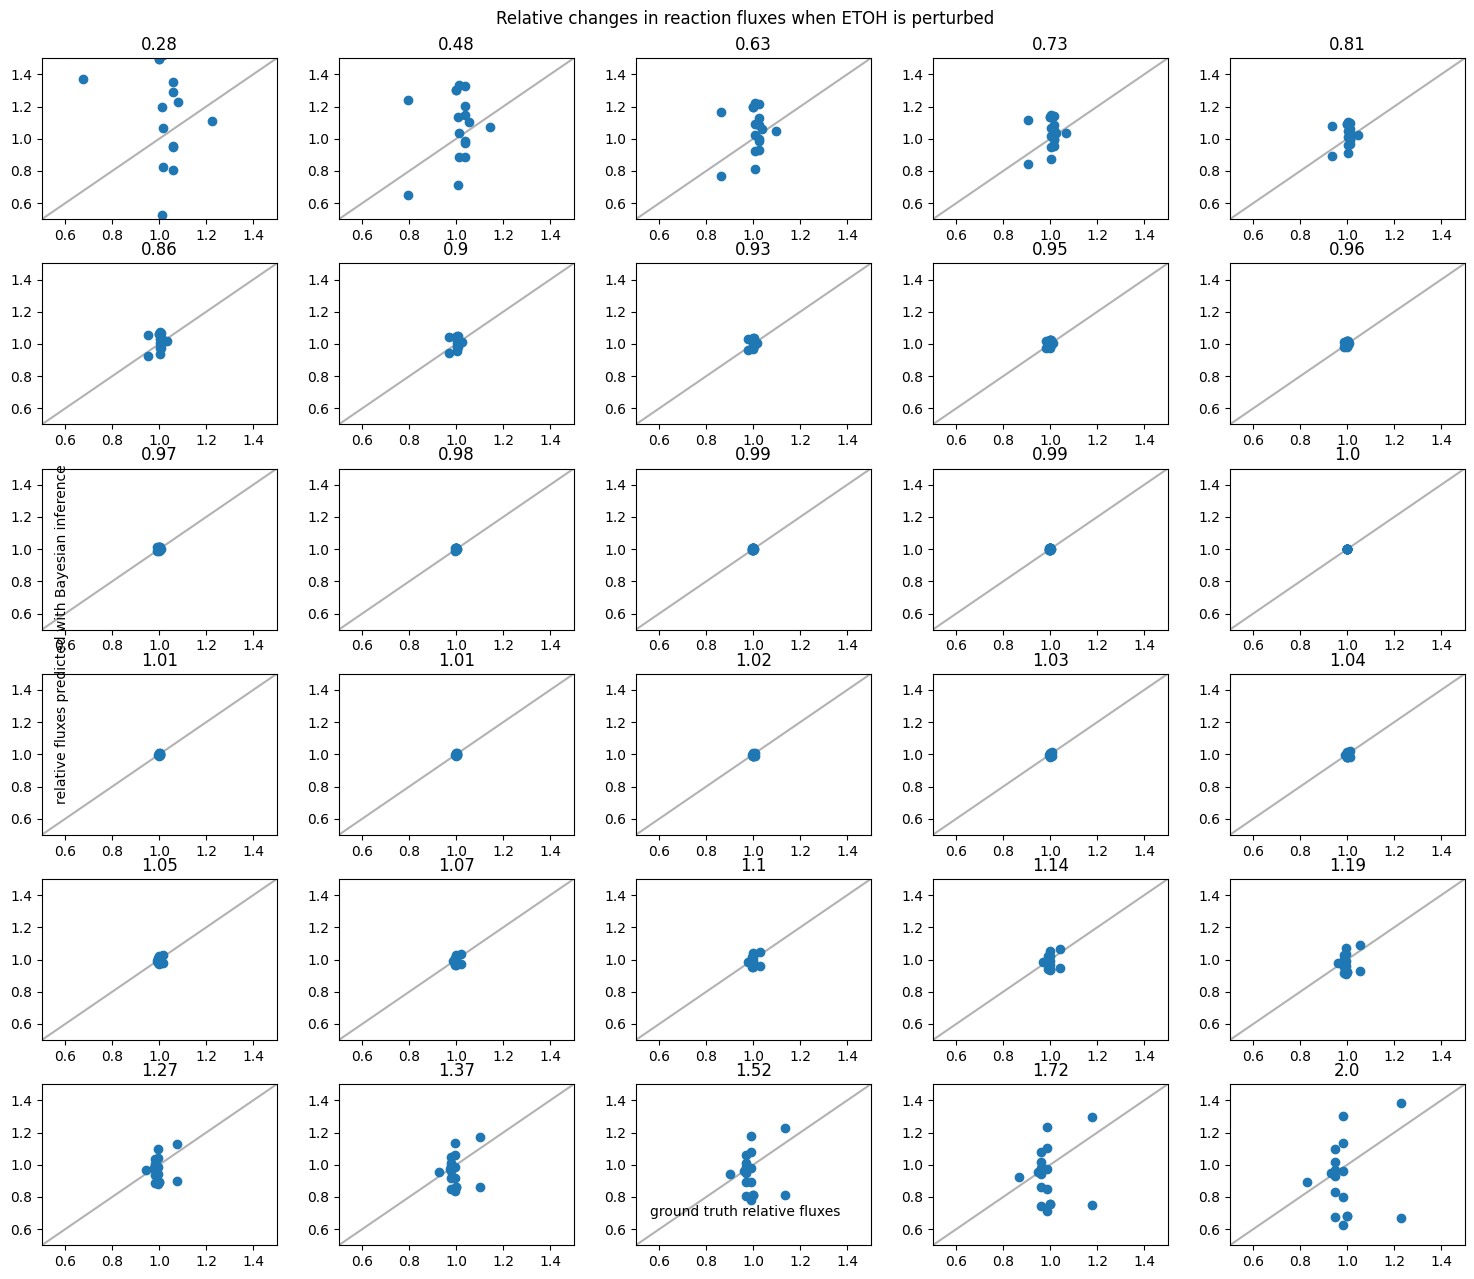

In [55]:
fig, axs = plt.subplots(6,5, figsize=(15, 13)) 
idx_starter = -1

fig.suptitle('Relative changes in reaction fluxes when ETOH is perturbed\n')
fig.tight_layout()

lims = [0.5,1.5]

for i,col in enumerate(c_df.columns): 
    if i%5==0:
      idx_starter += 1
    axs[idx_starter, i%5].plot(lims, lims, 'k-', alpha=0.3, zorder=0)
    axs[idx_starter, i%5].scatter(rel_real_values[col], c_df[col])
    axs[idx_starter, i%5].set_xlim(lims)
    axs[idx_starter, i%5].set_ylim(lims)
    #axs[idx_starter, i%5].set_xlabel('ground truth relative fluxes\n\n')
    #axs[idx_starter, i%5].set_ylabel('relative fluxes predicted with Bayesian inference')
    axs[idx_starter, i%5].set_title(col)

fig.text(0.5, 0.04, 'ground truth relative fluxes\n', ha='center')
fig.text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference', va='center', rotation='vertical')


#plt.legend(["fully parameterized", "Visser priors", "real values"])
#plt.show()

In [56]:
# d_df is the flux calculated using the Bayesian inference POSTERIORS for elasticity
d = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + x@(BIOMD64.xn).T + y@(BIOMD64.yn).T)
d_df = pd.DataFrame(d) #, index=r.getReactionIds(), columns=a.round(2).values) 
d_df.index = r.getReactionIds()
d_df.columns = a.round(2).values
d_df = d_df.divide(d_df[1.00], axis=0)
d_df

0.28      0.48      0.63      0.73      0.81      0.86      0.90  \
vGLK    0.974633  0.988669  0.994214  0.996794  0.998115  0.998839  0.999259   
vPGI    1.048959  1.022769  1.012375  1.007351  1.004624  1.003025  1.002033   
vGLYCO  1.064832  1.042276  1.028777  1.020001  1.014069  1.009969  1.007098   
vTreha  1.058556  1.038156  1.025954  1.018030  1.012678  1.008981  1.006394   
vPFK    0.979810  1.007713  1.010156  1.008661  1.006708  1.005014  1.003687   
vALD    1.070350  1.039965  1.025570  1.017170  1.011824  1.008264  1.005830   
vGAPDH  1.030795  1.036222  1.029313  1.022087  1.016248  1.011829  1.008570   
vPGK    1.084378  1.049128  1.030885  1.020316  1.013747  1.009479  1.006619   
vPGM    1.057572  1.032424  1.020596  1.013761  1.009444  1.006585  1.004637   
vENO    1.072541  1.039539  1.024803  1.016477  1.011275  1.007849  1.005523   
vPYK    1.115657  1.051754  1.027863  1.016490  1.010349  1.006756  1.004534   
vPDC    1.110055  1.067989  1.044845  1.030552  1.021206  1.014890  1.010535   
vSUC    0.644020  0.800586  0.875707  0.918360  0.944718  0.961840  0.973323   
vGLT    1.042298  1.030500  1.021729  1.015498  1.011077  1.007933  1.005688   
vADH    1.155322  1.066810  1.036872  1.022610  1.014672  1.009850  1.006759   
vG3PDH  0.670224  0.795760  0.864979  0.907862  0.935975  0.955007  0.968149   
vATP    1.124310  1.081881  1.056069  1.039117  1.027582  1.019576  1.013954   

            0.93      0.95      0.96      0.97      0.98      0.99      0.99  \
vGLK    0.999513  0.999673  0.999776  0.999845  0.999891  0.999923  0.999946   
vPGI    1.001394  1.000968  1.000680  1.000480  1.000341  1.000243  1.000174   
vGLYCO  1.005070  1.003630  1.002602  1.001868  1.001342  1.000964  1.000693   
vTreha  1.004567  1.003269  1.002344  1.001682  1.001208  1.000868  1.000624   
vPFK    1.002689  1.001952  1.001412  1.001020  1.000736  1.000531  1.000382   
vALD    1.004138  1.002949  1.002108  1.001510  1.001083  1.000777  1.000558   
vGAPDH  1.006195  1.004470  1.003221  1.002320  1.001672  1.001203  1.000866   
vPGK    1.004661  1.003304  1.002353  1.001681  1.001202  1.000862  1.000619   
vPGM    1.003288  1.002341  1.001672  1.001197  1.000858  1.000616  1.000443   
vENO    1.003913  1.002786  1.001989  1.001424  1.001021  1.000733  1.000526   
vPYK    1.003103  1.002154  1.001510  1.001067  1.000757  1.000540  1.000386   
vPDC    1.007492  1.005347  1.003825  1.002741  1.001967  1.001412  1.001015   
vSUC    0.981189  0.986656  0.990495  0.993210  0.995139  0.996515  0.997498   
vGLT    1.004083  1.002933  1.002108  1.001516  1.001090  1.000784  1.000564   
vADH    1.004705  1.003308  1.002341  1.001665  1.001188  1.000850  1.000609   
vG3PDH  0.977340  0.983825  0.988426  0.991705  0.994048  0.995725  0.996928   
vATP    1.009976  1.007145  1.005125  1.003680  1.002644  1.001900  1.001366   

        1.00      1.01      1.01      1.02      1.03      1.04      1.05  \
vGLK     1.0  1.000050  1.000069  1.000094  1.000126  1.000168  1.000219   
vPGI     1.0  0.999832  0.999768  0.999681  0.999562  0.999403  0.999191   
vGLYCO   1.0  0.999310  0.999042  0.998671  0.998157  0.997446  0.996463   
vTreha   1.0  0.999379  0.999138  0.998804  0.998341  0.997700  0.996816   
vPFK     1.0  0.999615  0.999465  0.999255  0.998963  0.998555  0.997985   
vALD     1.0  0.999447  0.999232  0.998936  0.998526  0.997962  0.997185   
vGAPDH   1.0  0.999132  0.998795  0.998322  0.997667  0.996757  0.995488   
vPGK     1.0  0.999391  0.999155  0.998832  0.998386  0.997773  0.996938   
vPGM     1.0  0.999562  0.999392  0.999158  0.998834  0.998388  0.997775   
vENO     1.0  0.999479  0.999278  0.998999  0.998614  0.998084  0.997356   
vPYK     1.0  0.999628  0.999487  0.999294  0.999032  0.998680  0.998214   
vPDC     1.0  0.998993  0.998603  0.998063  0.997317  0.996287  0.994870   
vSUC     1.0  1.002467  1.003419  1.004734  1.006544  1.009028  1.012423   
vGLT     1.0  0.999437  0.999218  0.998914  0.998492  0.997906  0.

Text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference')

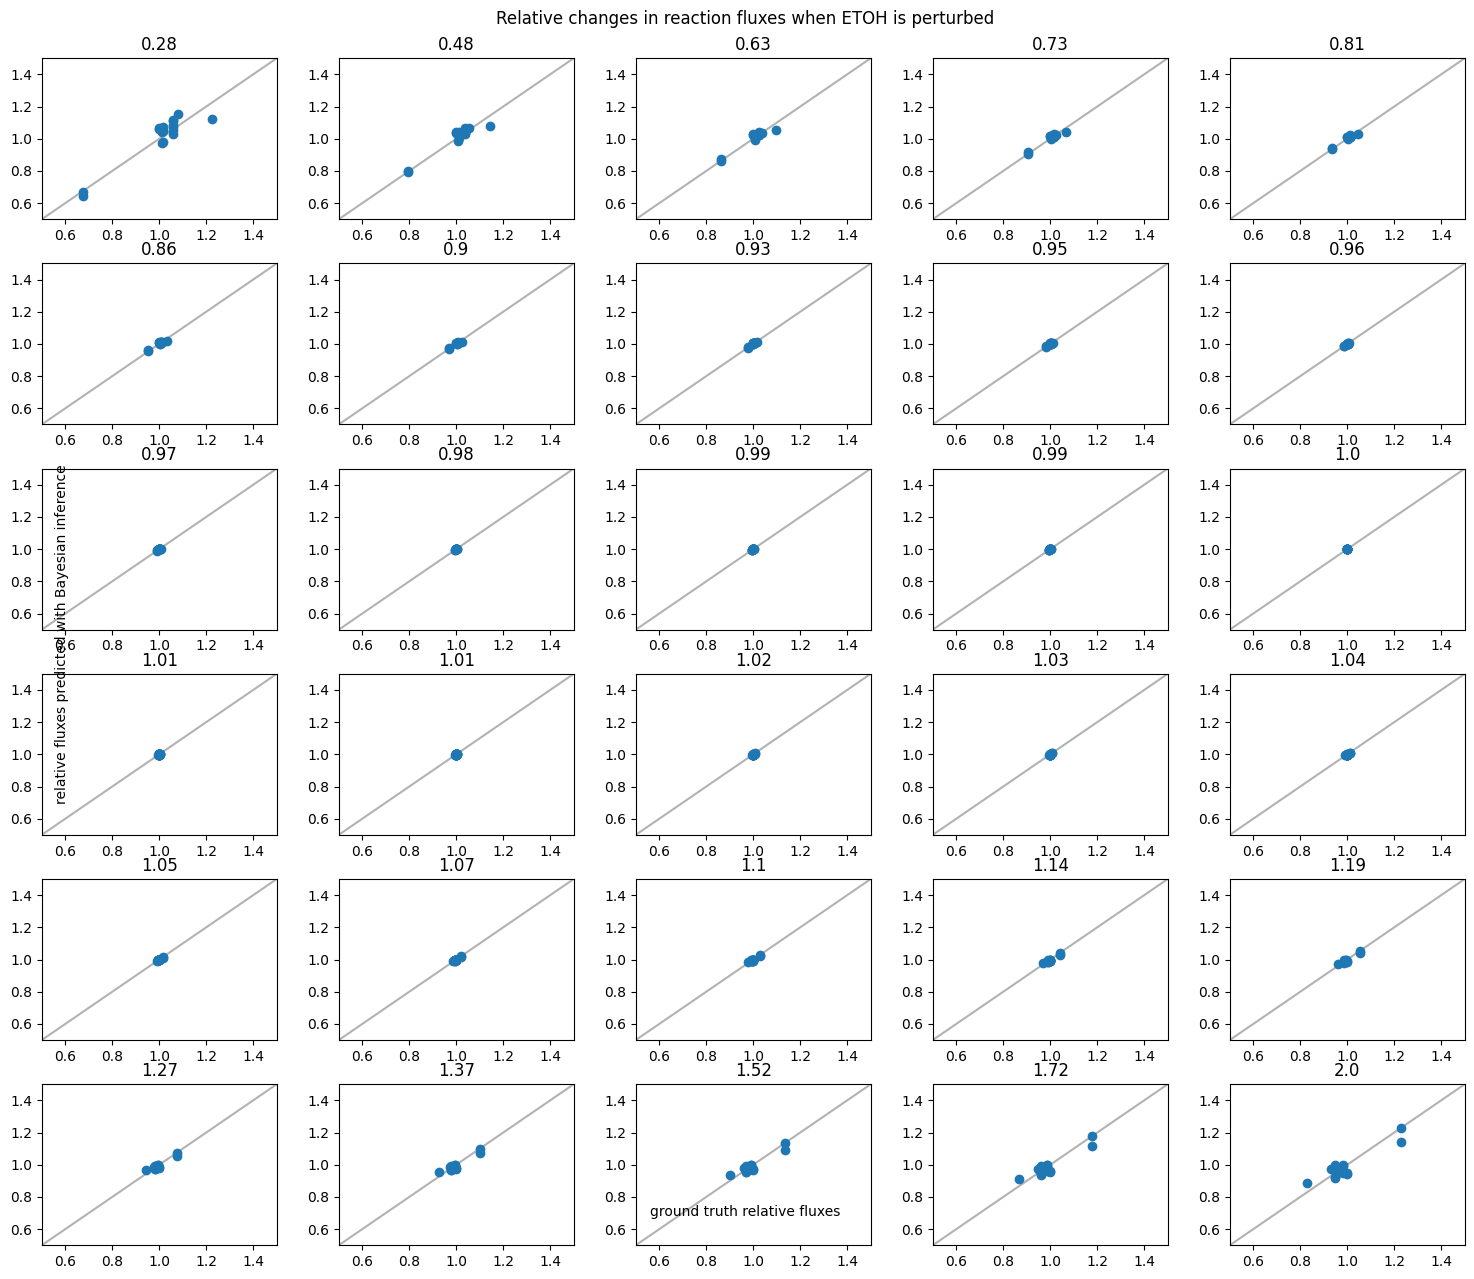

In [57]:
fig, axs = plt.subplots(6,5, figsize=(15, 13)) 
idx_starter = -1

fig.suptitle('Relative changes in reaction fluxes when ETOH is perturbed\n')
fig.tight_layout()

lims = [0.5,1.5]

for i,col in enumerate(d_df.columns): 
    if i%5==0:
      idx_starter += 1
    axs[idx_starter, i%5].plot(lims, lims, 'k-', alpha=0.3, zorder=0)
    axs[idx_starter, i%5].scatter(rel_real_values[col], d_df[col])
    axs[idx_starter, i%5].set_xlim(lims)
    axs[idx_starter, i%5].set_ylim(lims)
    #axs[idx_starter, i%5].set_xlabel('ground truth relative fluxes\n\n')
    #axs[idx_starter, i%5].set_ylabel('relative fluxes predicted with Bayesian inference')
    axs[idx_starter, i%5].set_title(col)

fig.text(0.5, 0.04, 'ground truth relative fluxes\n', ha='center')
fig.text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference', va='center', rotation='vertical')


#plt.legend(["fully parameterized", "Visser priors", "real values"])
#plt.show()

Text(-9, 4, 'r = 0.518')

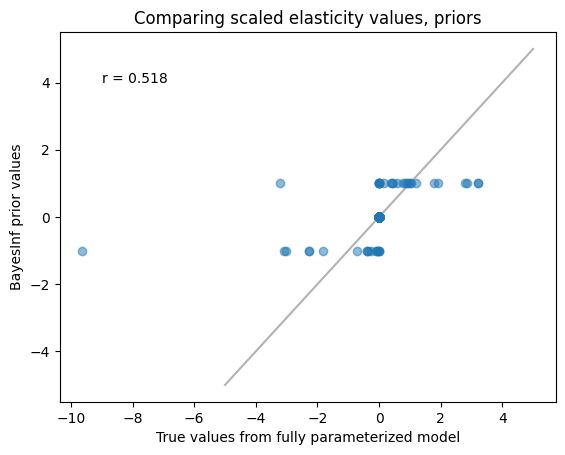

In [58]:
x # the posterior (bayes inf) elasticity values
BIOMD64.Ex # the prior elasticity values
Ex_values = r.getScaledElasticityMatrix()


fig = plt.figure()

plt.scatter(Ex_values, BIOMD64.Ex, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled elasticity values, priors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf prior values')

plt.text(-9,4,'r = ' + str((stats.pearsonr(Ex_values.flatten(), BIOMD64.Ex.to_numpy().flatten())[0]).round(3)))


Text(-9, 4, 'r = 0.512')

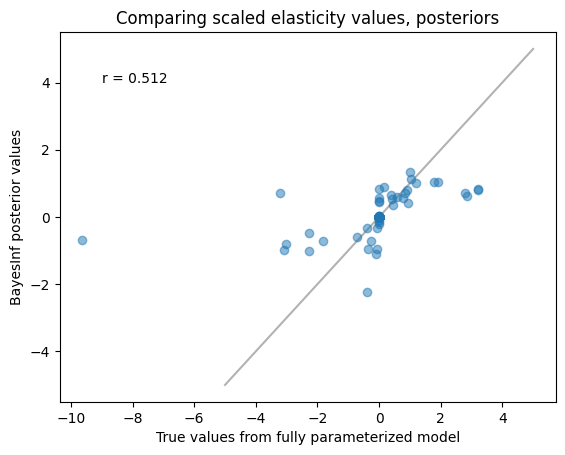

In [59]:
plt.scatter(Ex_values, x, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled elasticity values, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-9,4,'r = ' + str((stats.pearsonr(Ex_values.flatten(), x.flatten())[0]).round(3)))

# the dot all the way to the left is P on PGK

## Plotting MCC and FCC comparisons

In [60]:
gtCCC = pd.DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [61]:
visCCC, visFCC = util.elasticity_to_CCC(BIOMD64, BIOMD64.Ex)  
visCCC = pd.DataFrame(visCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
visFCC.columns = r.getReactionIds()
visFCC.index = r.getReactionIds()
visFCC

vGLK      vPGI    vGLYCO    vTreha      vPFK      vALD    vGAPDH  \
vGLK    0.139587  0.079511  0.031414  0.028661  0.079511  0.079511  0.077840   
vPGI    0.082789  0.110380 -0.015836 -0.011755  0.110380  0.110380  0.075443   
vGLYCO  0.546373 -0.141574  0.814264 -0.126317 -0.141574 -0.141574  0.095007   
vTreha  0.546373 -0.141574 -0.185736  0.873683 -0.141574 -0.141574  0.095007   
vPFK    0.082789  0.110380 -0.015836 -0.011755  0.110380  0.110380  0.075443   
vALD    0.082789  0.110380 -0.015836 -0.011755  0.110380  0.110380  0.075443   
vGAPDH  0.068474  0.075238 -0.003063 -0.003702  0.075238  0.075238  0.087462   
vPGK    0.068474  0.075238 -0.003063 -0.003702  0.075238  0.075238  0.087462   
vPGM    0.068474  0.075238 -0.003063 -0.003702  0.075238  0.075238  0.087462   
vENO    0.068474  0.075238 -0.003063 -0.003702  0.075238  0.075238  0.087462   
vPYK    0.068474  0.075238 -0.003063 -0.003702  0.075238  0.075238  0.087462   
vPDC    0.068474  0.075238 -0.003063 -0.003702  0.075238  0.075238  0.087462   
vSUC    0.190135  0.373902 -0.111619 -0.072148  0.373902  0.373902 -0.014693   
vGLT    0.139587  0.079511  0.031414  0.028661  0.079511  0.079511  0.077840   
vADH    0.061618  0.058410  0.003054  0.000155  0.058410  0.058410  0.093219   
vG3PDH  0.190135  0.373902 -0.111619 -0.072148  0.373902  0.373902 -0.014693   
vATP   -0.087227  0.008724 -0.061453 -0.034497  0.008724  0.008724  0.125343   

            vPGK      vPGM      vENO      vPYK      vPDC      vSUC      vGLT  \
vGLK    0.077840  0.077840  0.077840  0.077840  0.077840  0.000836  0.139587   
vPGI    0.075443  0.075443  0.075443  0.075443  0.075443  0.017469  0.082789   
vGLYCO  0.095007  0.095007  0.095007  0.095007  0.095007 -0.118290  0.546373   
vTreha  0.095007  0.095007  0.095007  0.095007  0.095007 -0.118290  0.546373   
vPFK    0.075443  0.075443  0.075443  0.075443  0.075443  0.017469  0.082789   
vALD    0.075443  0.075443  0.075443  0.075443  0.075443  0.017469  0.082789   
vGAPDH  0.087462  0.087462  0.087462  0.087462  0.087462 -0.006112  0.068474   
vPGK    0.087462  0.087462  0.087462  0.087462  0.087462 -0.006112  0.068474   
vPGM    0.087462  0.087462  0.087462  0.087462  0.087462 -0.006112  0.068474   
vENO    0.087462  0.087462  0.087462  0.087462  0.087462 -0.006112  0.068474   
vPYK    0.087462  0.087462  0.087462  0.087462  0.087462 -0.006112  0.068474   
vPDC    0.087462  0.087462  0.087462  0.087462  0.087462 -0.006112  0.068474   
vSUC   -0.014693 -0.014693 -0.014693 -0.014693 -0.014693  0.194298  0.190135   
vGLT    0.077840  0.077840  0.077840  0.077840  0.077840  0.000836  0.139587   
vADH    0.093219  0.093219  0.093219  0.093219  0.093219 -0.017405  0.061618   
vG3PDH -0.014693 -0.014693 -0.014693 -0.014693 -0.014693  0.194298  0.190135   
vATP    0.125343  0.125343  0.125343  0.125343  0.125343 -0.058310 -0.087227   

            vADH    vG3PDH      vATP  
vGLK    0.077004  0.001671 -0.124330  
vPGI    0.057974  0.034937 -0.032161  
vGLYCO  0.213298 -0.236581 -0.784441  
vTreha  0.213298 -0.236581 -0.784441  
vPFK    0.057974  0.034937 -0.032161  
vALD    0.057974  0.034937 -0.032161  
vGAPDH  0.093574 -0.012224  0.044089  
vPGK    0.093574 -0.012224  0.044089  
vPGM    0.093574 -0.012224  0.044089  
vENO    0.093574 -0.012224  0.044089  
vPYK    0.093574 -0.012224  0.044089  
vPDC    0.093574 -0.012224  0.044089  
vSUC   -0.208991  0.388595 -0.603954  
vGLT    0.077004  0.001671 -0.124330  
vADH    0.110623 -0.034809  0.080605  
vG3PDH -0.208991  0.388595 -0.603954  
vATP    0.183653 -0.116619  0.483450

In [62]:
postCCC, postFCC = util.elasticity_to_CCC(BIOMD64, Ex)  
postCCC = pd.DataFrame(postCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
postFCC = pd.DataFrame(postFCC) #, index=r.getReactionIds(), columns=r.getReactionIds())
postFCC.columns = r.getReactionIds()
postFCC.index = r.getReactionIds()
postFCC

vGLK      vPGI    vGLYCO    vTreha      vPFK      vALD    vGAPDH  \
vGLK    0.129398  0.026895  0.037712  0.032595  0.037956  0.081982  0.061787   
vPGI    0.133783  0.031936 -0.025003 -0.018770  0.045071  0.097571  0.064385   
vGLYCO  0.081023 -0.007461  0.934109 -0.041814 -0.010529 -0.024339  0.044639   
vTreha  0.119195 -0.011394 -0.072166  0.953336 -0.016081 -0.036318  0.041362   
vPFK    0.133783  0.031936 -0.025003 -0.018770  0.045071  0.097571  0.064385   
vALD    0.133783  0.031936 -0.025003 -0.018770  0.045071  0.097571  0.064385   
vGAPDH  0.100816  0.023299 -0.011590 -0.009783  0.032881  0.070501  0.073265   
vPGK    0.100816  0.023299 -0.011590 -0.009783  0.032881  0.070501  0.073265   
vPGM    0.100816  0.023299 -0.011590 -0.009783  0.032881  0.070501  0.073265   
vENO    0.100816  0.023299 -0.011590 -0.009783  0.032881  0.070501  0.073265   
vPYK    0.100816  0.023299 -0.011590 -0.009783  0.032881  0.070501  0.073265   
vPDC    0.100816  0.023299 -0.011590 -0.009783  0.032881  0.070501  0.073265   
vSUC    0.381003  0.096703 -0.125583 -0.086164  0.136475  0.300563 -0.002204   
vGLT    0.129398  0.026895  0.037712  0.032595  0.037956  0.081982  0.061787   
vADH    0.085028  0.019163 -0.005167 -0.005479  0.027044  0.057538  0.077517   
vG3PDH  0.381003  0.096703 -0.125583 -0.086164  0.136475  0.300563 -0.002204   
vATP   -0.006538  0.002170 -0.096497 -0.057664  0.003062  0.003894  0.109296   

            vPGK      vPGM      vENO      vPYK      vPDC      vSUC      vGLT  \
vGLK    0.097046  0.137567  0.094996  0.056918  0.080364 -0.020299  0.138352   
vPGI    0.100335  0.142229  0.098216  0.058847  0.083087 -0.014380  0.143024   
vGLYCO  0.075694  0.107300  0.073737  0.044181  0.062387 -0.064759  0.086436   
vTreha  0.070729  0.100262  0.069688  0.041754  0.058944 -0.060098  0.127950   
vPFK    0.100335  0.142229  0.098216  0.058847  0.083087 -0.014380  0.143024   
vALD    0.100335  0.142229  0.098216  0.058847  0.083087 -0.014380  0.143024   
vGAPDH  0.113006  0.160191  0.109716  0.065738  0.092836 -0.041202  0.106972   
vPGK    0.113006  0.160191  0.109716  0.065738  0.092836 -0.041202  0.106972   
vPGM    0.113006  0.160191  0.109716  0.065738  0.092836 -0.041202  0.106972   
vENO    0.113006  0.160191  0.109716  0.065738  0.092836 -0.041202  0.106972   
vPYK    0.113006  0.160191  0.109716  0.065738  0.092836 -0.041202  0.106972   
vPDC    0.113006  0.160191  0.109716  0.065738  0.092836 -0.041202  0.106972   
vSUC    0.005319  0.007541  0.011979  0.007177  0.009982  0.186758  0.413376   
vGLT    0.097046  0.137567  0.094996  0.056918  0.080364 -0.020299  0.138352   
vADH    0.119074  0.168792  0.115223  0.069037  0.097505 -0.054047  0.089707   
vG3PDH  0.005319  0.007541  0.011979  0.007177  0.009982  0.186758  0.413376   
vATP    0.163642  0.231969  0.156114  0.093538  0.132159 -0.124604 -0.010659   

            vADH    vG3PDH      vATP  
vGLK    0.044181  0.047996 -0.085446  
vPGI    0.035004  0.068070 -0.043406  
vGLYCO  0.113221 -0.089955 -0.383871  
vTreha  0.105761 -0.103060 -0.389863  
vPFK    0.035004  0.068070 -0.043406  
vALD    0.035004  0.068070 -0.043406  
vGAPDH  0.079101  0.016271  0.017984  
vPGK    0.079101  0.016271  0.017984  
vPGM    0.079101  0.016271  0.017984  
vENO    0.079101  0.016271  0.017984  
vPYK    0.079101  0.016271  0.017984  
vPDC    0.079101  0.016271  0.017984  
vSUC   -0.295676  0.456511 -0.503761  
vGLT    0.044181  0.047996 -0.085446  
vADH    0.100219 -0.008535  0.047382  
vG3PDH -0.295676  0.456511 -0.503761  
vATP    0.217247 -0.129119  0.311990

Text(-4, 4, 'r = 0.482')

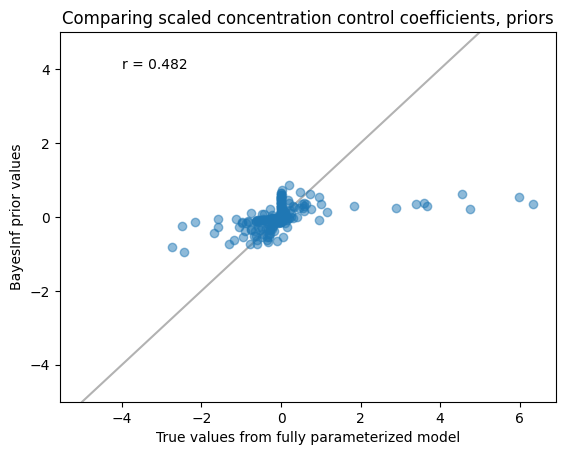

In [63]:
fig = plt.figure()

plt.scatter(gtCCC, visCCC, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.ylim([-5,5])
plt.title('Comparing scaled concentration control coefficients, priors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf prior values')

plt.text(-4,4,'r = ' + str((stats.pearsonr(gtCCC.to_numpy().flatten(), visCCC.to_numpy().flatten())[0]).round(3)))


Text(-4, 4, 'r = 0.623')

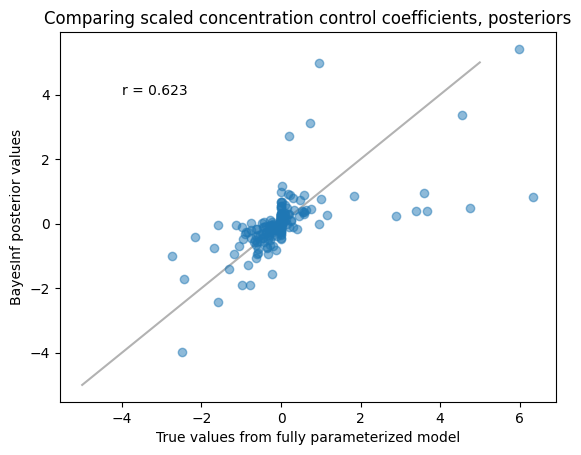

In [64]:
fig = plt.figure()

plt.scatter(gtCCC, postCCC, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled concentration control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-4,4,'r = ' + str((stats.pearsonr(gtCCC.to_numpy().flatten(), postCCC.to_numpy().flatten())[0]).round(3)))

Text(-1, 2, 'r = 0.234')

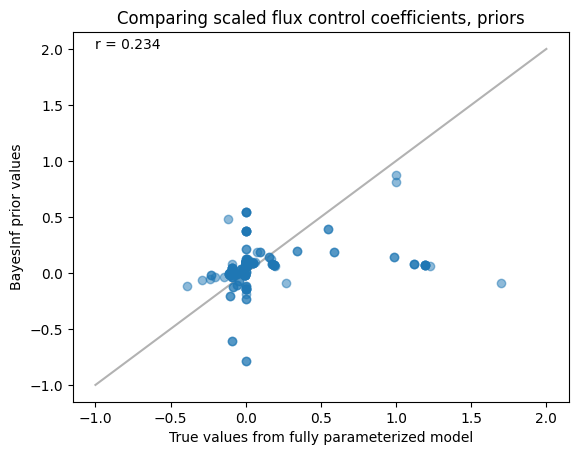

In [65]:
fig = plt.figure()

plt.scatter(gtFCC, visFCC, alpha=0.5)
plt.plot([-1,2], [-1,2], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficients, priors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf prior values')
plt.text(-1,2,'r = ' + str((stats.pearsonr(gtFCC.to_numpy().flatten(), visFCC.to_numpy().flatten())[0]).round(3)))

Text(-1, 2, 'r = 0.407')

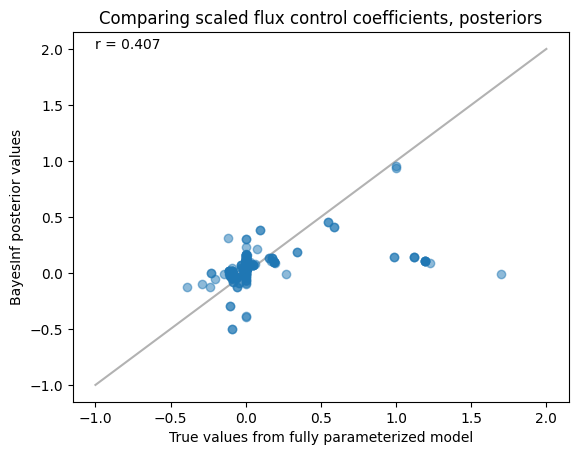

In [66]:
fig = plt.figure()

plt.scatter(gtFCC, postFCC, alpha=0.5)
plt.plot([-1,2], [-1,2], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-1,2,'r = ' + str((stats.pearsonr(gtFCC.to_numpy().flatten(), postFCC.to_numpy().flatten())[0]).round(3)))

## Pairwise comparison of FCC values

In [100]:
def plot_pairwise_FCCs(yield_enzyme):
    priors = pd.DataFrame(visFCC[yield_enzyme])
    priors['distribution'] = ['prior']* len(priors)
    posteriors = pd.DataFrame(postFCC[yield_enzyme])
    posteriors['distribution'] = ['posterior']* len(posteriors)
    paired = pd.concat([priors, posteriors]).reset_index()
    pv_tbl = paired.pivot('index', 'distribution', yield_enzyme)

    fig = pv_tbl[['prior', 'posterior']].plot(kind='bar', colormap='winter')
    plt.title(f'FCCs for {yield_enzyme}, before & after Bayesian inference')

    for i,val in enumerate(gtFCC[yield_enzyme]):
        plt.axhline(y = val,    # Line on y = 0.2
                xmin = (i+0.2)/len(gtFCC[yield_enzyme]), # From the left
                xmax = (i+0.8)/len(gtFCC[yield_enzyme]), 
                c='red') # To the right

C:\Users\user\AppData\Local\Temp\ipykernel_8760\1095821133.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



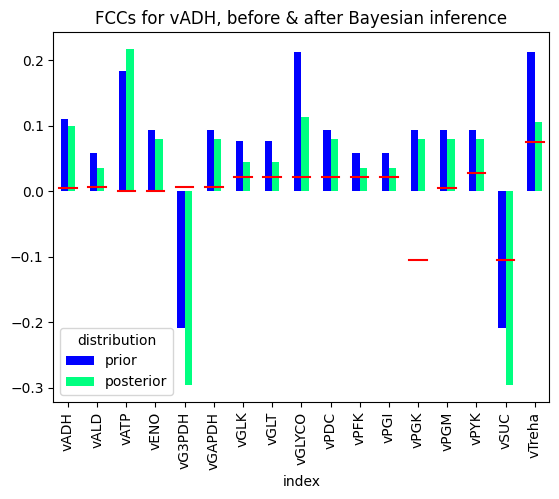

In [101]:
plot_pairwise_FCCs('vADH')

C:\Users\user\AppData\Local\Temp\ipykernel_8760\1095821133.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



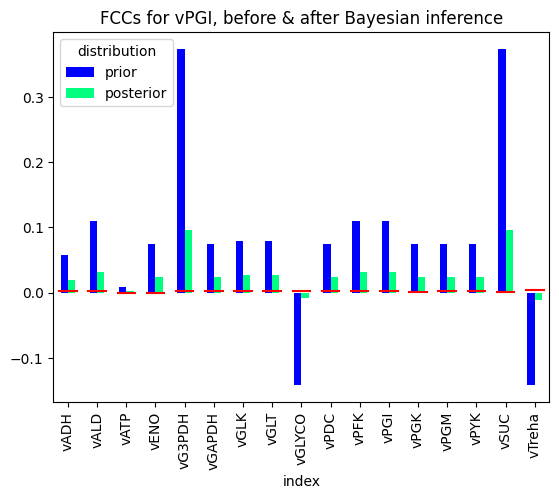

In [102]:
plot_pairwise_FCCs('vPGI')

C:\Users\user\AppData\Local\Temp\ipykernel_8760\1095821133.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



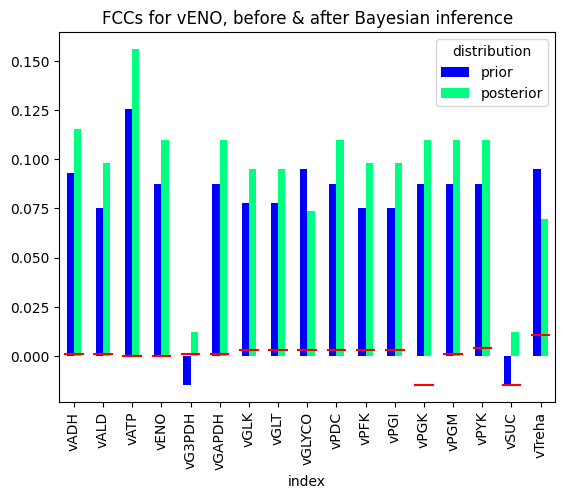

In [105]:
plot_pairwise_FCCs('vENO')

## Ranking FCC values

In [190]:
def rank_FCC_values(yield_enzyme): 
    FCCrankings = pd.concat([gtFCC.loc[yield_enzyme].rank(), visFCC.loc[yield_enzyme].rank(), postFCC.loc[yield_enzyme].rank()], axis=1)
    FCCrankings.columns=['gt', 'visE', 'postE']

    fig = plt.figure()

    plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
    plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
    plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
    plt.title(f'Comparing scaled flux control coefficient rankings, {yield_enzyme}')
    plt.xlabel('ordinal values from fully parameterized model')
    plt.ylabel('ordinal values from linlog approximations')

    plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
    plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
    plt.text(13,0,'Wilcoxon p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))
    plt.legend()

    FCCrankings['visE_dif'] = FCCrankings['visE'] - FCCrankings['gt']
    FCCrankings['postE_dif'] = FCCrankings['postE'] - FCCrankings['gt']
    FCCrankings.sort_values('gt')[['visE_dif','postE_dif']].plot(kind='bar', align='edge', width=0.7, alpha=0.7)
    plt.title(f'Rankings of FCC values for {yield_enzyme} predicted by Bayesian inference')
    plt.xlabel("reactions in order of gt FCC ranking")
    plt.ylabel("FCC ranking")

    return FCCrankings.sort_values('gt')

<AxesSubplot: >

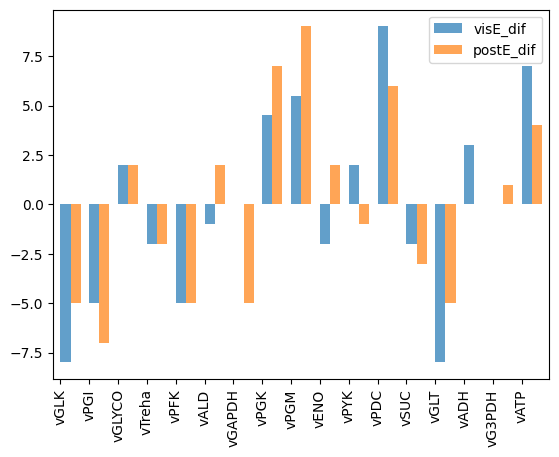

In [185]:
FCCrankings[['visE_dif','postE_dif']].plot(kind='bar', align='edge', width=0.7, alpha=0.7)

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.



gt  visE  postE  visE_dif  postE_dif
vGLYCO   1.0   2.0    2.0       1.0        1.0
vATP     2.0   1.0    1.0      -1.0       -1.0
vTreha   3.0   3.0    3.0       0.0        0.0
vG3PDH   4.0   5.0   10.0       1.0        6.0
vSUC     5.0   4.0    4.0      -1.0       -1.0
vPDC     6.0   8.0   11.0       2.0        5.0
vPGM     7.0  12.0   16.0       5.0        9.0
vALD     8.0  17.0   12.0       9.0        4.0
vPGK     9.0  10.0   14.0       1.0        5.0
vPYK    10.0  11.0    8.0       1.0       -2.0
vENO    11.0   9.0   13.0      -2.0        2.0
vPFK    12.0  16.0    7.0       4.0       -5.0
vPGI    13.0  15.0    5.0       2.0       -8.0
vADH    14.0   6.0    6.0      -8.0       -8.0
vGAPDH  15.0   7.0    9.0      -8.0       -6.0
vGLK    16.0  14.0   15.0      -2.0       -1.0
vGLT    17.0  13.0   17.0      -4.0        0.0

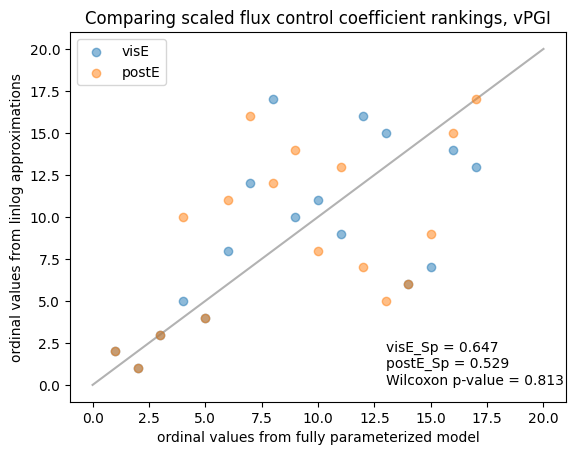

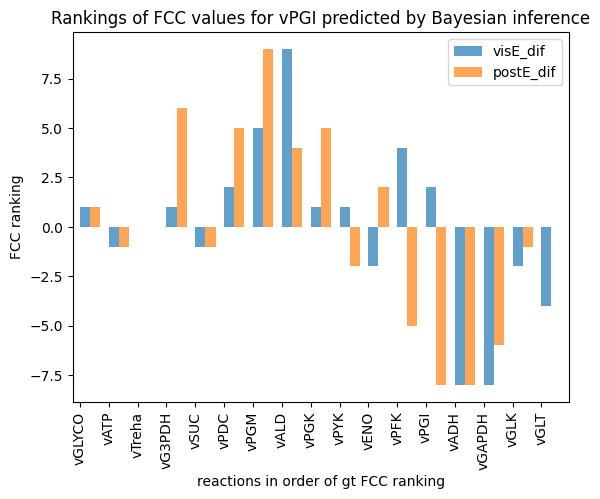

In [191]:
rank_FCC_values('vPGI')

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.



gt  visE  postE  visE_dif  postE_dif
vG3PDH   1.0   1.0    4.0       0.0        3.0
vGLYCO   2.0   4.0    2.0       2.0        0.0
vATP     3.0   5.0    5.0       2.0        2.0
vTreha   4.0   3.0    3.0      -1.0       -1.0
vSUC     5.0   2.0    1.0      -3.0       -4.0
vALD     6.0   9.0    9.0       3.0        3.0
vPDC     7.0  13.0   12.0       6.0        5.0
vPGM     8.0  15.0   17.0       7.0        9.0
vPGK     9.0  12.0   16.0       3.0        7.0
vPYK    10.0  14.0    8.0       4.0       -2.0
vPFK    11.0   8.0    7.0      -3.0       -4.0
vPGI    12.0  10.0    6.0      -2.0       -6.0
vENO    13.0  11.0   15.0      -2.0        2.0
vADH    14.0  17.0   11.0       3.0       -3.0
vGAPDH  15.0  16.0   10.0       1.0       -5.0
vGLK    16.0   6.0   13.0     -10.0       -3.0
vGLT    17.0   7.0   14.0     -10.0       -3.0

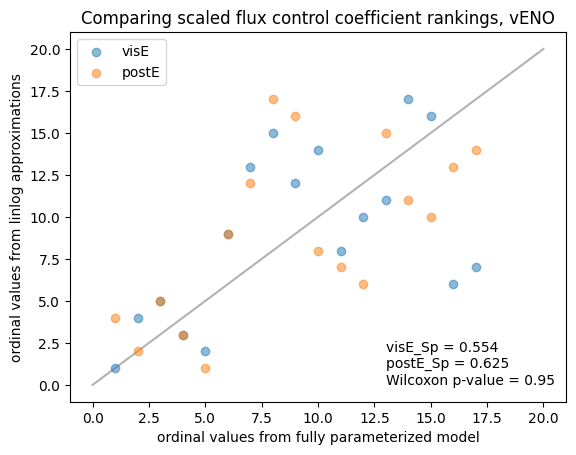

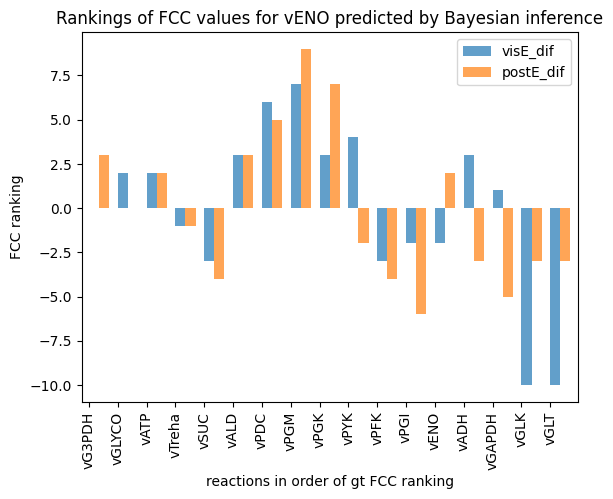

In [192]:
rank_FCC_values('vENO')

## Distribution of FCC 

In [33]:
visE_r=[]
postE_r=[]

for i in r.getReactionIds():        
    FCCrankings = pd.concat([gtFCC.loc[i].rank(), visFCC.loc[i].rank(), postFCC.loc[i].rank()], axis=1)
    FCCrankings.columns=['gt', 'visE', 'postE']

    visE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0])
    postE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0])


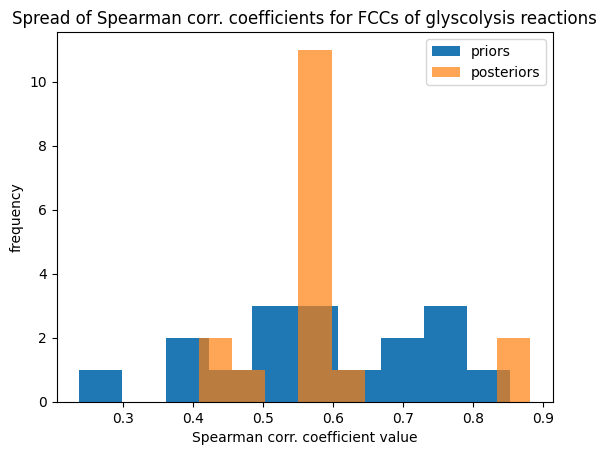

In [34]:
plt.hist(visE_r, label='priors')
plt.hist(postE_r, alpha=0.7, label='posteriors')
plt.legend()
plt.xlabel('Spearman corr. coefficient value')
plt.ylabel('frequency')
plt.title('Spread of Spearman corr. coefficients for FCCs of glyscolysis reactions')

plt.show()


# Perturbing enzymes

In [35]:
pt_levels= np.logspace(-1, 0, num=20)
pt_levels = pt_levels.round(3)
pt_levels

array([0.1  , 0.113, 0.127, 0.144, 0.162, 0.183, 0.207, 0.234, 0.264,
       0.298, 0.336, 0.379, 0.428, 0.483, 0.546, 0.616, 0.695, 0.785,
       0.886, 1.   ])

In [37]:
Teusink_ant ='data/interim/Antimony/BIOMD0000000064_e.ant' 
data_file = 'data/interim/generated_data/enzymeCompilation.csv'
df = pd.read_csv(data_file)

# need to fix this so only rows with concentrations less than 0 are dropped 
data = df.drop(df[df.lt(0).any(axis=1)].index)

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

5.935978122618177e-12

In [38]:
BIOMD64 = BMCA.BMCA(Teusink_ant, data_file)

Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

In [39]:
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BIOMD64.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BIOMD64.Ey.to_numpy(), name='Ey'))

    trace_prior = pm.sample_prior_predictive(samples=1000)

Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]


In [40]:
with pymc_model:
    
    e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BIOMD64.en.T)
    chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BIOMD64.xn.T)
    y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BIOMD64.yn.T)


In [41]:
with pymc_model:
    
    likelihood = pm.Deterministic('vn', e_obs * (np.ones((17,641)) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
    v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BIOMD64.vn.squeeze().T)

pymc_model.free_RVs

[Ex_kinetic_entries ~ SkewNormal(0, 1, 5),
 Ex_capacity_entries ~ Laplace(0, 0.01),
 Ey_kinetic_entries ~ SkewNormal(0, 1, 5),
 Ey_capacity_entries ~ Laplace(0, 0.01)]

In [42]:
N_ITERATIONS = 50000
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = advi.fit(
        n=       N_ITERATIONS, 
        callbacks = [tracker],
        obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
        total_grad_norm_constraint=0.7,
        obj_n_mc=1)
    
    trace_vi = approx.sample(draws=1000, random_seed=1) 
    ppc_vi = pm.sample_posterior_predictive(trace_vi, random_seed=1)
    

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1.4318e+05
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


In [43]:
# takig the median peaks can only be done if the distributions are unimodal!
Ex_trace = (trace_vi['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
Ex_trace.shape

(17, 14, 1000)

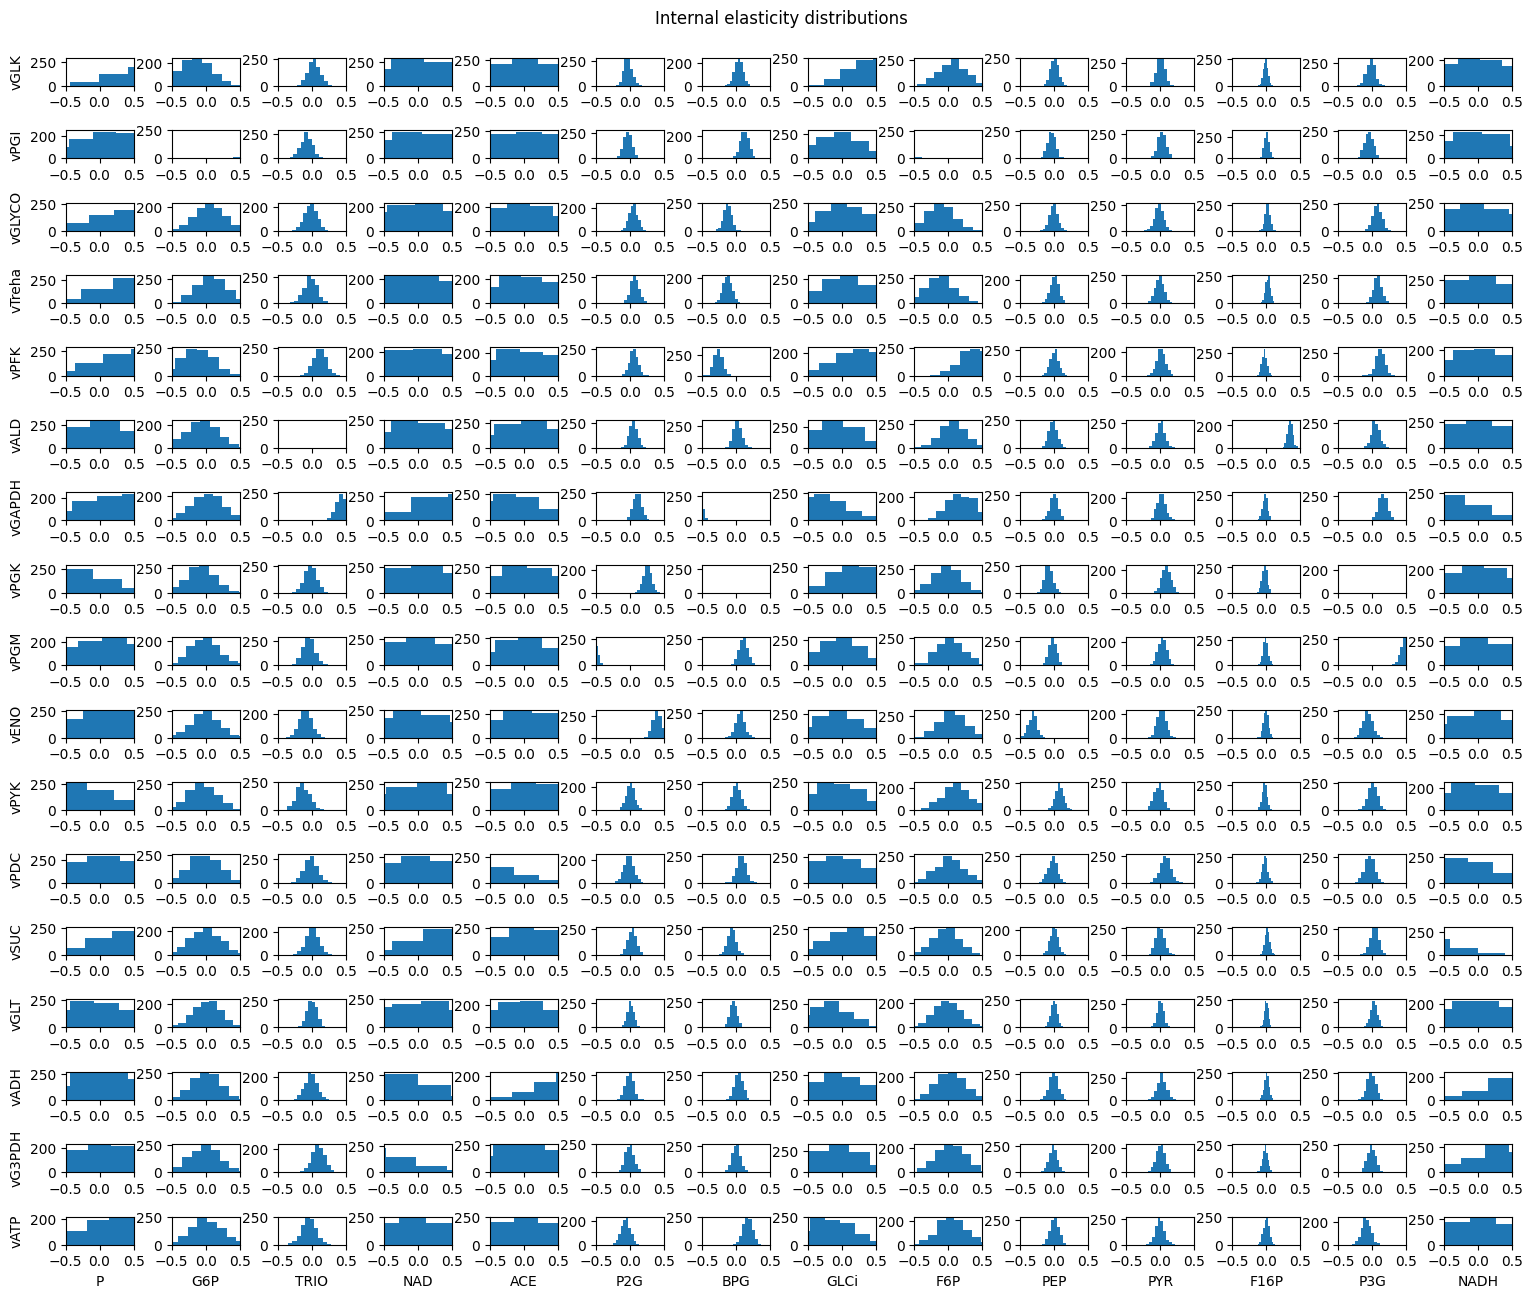

In [44]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,14, figsize=(15, 13)) 

fig.suptitle('Internal elasticity distributions\n')
fig.tight_layout()

for i in range(17):
  for ii in range(14):
    axs[i,ii].hist(Ex_trace[i,ii,:])
    axs[i,ii].set_xlim([-0.5,0.5])

    if ii == 0:
      axs[i,ii].set_ylabel(r.getReactionIds()[i])
    if i == 16: 
      axs[i,ii].set_xlabel(r.getFloatingSpeciesIds()[ii])

In [45]:
Ex_peaks=[]

for i in range(Ex_trace.shape[0]):
    for ii in range(Ex_trace.shape[1]):
        Ex_peaks.append(np.percentile(Ex_trace[i,ii,:],50))


In [46]:
# these are the elasticity posteriors from Bayesian inference
x = np.array(Ex_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
x[abs(x) < 0.01] = 0

x = x.reshape((17,14))
Ex = pd.DataFrame(x, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds())
Ex

P       G6P      TRIO       NAD       ACE       P2G       BPG  \
vGLK    1.010570 -0.151892  0.032459  0.000000  0.016912 -0.029778  0.043943   
vPGI    0.181011  1.213253 -0.072133 -0.011341  0.035234 -0.029337  0.124355   
vGLYCO  0.662317  0.067803 -0.010035 -0.010504 -0.034727  0.051919 -0.120354   
vTreha  0.675493  0.082963 -0.015632  0.000000 -0.017288  0.071511 -0.123350   
vPFK    0.604272 -0.127971  0.120914  0.032174 -0.038097  0.054575 -0.259529   
vALD    0.026562 -0.050575 -0.984839  0.038089  0.038398  0.053732  0.020008   
vGAPDH  0.336389  0.031811  0.457705  0.742306 -0.254788  0.110461 -0.570730   
vPGK   -0.591852 -0.080304 -0.017385 -0.018654  0.052982  0.255227  0.690541   
vPGM    0.087747 -0.019398 -0.037553  0.000000  0.017162 -0.551476  0.108613   
vENO    0.100962  0.000000 -0.091742 -0.010884  0.054034  0.399968  0.059368   
vPYK   -0.466814 -0.048886 -0.130243  0.018495  0.090760  0.000000  0.010871   
vPDC    0.104108 -0.030280 -0.015795  0.032990 -0.879811 -0.014633  0.079326   
vSUC    0.618869  0.000000  0.000000  0.671669  0.101229  0.033853 -0.060140   
vGLT   -0.092585  0.031134  0.000000  0.049736 -0.010995  0.000000 -0.037966   
vADH    0.085401  0.000000 -0.011028 -0.529221  0.832899  0.000000  0.037409   
vG3PDH  0.026556  0.000000  0.099395 -1.015493 -0.016353  0.000000  0.000000   
vATP    0.316450  0.010538 -0.038453  0.000000  0.048373 -0.059534  0.173735   

            GLCi       F6P       PEP       PYR      F16P       P3G      NADH  
vGLK    0.485920  0.067970  0.000000  0.000000  0.000000 -0.020747  0.000000  
vPGI   -0.059982 -0.980369 -0.038734  0.024070  0.000000 -0.051289 -0.048038  
vGLYCO  0.018483 -0.108944  0.000000 -0.015771  0.019600  0.070320  0.000000  
vTreha  0.000000 -0.124744  0.000000  0.000000  0.022763  0.076242 -0.010697  
vPFK    0.282176  0.398845  0.000000  0.012073 -0.028319  0.119083  0.000000  
vALD   -0.102283  0.071920 -0.015153  0.000000  0.350069  0.045154  0.000000  
vGAPDH -0.350738  0.189534  0.000000  0.014863 -0.017314  0.158107 -0.683667  
vPGK    0.182639 -0.020787 -0.079034  0.088543 -0.022881 -0.896168  0.000000  
vPGM   -0.044612  0.032261 -0.020000  0.031039 -0.011705  0.486375  0.000000  
vENO   -0.078939  0.067266 -0.311510  0.019909  0.000000 -0.067534  0.024702  
vPYK   -0.091170  0.118887  0.077511 -0.023179 -0.025748  0.000000 -0.022205  
vPDC   -0.076698  0.026868 -0.016886  0.076016 -0.018857 -0.042918 -0.443921  
vSUC    0.144639 -0.034142  0.000000  0.000000  0.015085  0.030154 -1.106239  
vGLT   -0.207276  0.000000  0.000000  0.000000  0.000000  0.022868 -0.019543  
vADH   -0.049741  0.027953  0.000000  0.023004  0.000000 -0.015690  0.828408  
vG3PDH -0.045036  0.048799 -0.014104  0.000000 -0.016540 -0.013563  0.432012  
vATP   -0.187553  0.047241  0.000000  0.000000  0.000000 -0.092298  0.025813

In [47]:
Ey_trace = (trace_vi['posterior']['Ey']).to_numpy().squeeze().transpose(1, 2, 0)
Ey_trace.shape

(17, 5, 1000)

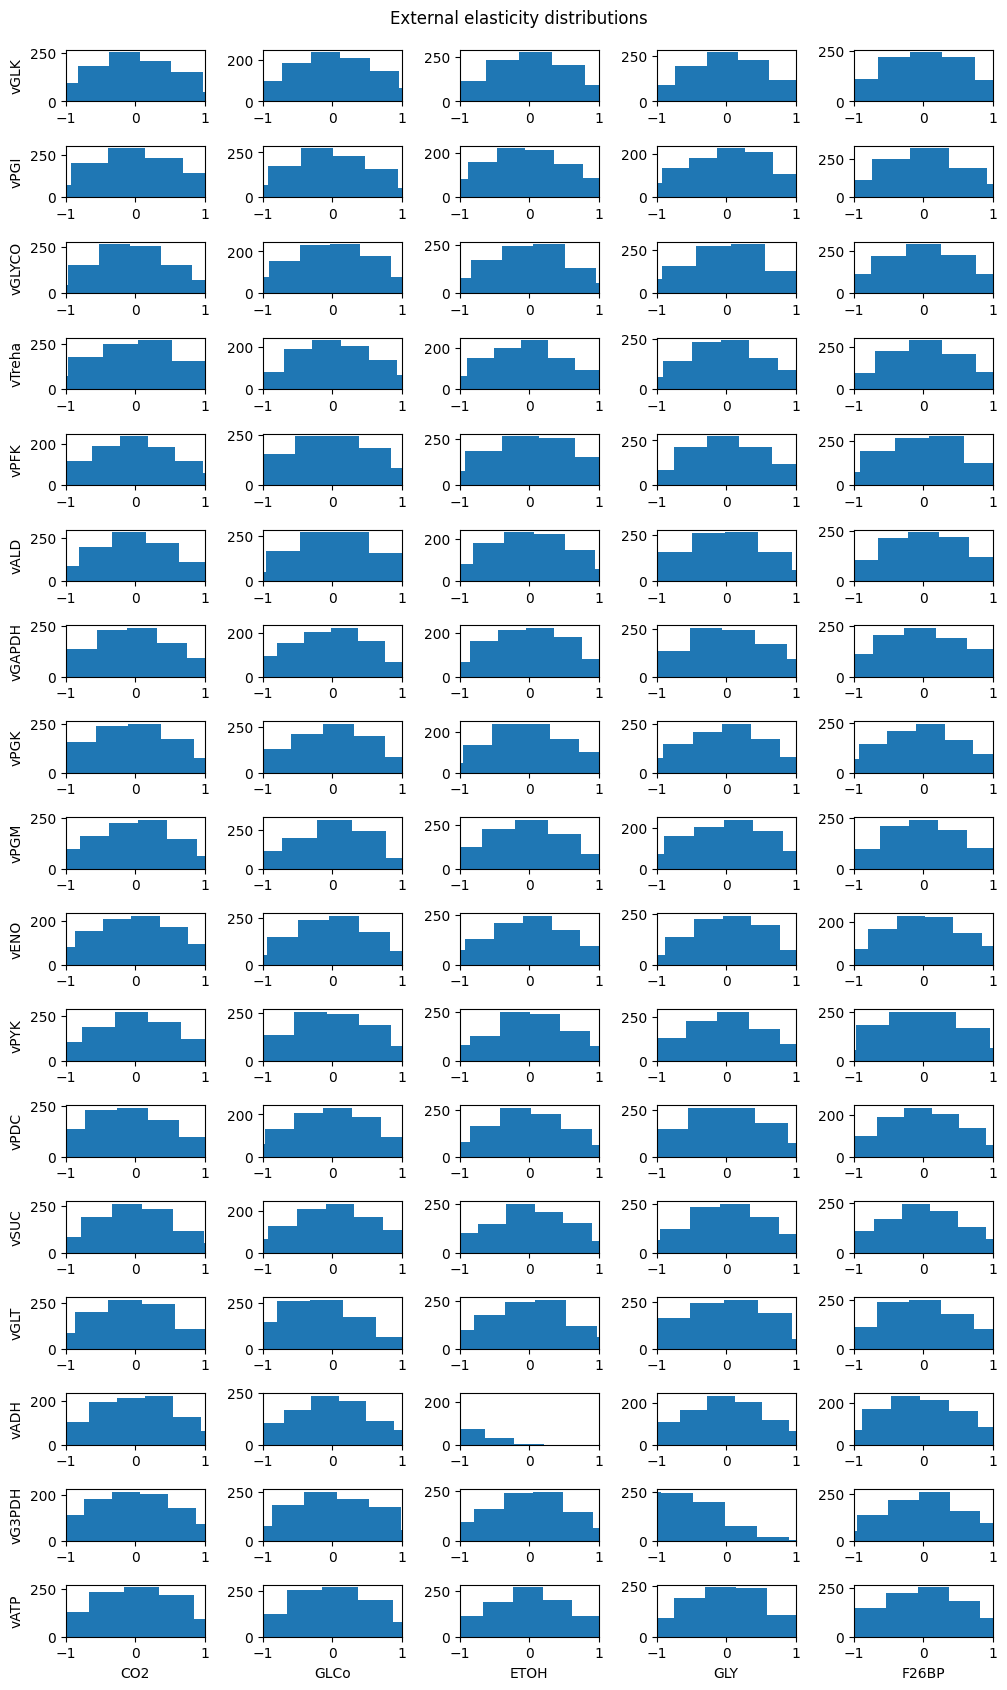

In [48]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,5, figsize=(10, 17)) 

fig.suptitle('External elasticity distributions\n')
fig.tight_layout()

for i in range(17):
  for ii in range(5):
    axs[i,ii].hist(Ey_trace[i,ii,:])
    axs[i,ii].set_xlim([-1,1])

    if ii == 0:
      axs[i,ii].set_ylabel(r.getReactionIds()[i])
    if i == 16: 
      axs[i,ii].set_xlabel(r.getBoundarySpeciesIds()[ii])

In [49]:
Ey_peaks=[]

for i in range(Ey_trace.shape[0]):
    for ii in range(Ey_trace.shape[1]):
        Ey_peaks.append(np.percentile(Ey_trace[i,ii,:],50))


In [50]:
# elasticities from Bayesian inf posteriors

y = np.array(Ey_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
y[abs(y) < 0.01] = 0

y = y.reshape((17,5))
Ey = pd.DataFrame(y, index=r.getReactionIds(), columns=r.getBoundarySpeciesIds())
Ey

CO2      GLCo      ETOH       GLY     F26BP
vGLK   -0.029989  0.000000  0.032047  0.025128  0.027745
vPGI    0.000000 -0.056348 -0.052186  0.049591  0.000000
vGLYCO -0.052857 -0.010078  0.000000  0.023016  0.000000
vTreha  0.000000  0.016732 -0.022550 -0.017766  0.019491
vPFK    0.000000  0.000000  0.039089  0.000000  0.016448
vALD   -0.028354  0.024641  0.000000  0.000000  0.000000
vGAPDH -0.016083  0.000000 -0.012287  0.014256  0.000000
vPGK   -0.023576  0.039668 -0.023427  0.000000 -0.024658
vPGM    0.000000  0.000000 -0.047608  0.034185  0.000000
vENO    0.000000  0.013618  0.019729  0.074407  0.013195
vPYK    0.000000 -0.011595  0.024980  0.000000  0.000000
vPDC   -0.167908  0.000000 -0.039737 -0.021622 -0.025831
vSUC   -0.032827  0.000000  0.012308  0.020678 -0.019720
vGLT   -0.053199 -0.288377  0.000000  0.000000 -0.048838
vADH    0.028146 -0.033854 -1.905218 -0.011453 -0.043233
vG3PDH -0.029311  0.000000  0.032301 -0.868455  0.048504
vATP    0.026636  0.000000 -0.016886  0.000000  0.040195

In [51]:
enzymes = [i for i in data.columns if 'e_' in i]

In [52]:
a = data[enzymes].apply(lambda row: row[row != 1].index, axis=1)
pt_enz = [i[0] for i in a[1:]]

a = data[data[enzymes] != 1].values.flatten()
pt_lvls = a[~np.isnan(a)]

C:\Users\user\AppData\Local\Temp\ipykernel_23988\1020810182.py:2: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [53]:
# zip pt_enz and pt_lvls together and then assign them as the column names
enzPtLvls = [x +'|'+ str(y) for x, y in zip(pt_enz, pt_lvls)]

In [54]:
# get the real values
real_values = data[[i for i in data.columns if 'v_' in i]]
rel_real_values = real_values.div(real_values.iloc[0])
rel_real_values.drop(rel_real_values.index[0], inplace=True)
rel_real_values.columns = r.getReactionIds()
rel_real_values = rel_real_values.transpose()
rel_real_values.columns = enzPtLvls
rel_real_values

e_vGLK|0.9  e_vGLK|1.1  e_vPGI|0.9  e_vPGI|1.1  e_vGLYCO|0.9  \
vGLK      0.980507    1.012952    0.999750    1.000193      1.002050   
vPGI      0.977785    1.014761    0.999715    1.000220      1.010093   
vGLYCO    1.000000    1.000000    1.000000    1.000000      0.900000   
vTreha    1.000000    1.000000    1.000000    1.000000      1.000000   
vPFK      0.977785    1.014761    0.999715    1.000220      1.010093   
vALD      0.977785    1.014761    0.999715    1.000220      1.010093   
vGAPDH    0.976366    1.015693    0.999697    1.000234      1.010641   
vPGK      0.976366    1.015693    0.999697    1.000234      1.010641   
vPGM      0.976366    1.015693    0.999697    1.000234      1.010641   
vENO      0.976366    1.015693    0.999697    1.000234      1.010641   
vPYK      0.976366    1.015693    0.999697    1.000234      1.010641   
vPDC      0.976366    1.015693    0.999697    1.000234      1.010641   
vSUC      0.988426    1.007765    0.999851    1.000115      1.005985   
vGLT      0.980507    1.012952    0.999750    1.000193      1.002050   
vADH      0.975687    1.016140    0.999688    1.000241      1.010904   
vG3PDH    0.988426    1.007765    0.999851    1.000115      1.005985   
vATP      0.966324    1.022331    0.999568    1.000334      1.029059   

        e_vGLYCO|1.1  e_vTreha|0.9  e_vTreha|1.1  e_vPFK|0.9  e_vPFK|1.1  \
vGLK        0.997776      1.001431      0.998486    0.999806    1.000146   
vPGI        0.989709      1.007836      0.992069    0.999779    1.000166   
vGLYCO      1.100000      1.000000      1.000000    1.000000    1.000000   
vTreha      1.000000      0.900000      1.100000    1.000000    1.000000   
vPFK        0.989709      1.007836      0.992069    0.999779    1.000166   
vALD        0.989709      1.007836      0.992069    0.999779    1.000166   
vGAPDH      0.989129      1.008280      0.991611    0.999765    1.000177   
vPGK        0.989129      1.008280      0.991611    0.999765    1.000177   
vPGM        0.989129      1.008280      0.991611    0.999765    1.000177   
vENO        0.989129      1.008280      0.991611    0.999765    1.000177   
vPYK        0.989129      1.008280      0.991611    0.999765    1.000177   
vPDC        0.989129      1.008280      0.991611    0.999765    1.000177   
vSUC        0.994055      1.004513      0.995505    0.999884    1.000087   
vGLT        0.997776      1.001431      0.998486    0.999806    1.000146   
vADH        0.988852      1.008492      0.991391    0.999758    1.000182   
vG3PDH      0.994055      1.004513      0.995505    0.999884    1.000087   
vATP        0.970556      1.020137      0.979678    0.999665    1.000251   

        e_vALD|0.9  e_vALD|1.1  e_vGAPDH|0.9  e_vGAPDH|1.1  e_vPGK|0.9  \
vGLK      0.999960    1.000031      0.998572      1.001237    0.999958   
vPGI      0.999954    1.000036      0.998372      1.001410    0.999952   
vGLYCO    1.000000    1.000000      1.000000      1.000000    1.000000   
vTreha    1.000000    1.000000      1.000000      1.000000    1.000000   
vPFK      0.999954    1.000036      0.998372      1.001410    0.999952   
vALD      0.999954    1.000036      0.998372      1.001410    0.999952   
vGAPDH    0.999951    1.000038      0.994962      1.004513    0.999849   
vPGK      0.999951    1.000038      0.994962      1.004513    0.999849   
vPGM      0.999951    1.000038      0.994962      1.004513    0.999849   
vENO      0.999951    1.000038      0.994962      1.004513    0.999849   
vPYK      0.999951    1.000038      0.994962      1.004513    0.999849   
vPDC      0.999951    1.000038      0.994962      1.004513    0.999849   
vSUC      0.999976    1.000019      1.023951      0.978139    1.000723   
vGLT      0.999960    1.000031      0.998572      1.001237    0.999958   
vADH      0.999950    1.000039      0.993328      1.005999    0.999800   
vG3PDH    0.999976    1.000019      1.023951      0.978139    1.000723   
vATP      0.999931    1.000054      0.982581      1.015760    0.999476   

        e

Text(-9, 4, 'r = 0.491')

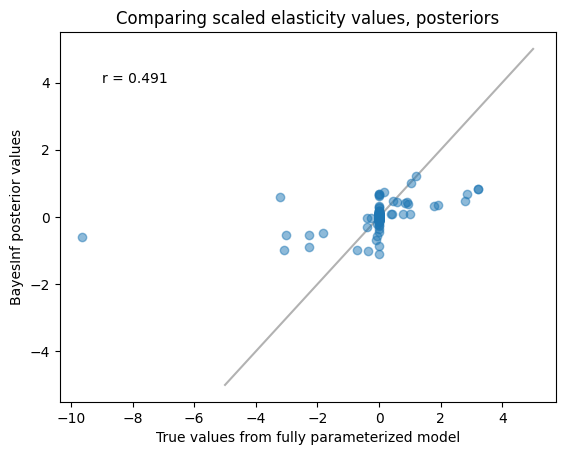

In [55]:
plt.scatter(Ex_values, x, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled elasticity values, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-9,4,'r = ' + str((stats.pearsonr(Ex_values.flatten(), x.flatten())[0]).round(3)))

# the dot all the way to the left is P on PGK

## Plotting MCC and FCC comparisons

In [56]:
gtCCC = pd.DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [57]:
postCCC, postFCC = util.elasticity_to_CCC(BIOMD64, Ex)  
postCCC = pd.DataFrame(postCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
postFCC = pd.DataFrame(postFCC) #, index=r.getReactionIds(), columns=r.getReactionIds())
postFCC.columns = r.getReactionIds()
postFCC.index = r.getReactionIds()
postFCC

vGLK      vPGI    vGLYCO    vTreha      vPFK      vALD    vGAPDH  \
vGLK    0.338550  0.045567  0.120855  0.097565 -0.453093  0.070023  0.467803   
vPGI    0.418637  0.056143  0.046011  0.037359 -0.493628  0.073805  0.478991   
vGLYCO -0.291755 -0.024146  1.173890  0.140757 -0.329593  0.066304  0.556549   
vTreha -0.164130 -0.037719  0.010633  1.013751  0.045733  0.013718  0.176576   
vPFK    0.418637  0.056143  0.046011  0.037359 -0.493628  0.073805  0.478991   
vALD    0.418637  0.056143  0.046011  0.037359 -0.493628  0.073805  0.478991   
vGAPDH  0.467410  0.063283  0.066801  0.053088 -0.572655  0.082855  0.571135   
vPGK    0.467410  0.063283  0.066801  0.053088 -0.572655  0.082855  0.571135   
vPGM    0.467410  0.063283  0.066801  0.053088 -0.572655  0.082855  0.571135   
vENO    0.467410  0.063283  0.066801  0.053088 -0.572655  0.082855  0.571135   
vPYK    0.467410  0.063283  0.066801  0.053088 -0.572655  0.082855  0.571135   
vPDC    0.467410  0.063283  0.066801  0.053088 -0.572655  0.082855  0.571135   
vSUC    0.052895  0.002606 -0.109887 -0.080586  0.098991  0.005942 -0.211984   
vGLT    0.338550  0.045567  0.120855  0.097565 -0.453093  0.070023  0.467803   
vADH    0.490766  0.066701  0.076757  0.060620 -0.610500  0.087189  0.615261   
vG3PDH  0.052895  0.002606 -0.109887 -0.080586  0.098991  0.005942 -0.211984   
vATP    0.789631  0.107814 -0.017092  0.010630 -0.920153  0.120904  0.910341   

            vPGK      vPGM      vENO      vPYK      vPDC      vSUC      vGLT  \
vGLK    0.095307  0.203143  0.144547  0.831858  0.006147 -0.130255 -1.178783   
vPGI    0.057457  0.169223  0.153555  0.834851  0.038671 -0.124954 -1.135042   
vGLYCO  0.369289  0.494726  0.127797  1.071948 -0.120931 -0.154143 -2.383816   
vTreha  0.362775  0.385263  0.020334  0.483515 -0.359109 -0.185807 -0.377340   
vPFK    0.057457  0.169223  0.153555  0.834851  0.038671 -0.124954 -1.135042   
vALD    0.057457  0.169223  0.153555  0.834851  0.038671 -0.124954 -1.135042   
vGAPDH  0.066902  0.199514  0.181541  0.967535  0.041826 -0.179703 -1.422898   
vPGK    0.066902  0.199514  0.181541  0.967535  0.041826 -0.179703 -1.422898   
vPGM    0.066902  0.199514  0.181541  0.967535  0.041826 -0.179703 -1.422898   
vENO    0.066902  0.199514  0.181541  0.967535  0.041826 -0.179703 -1.422898   
vPYK    0.066902  0.199514  0.181541  0.967535  0.041826 -0.179703 -1.422898   
vPDC    0.066902  0.199514  0.181541  0.967535  0.041826 -0.179703 -1.422898   
vSUC   -0.013371 -0.057924 -0.056311 -0.160138  0.015008  0.285603  1.023559   
vGLT    0.095307  0.203143  0.144547  0.831858  0.006147 -0.130255 -1.178783   
vADH    0.071425  0.214020  0.194943  1.031076  0.043337 -0.205922 -1.560748   
vG3PDH -0.013371 -0.057924 -0.056311 -0.160138  0.015008  0.285603  1.023559   
vATP    0.029888  0.241566  0.295089  1.431014  0.109474 -0.363160 -2.323766   

            vADH    vG3PDH      vATP  
vGLK    0.022562  0.349215 -0.031011  
vPGI    0.053433  0.354872 -0.019383  
vGLYCO -0.076375  0.437444 -0.057946  
vTreha -0.351238  0.147767 -0.184723  
vPFK    0.053433  0.354872 -0.019383  
vALD    0.053433  0.354872 -0.019383  
vGAPDH  0.063978  0.336961  0.012429  
vPGK    0.063978  0.336961  0.012429  
vPGM    0.063978  0.336961  0.012429  
vENO    0.063978  0.336961  0.012429  
vPYK    0.063978  0.336961  0.012429  
vPDC    0.063978  0.336961  0.012429  
vSUC   -0.025646  0.489183 -0.257941  
vGLT    0.022562  0.349215 -0.031011  
vADH    0.069028  0.328384  0.027663  
vG3PDH -0.025646  0.489183 -0.257941  
vATP    0.154006  0.279812  0.144004

Text(-4, 4, 'r = 0.686')

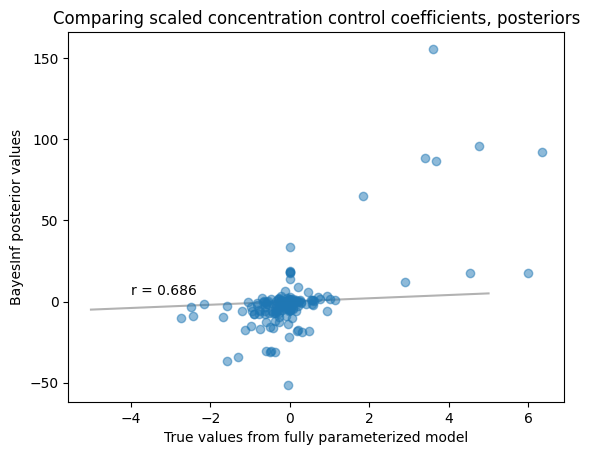

In [58]:
fig = plt.figure()

plt.scatter(gtCCC, postCCC, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled concentration control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-4,4,'r = ' + str((stats.pearsonr(gtCCC.to_numpy().flatten(), postCCC.to_numpy().flatten())[0]).round(3)))

Text(-1, 2, 'r = -0.453')

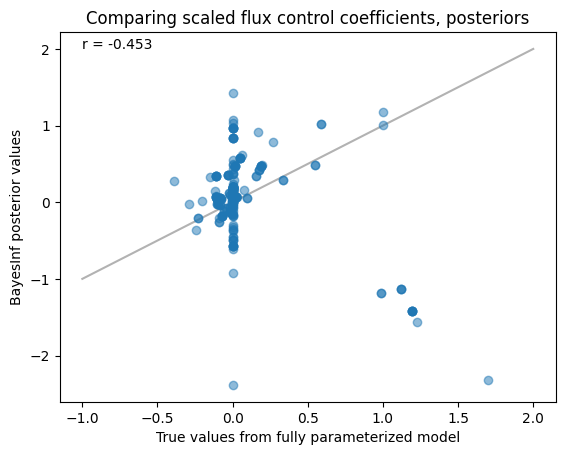

In [59]:
fig = plt.figure()

plt.scatter(gtFCC, postFCC, alpha=0.5)
plt.plot([-1,2], [-1,2], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-1,2,'r = ' + str((stats.pearsonr(gtFCC.to_numpy().flatten(), postFCC.to_numpy().flatten())[0]).round(3)))

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.



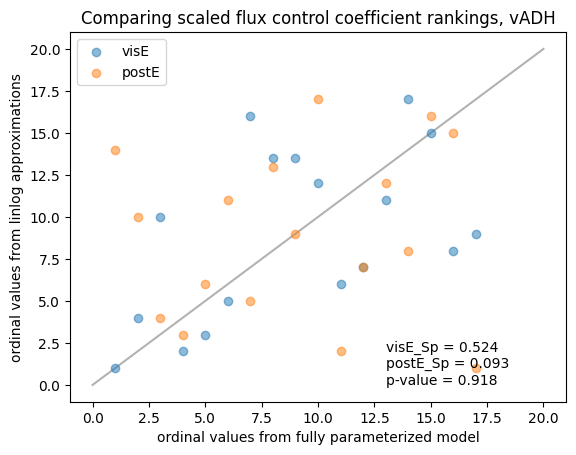

In [60]:
FCCrankings = pd.concat([gtFCC.loc['vADH'].rank(), visFCC.loc['vADH'].rank(), postFCC.loc['vADH'].rank()], axis=1)
FCCrankings.columns=['gt', 'visE', 'postE']

fig = plt.figure()

plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficient rankings, vADH')
plt.xlabel('ordinal values from fully parameterized model')
plt.ylabel('ordinal values from linlog approximations')

plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
plt.text(13,0,'p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))
plt.legend()

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.



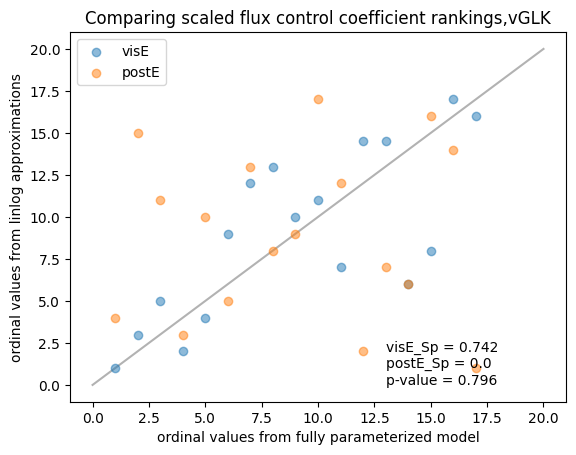

In [61]:
FCCrankings = pd.concat([gtFCC.loc['vGLK'].rank(), visFCC.loc['vGLK'].rank(), postFCC.loc['vGLK'].rank()], axis=1)
FCCrankings.columns=['gt', 'visE', 'postE']

fig = plt.figure()

plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficient rankings,vGLK')
plt.xlabel('ordinal values from fully parameterized model')
plt.ylabel('ordinal values from linlog approximations')

plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
plt.text(13,0,'p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))

plt.legend()

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.



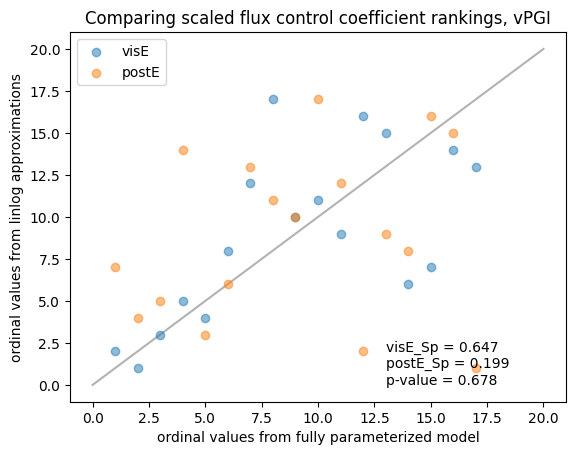

In [62]:
FCCrankings = pd.concat([gtFCC.loc['vPGI'].rank(), visFCC.loc['vPGI'].rank(), postFCC.loc['vPGI'].rank()], axis=1)
FCCrankings.columns=['gt', 'visE', 'postE']

fig = plt.figure()

plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficient rankings, vPGI')
plt.xlabel('ordinal values from fully parameterized model')
plt.ylabel('ordinal values from linlog approximations')

plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
plt.text(13,0,'p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))

plt.legend()

## Distribution of FCC Sp. correlation coefficients

In [63]:
visE_r=[]
postE_r=[]

for i in r.getReactionIds():        
    FCCrankings = pd.concat([gtFCC.loc[i].rank(), visFCC.loc[i].rank(), postFCC.loc[i].rank()], axis=1)
    FCCrankings.columns=['gt', 'visE', 'postE']

    visE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0])
    postE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0])


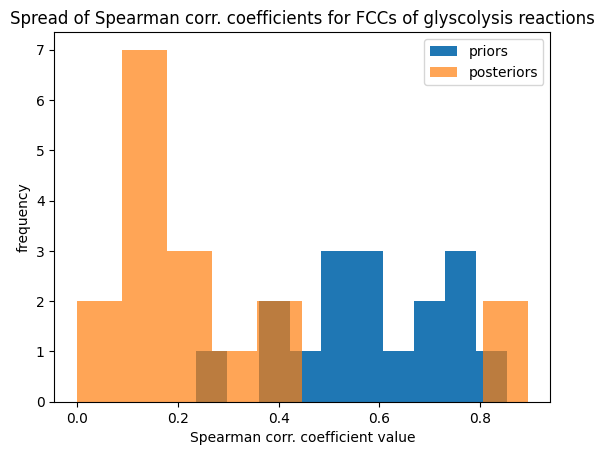

In [64]:
plt.hist(visE_r, label='priors')
plt.hist(postE_r, alpha=0.7, label='posteriors')
plt.legend()
plt.xlabel('Spearman corr. coefficient value')
plt.ylabel('frequency')
plt.title('Spread of Spearman corr. coefficients for FCCs of glyscolysis reactions')

plt.show()


# Solving for steady state concentrations using enzyme perturbation data

In [2]:
Teusink_ant ='data/interim/Antimony/BIOMD0000000064_e.ant' 
data_file = 'data/interim/generated_data/enzymeCompilation.csv'
df = pd.read_csv(data_file)
# need to fix this so only rows with concentrations less than 0 are dropped 
data = df.drop(df[df.lt(0).any(axis=1)].index) 

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

5.935978122618177e-12

In [3]:
BIOMD64 = BMCA.BMCA(Teusink_ant, data_file)

Model does not contain SBML fbc package information.


Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2023-10-19


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGAPDH>'
Missing upper flux bound set to '1

## Solving for steady state internal metabolite concentrations (X)

In [4]:
enzymes = [i for i in data.columns if 'e_' in i]

a = data[enzymes].apply(lambda row: row[row != 1].index, axis=1)
pt_enz = [i[0] for i in a[1:]]
pt_enz.insert(0, 'e_vPGK')

C:\Users\user\AppData\Local\Temp\ipykernel_8760\4088482062.py:4: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [5]:
a = data[data[enzymes] != 1].values.flatten()
# a = data[enzymes].values.flatten()
pt_lvls = a[~np.isnan(a)]
pt_lvls = list(pt_lvls)
pt_lvls.insert(0, 1.0)

# zip pt_enz and pt_lvls together and then assign them as the column names
enzPtLvls = [x +'|'+ str(y) for x, y in zip(pt_enz, pt_lvls)]

In [6]:
# get the real flux values
real_flux_values = data[[i for i in data.columns if 'v_' in i]]
rel_real_flux_values = real_flux_values.div(real_flux_values.iloc[0])
# rel_real_flux_values.drop(rel_real_flux_values.index[0], inplace=True)
rel_real_flux_values.columns = r.getReactionIds()
rel_real_flux_values = rel_real_flux_values.transpose()
rel_real_flux_values.columns = enzPtLvls

In [7]:
# get the real inmet values
real_inmet_values = data[[i for i in data.columns if i in r.getFloatingSpeciesIds()]]
rel_real_inmet_values = real_inmet_values.div(real_inmet_values.iloc[0])
# rel_real_inmet_values.drop(rel_real_inmet_values.index[0], inplace=True)
rel_real_inmet_values = rel_real_inmet_values.transpose()
rel_real_inmet_values.columns = enzPtLvls
rel_real_inmet_values

e_vPGK|1.0  e_vGLK|0.9  e_vGLK|1.1  e_vPGI|0.9  e_vPGI|1.1  \
P            1.0    0.981102    1.012340    0.999760    1.000185   
G6P          1.0    0.915856    1.062600    1.095768    0.926054   
TRIO         1.0    0.964675    1.024681    0.999533    1.000361   
NAD          1.0    0.999887    1.000075    0.999999    1.000001   
ACE          1.0    0.988426    1.007765    0.999851    1.000115   
P2G          1.0    0.931656    1.050402    0.999068    1.000721   
BPG          1.0    0.884451    1.088375    0.998389    1.001244   
GLCi         1.0    1.275019    0.822960    1.003465    0.997325   
F6P          1.0    0.889588    1.082729    0.998479    1.001177   
PEP          1.0    0.912582    1.065984    0.998792    1.000935   
PYR          1.0    0.945724    1.039756    0.999263    1.000570   
F16P         1.0    0.932066    1.048850    0.999087    1.000706   
P3G          1.0    0.936616    1.046442    0.999139    1.000666   
NADH         1.0    1.003918    0.997385    1.000050    0.999961   

      e_vGLYCO|0.9  e_vGLYCO|1.1  e_vTreha|0.9  e_vTreha|1.1  e_vPFK|0.9  \
P         1.016028      0.983496      1.011134      0.988638    0.999814   
G6P       1.060964      0.944343      1.043482      0.959234    1.074261   
TRIO      1.019700      0.981049      1.014680      0.985711    0.999638   
NAD       1.000071      0.999931      1.000052      0.999949    0.999999   
ACE       1.005985      0.994055      1.004513      0.995505    0.999884   
P2G       1.043488      0.959794      1.031735      0.969992    0.999277   
BPG       1.094467      0.915913      1.066104      0.939124    0.998750   
GLCi      0.971681      1.030843      0.980221      1.020988    1.002687   
F6P       1.086807      0.921304      1.061102      0.942995    1.123996   
PEP       1.064690      0.941533      1.046002      0.957185    0.999063   
PYR       1.026599      0.974265      1.020568      0.980019    0.999428   
F16P      1.037958      0.964015      1.028371      0.972702    0.999292   
P3G       1.039000      0.963712      1.028632      0.972806    0.999332   
NADH      0.997514      1.002408      0.998204      1.001762    1.000039   

      e_vPFK|1.1  e_vALD|0.9  e_vALD|1.1  e_vGAPDH|0.9  e_vGAPDH|1.1  \
P       1.000140    0.999962    1.000030      0.990269      1.008725   
G6P     0.944260    1.015330    0.988048      1.023501      0.983821   
TRIO    1.000272    0.999925    1.000058      1.109371      0.913130   
NAD     1.000001    1.000000    1.000000      1.000711      0.999320   
ACE     1.000087    0.999976    1.000019      1.023951      0.978139   
P2G     1.000543    0.999851    1.000116      0.978715      1.020216   
BPG     1.000938    0.999742    1.000200      0.951653      1.046921   
GLCi    0.997983    1.000555    0.999568      1.019794      0.982896   
F6P     0.906949    1.025595    0.980047      1.041463      0.971095   
PEP     1.000705    0.999806    1.000151      0.967394      1.031373   
PYR     1.000430    0.999882    1.000092      0.987900      1.011103   
F16P    1.000532    1.060552    0.953532      1.187275      0.864676   
P3G     1.000502    0.999862    1.000108      0.981025      1.017955   
NADH    0.999971    1.000008    0.999994      0.975267      1.023632   

      e_vPGK|0.9  e_vPGK|1.1  e_vPGM|0.9  e_vPGM|1.1  e_vENO|0.9  e_vENO|1.1  \
P       0.999709    1.000239    0.999761    1.000194    0.999313    1.000506   
G6P     1.000617    0.999498    1.000505    0.999592    1.001464    0.998939   
TRIO    1.003071    0.997492    1.002517    0.997958    1.007270    0.994686   
NAD     1.000022    0.999982    1.000018    0.999985    1.000052    0.999962   
ACE     1.000723    0.999407    1.000593    0.999517    1.001707    0.998741   
P2G     0.999345    1.000538    0.999462    1.000438    1.141534    0.897163   
BPG     1.037573    0.969339    1.030797    0.975037    1.088997    0.935059   
GLCi    1.000581    0.999524    1.000476    0.999613    1.001373    0.998991   
F6P     1.001094    0.999110    1.000897   

In [8]:
# get the real exmet values
real_exmet_values = data[[i for i in data.columns if i in r.getBoundarySpeciesIds()]]
rel_real_exmet_values = real_exmet_values.div(real_exmet_values.iloc[0])
# rel_real_exmet_values.drop(rel_real_exmet_values.index[0], inplace=True)
rel_real_exmet_values = rel_real_exmet_values.transpose()
rel_real_exmet_values.columns = enzPtLvls
rel_real_exmet_values

e_vPGK|1.0  e_vGLK|0.9  e_vGLK|1.1  e_vPGI|0.9  e_vPGI|1.1  \
CO2           1.0         1.0         1.0         1.0         1.0   
GLCo          1.0         1.0         1.0         1.0         1.0   
ETOH          1.0         1.0         1.0         1.0         1.0   
GLY           1.0         1.0         1.0         1.0         1.0   
F26BP         1.0         1.0         1.0         1.0         1.0   

       e_vGLYCO|0.9  e_vGLYCO|1.1  e_vTreha|0.9  e_vTreha|1.1  e_vPFK|0.9  \
CO2             1.0           1.0           1.0           1.0         1.0   
GLCo            1.0           1.0           1.0           1.0         1.0   
ETOH            1.0           1.0           1.0           1.0         1.0   
GLY             1.0           1.0           1.0           1.0         1.0   
F26BP           1.0           1.0           1.0           1.0         1.0   

       e_vPFK|1.1  e_vALD|0.9  e_vALD|1.1  e_vGAPDH|0.9  e_vGAPDH|1.1  \
CO2           1.0         1.0         1.0           1.0           1.0   
GLCo          1.0         1.0         1.0           1.0           1.0   
ETOH          1.0         1.0         1.0           1.0           1.0   
GLY           1.0         1.0         1.0           1.0           1.0   
F26BP         1.0         1.0         1.0           1.0           1.0   

       e_vPGK|0.9  e_vPGK|1.1  e_vPGM|0.9  e_vPGM|1.1  e_vENO|0.9  e_vENO|1.1  \
CO2           1.0         1.0         1.0         1.0         1.0         1.0   
GLCo          1.0         1.0         1.0         1.0         1.0         1.0   
ETOH          1.0         1.0         1.0         1.0         1.0         1.0   
GLY           1.0         1.0         1.0         1.0         1.0         1.0   
F26BP         1.0         1.0         1.0         1.0         1.0         1.0   

       e_vPYK|0.9  e_vPYK|1.1  e_vPDC|0.9  e_vPDC|1.1  e_vSUC|0.9  e_vSUC|1.1  \
CO2           1.0         1.0         1.0         1.0         1.0         1.0   
GLCo          1.0         1.0         1.0         1.0         1.0         1.0   
ETOH          1.0         1.0         1.0         1.0         1.0         1.0   
GLY           1.0         1.0         1.0         1.0         1.0         1.0   
F26BP         1.0         1.0         1.0         1.0         1.0         1.0   

       e_vGLT|0.9  e_vGLT|1.1  e_vADH|0.9  e_vADH|1.1  e_vG3PDH|0.9  \
CO2           1.0         1.0         1.0         1.0           1.0   
GLCo          1.0         1.0         1.0         1.0           1.0   
ETOH          1.0         1.0         1.0         1.0           1.0   
GLY           1.0         1.0         1.0         1.0           1.0   
F26BP         1.0         1.0         1.0         1.0           1.0   

       e_vG3PDH|1.1  e_vATP|0.9  e_vATP|1.1  e_vGLK|0.887  e_vGLK|1.113  \
CO2             1.0         1.0         1.0           1.0           1.0   
GLCo            1.0         1.0         1.0           1.0           1.0   
ETOH            1.0         1.0         1.0           1.0           1.0   
GLY             1.0         1.0         1.0           1.0           1.0   
F26BP           1.0         1.0         1.0           1.0           1.0   

       e_vPGI|0.887  e_vPGI|1.113  e_vGLYCO|0.887  e_vGLYCO|1.113  \
CO2             1.0           1.0             1.0             1.0   
GLCo            1.0           1.0             1.0             1.0   
ETOH            1.0           1.0             1.0             1.0   
GLY             1.0           1.0             1.0             1.0   
F26BP           1.0           1.0             1.0             1.0   

       e_vTreha|0.887  e_vTreha|1.113  e_vPFK|0.887  e_vPFK|1.113  \
CO2               1.0             1.0           1.0           1.0   
GLCo              1.0             1.0           1.0           1.0   
ETOH              1.0             1.0           1.0           1.0   
GLY               1.0             1.0           1.0           1.0   
F26BP             1.0             1.0           1.0           1.0   

       e

Setting up approximation calculation with simulated values

In [9]:
N = BIOMD64.N
Ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
Ey = np.array(c).reshape((len(b),len(a)))


In [11]:
pt_lvls = list(set([i.split('|')[1] for i in rel_real_flux_values.columns]))
pt_lvls.sort()

In [12]:
enzyme_perts = data[[i for i in data.columns if 'e_' in i]]
enzyme_perts = enzyme_perts.transpose()
enzyme_perts.columns = enzPtLvls
enzyme_perts

e_vPGK|1.0  e_vGLK|0.9  e_vGLK|1.1  e_vPGI|0.9  e_vPGI|1.1  \
e_vGLK           1.0         0.9         1.1         1.0         1.0   
e_vPGI           1.0         1.0         1.0         0.9         1.1   
e_vGLYCO         1.0         1.0         1.0         1.0         1.0   
e_vTreha         1.0         1.0         1.0         1.0         1.0   
e_vPFK           1.0         1.0         1.0         1.0         1.0   
e_vALD           1.0         1.0         1.0         1.0         1.0   
e_vGAPDH         1.0         1.0         1.0         1.0         1.0   
e_vPGK           1.0         1.0         1.0         1.0         1.0   
e_vPGM           1.0         1.0         1.0         1.0         1.0   
e_vENO           1.0         1.0         1.0         1.0         1.0   
e_vPYK           1.0         1.0         1.0         1.0         1.0   
e_vPDC           1.0         1.0         1.0         1.0         1.0   
e_vSUC           1.0         1.0         1.0         1.0         1.0   
e_vGLT           1.0         1.0         1.0         1.0         1.0   
e_vADH           1.0         1.0         1.0         1.0         1.0   
e_vG3PDH         1.0         1.0         1.0         1.0         1.0   
e_vATP           1.0         1.0         1.0         1.0         1.0   

          e_vGLYCO|0.9  e_vGLYCO|1.1  e_vTreha|0.9  e_vTreha|1.1  e_vPFK|0.9  \
e_vGLK             1.0           1.0           1.0           1.0         1.0   
e_vPGI             1.0           1.0           1.0           1.0         1.0   
e_vGLYCO           0.9           1.1           1.0           1.0         1.0   
e_vTreha           1.0           1.0           0.9           1.1         1.0   
e_vPFK             1.0           1.0           1.0           1.0         0.9   
e_vALD             1.0           1.0           1.0           1.0         1.0   
e_vGAPDH           1.0           1.0           1.0           1.0         1.0   
e_vPGK             1.0           1.0           1.0           1.0         1.0   
e_vPGM             1.0           1.0           1.0           1.0         1.0   
e_vENO             1.0           1.0           1.0           1.0         1.0   
e_vPYK             1.0           1.0           1.0           1.0         1.0   
e_vPDC             1.0           1.0           1.0           1.0         1.0   
e_vSUC             1.0           1.0           1.0           1.0         1.0   
e_vGLT             1.0           1.0           1.0           1.0         1.0   
e_vADH             1.0           1.0           1.0           1.0         1.0   
e_vG3PDH           1.0           1.0           1.0           1.0         1.0   
e_vATP             1.0           1.0           1.0           1.0         1.0   

          e_vPFK|1.1  e_vALD|0.9  e_vALD|1.1  e_vGAPDH|0.9  e_vGAPDH|1.1  \
e_vGLK           1.0         1.0         1.0           1.0           1.0   
e_vPGI           1.0         1.0         1.0           1.0           1.0   
e_vGLYCO         1.0         1.0         1.0           1.0           1.0   
e_vTreha         1.0         1.0         1.0           1.0           1.0   
e_vPFK           1.1         1.0         1.0           1.0           1.0   
e_vALD           1.0         0.9         1.1           1.0           1.0   
e_vGAPDH         1.0         1.0         1.0           0.9           1.1   
e_vPGK           1.0         1.0         1.0           1.0           1.0   
e_vPGM           1.0         1.0         1.0           1.0           1.0   
e_vENO           1.0         1.0         1.0           1.0           1.0   
e_vPYK           1.0         1.0         1.0           1.0           1.0   
e_vPDC           1.0         1.0         1.0           1.0           1.0   
e_vSUC           1.0         1.0         1.0           1.0           1.0   
e_vGLT           1.0         1.0         1.0           1.0           1.0   
e_vADH           1.0         1.0         1.0           1.0           1.0   
e_vG3PDH         1.0         1.0         1.0           1

In [13]:
# data for graphing
x_data = data[r.getBoundarySpeciesIds()]
x_star = x_data.iloc[0].values
x_star[x_star == 0] = 1e-6
xn = x_data.divide(x_star)

y_data = data[r.getBoundarySpeciesIds()]
y_star = y_data.iloc[0].values
y_star[y_star == 0] = 1e-6
yn = y_data.divide(y_star)

In [14]:
n_exp = len(data)

e_hast = enzyme_perts.values# [:,:]
e_hat = e_hat.T # np.transpose(e_hat, axes=[1,0])
# e_hat = e_hat[:,:]
print(e_hat.shape)

v_star = BIOMD64.v_star[np.newaxis,:]
print(v_star.shape)

product = (e_hat*v_star)
print(product.shape)

# product[0, :]

def my_func(a): 
    return np.diag(a)

c = np.apply_along_axis(my_func, 1, product)
c.shape

N_rep = N.reshape((-1, *N.shape)).repeat(642, axis=0) # (642, 14, 17)

A = (N_rep@c@Ex) # (642, 14, 14)
arr = ((np.ones((len(N.T),n_exp)) + (Ey @ np.log(yn.T)))).values
arr = arr.T[:,:, np.newaxis]
b = -(N_rep@c) @ arr # (642, 14, 642)

Xss = []
for i in range(n_exp): 
    Xss.append(np.linalg.pinv(A[i])@b[i])


(642, 17)
(1, 17)
(642, 17)


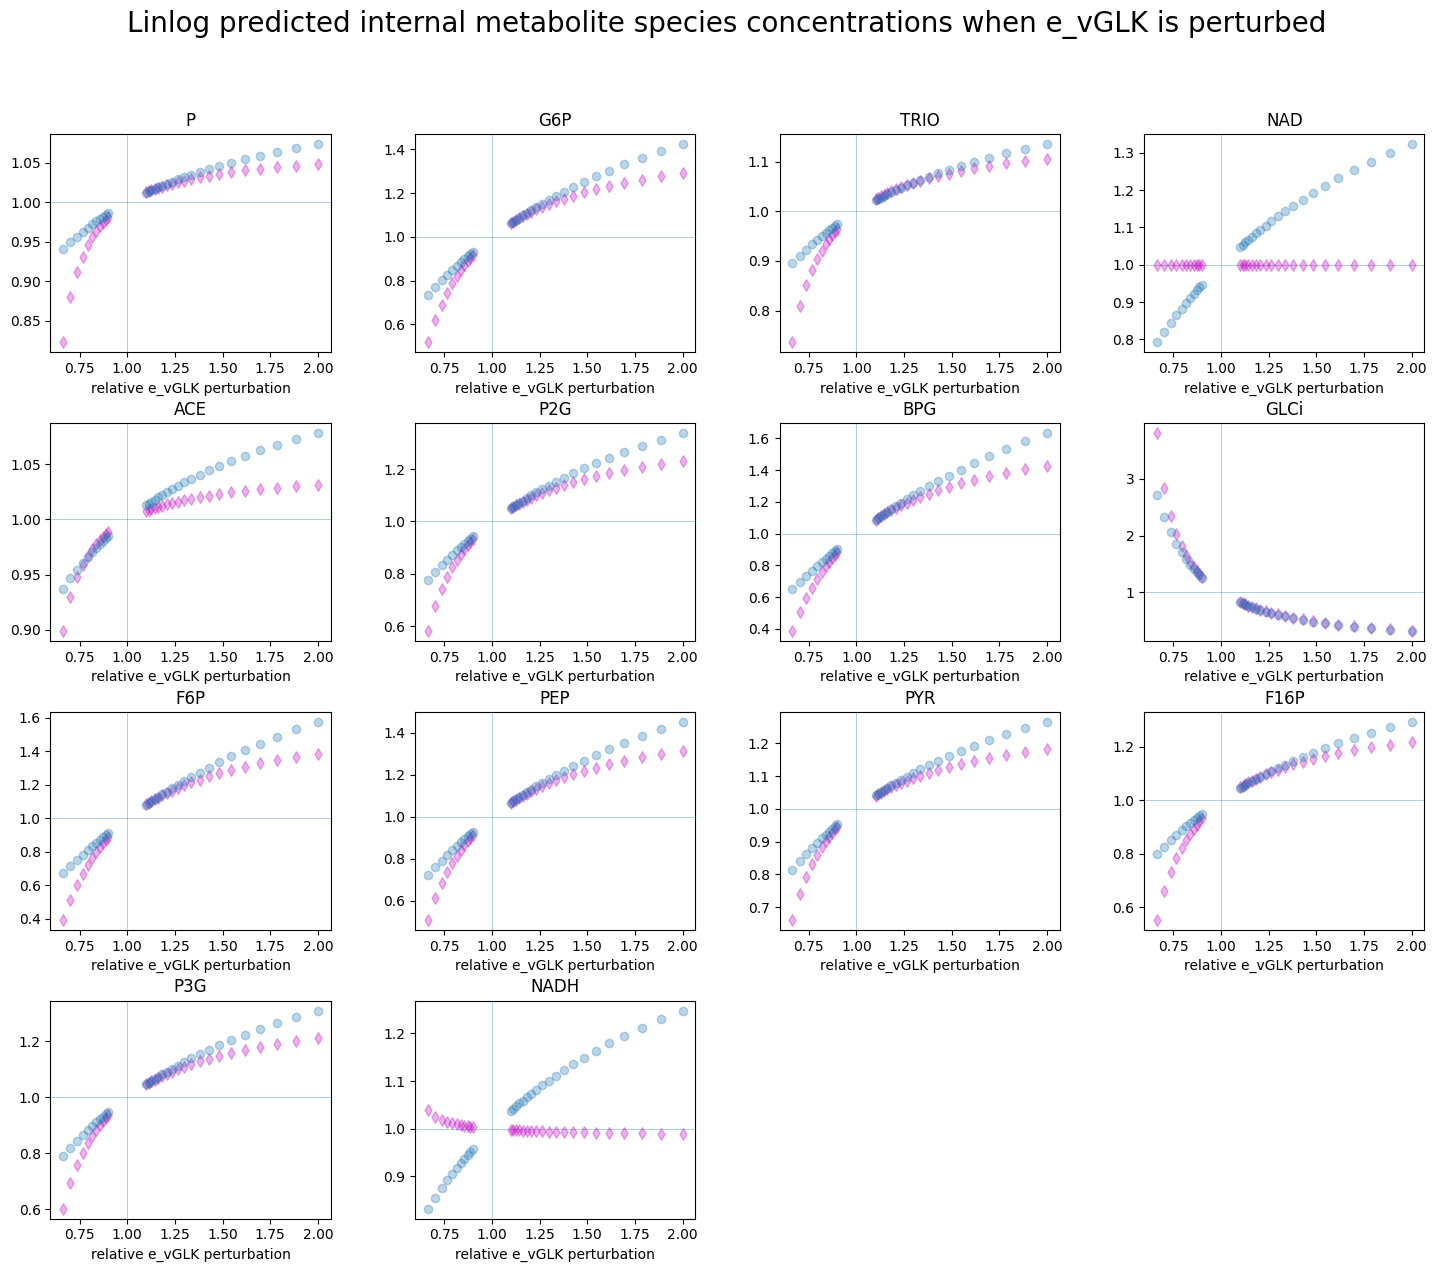

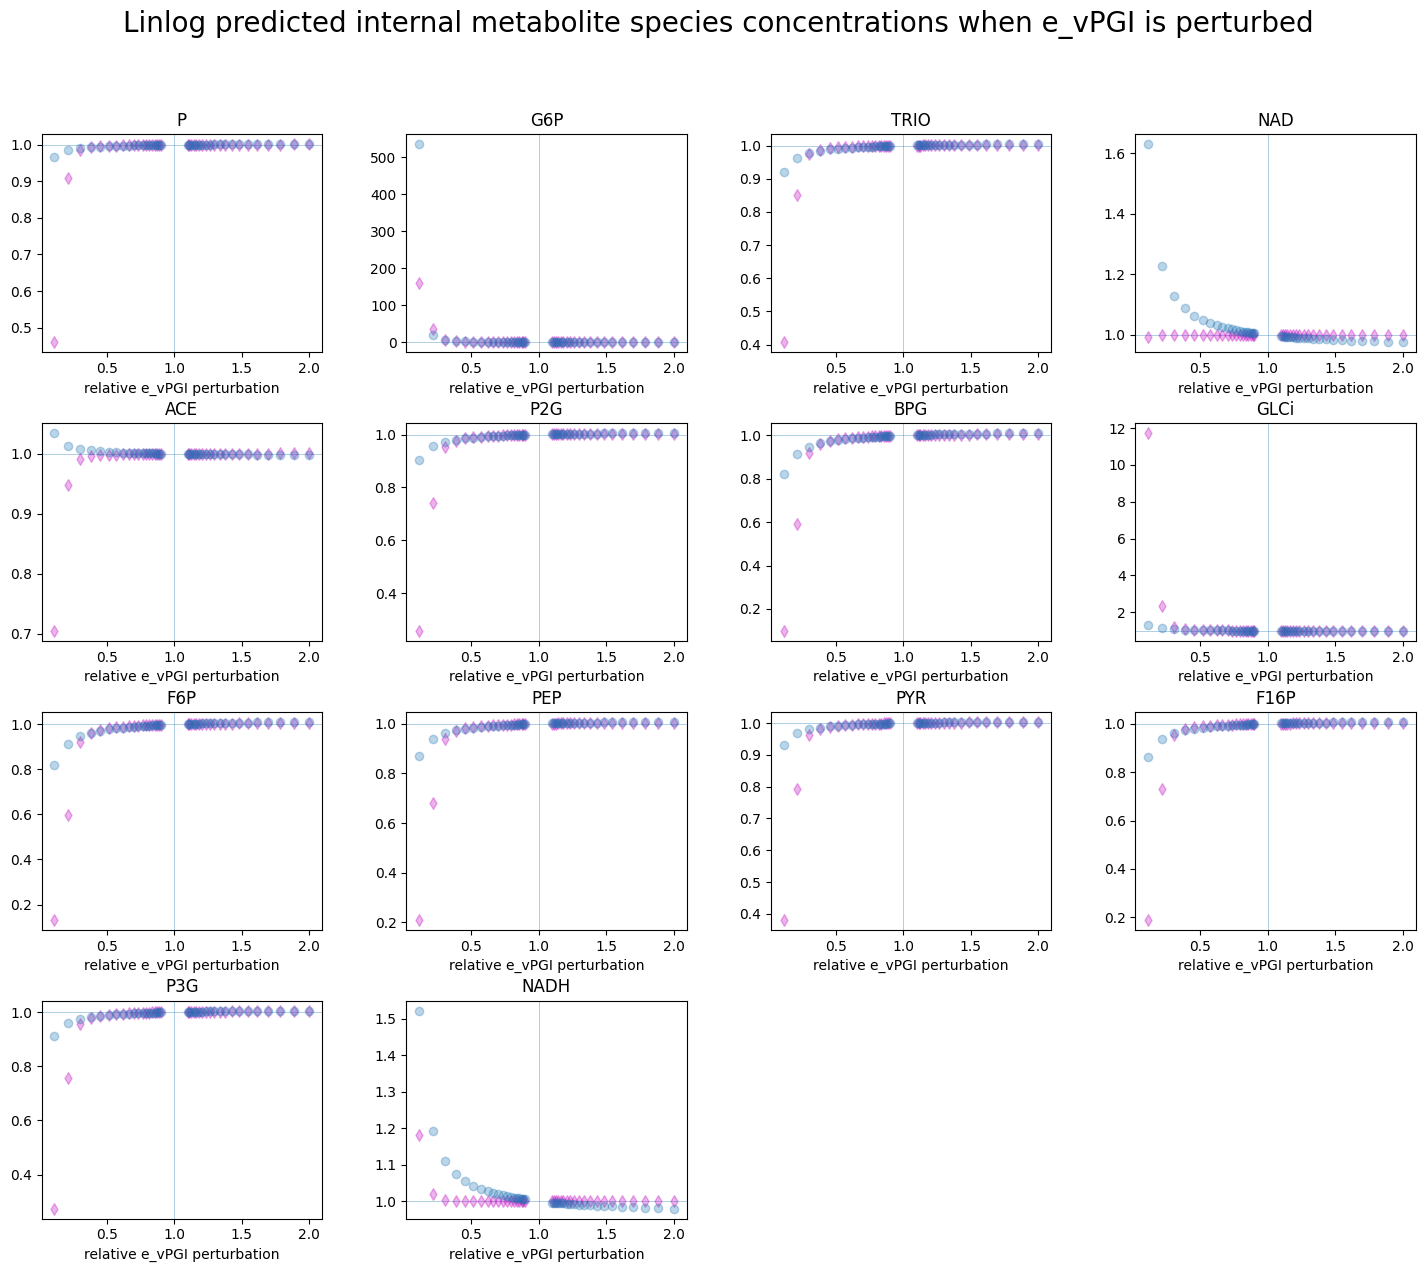

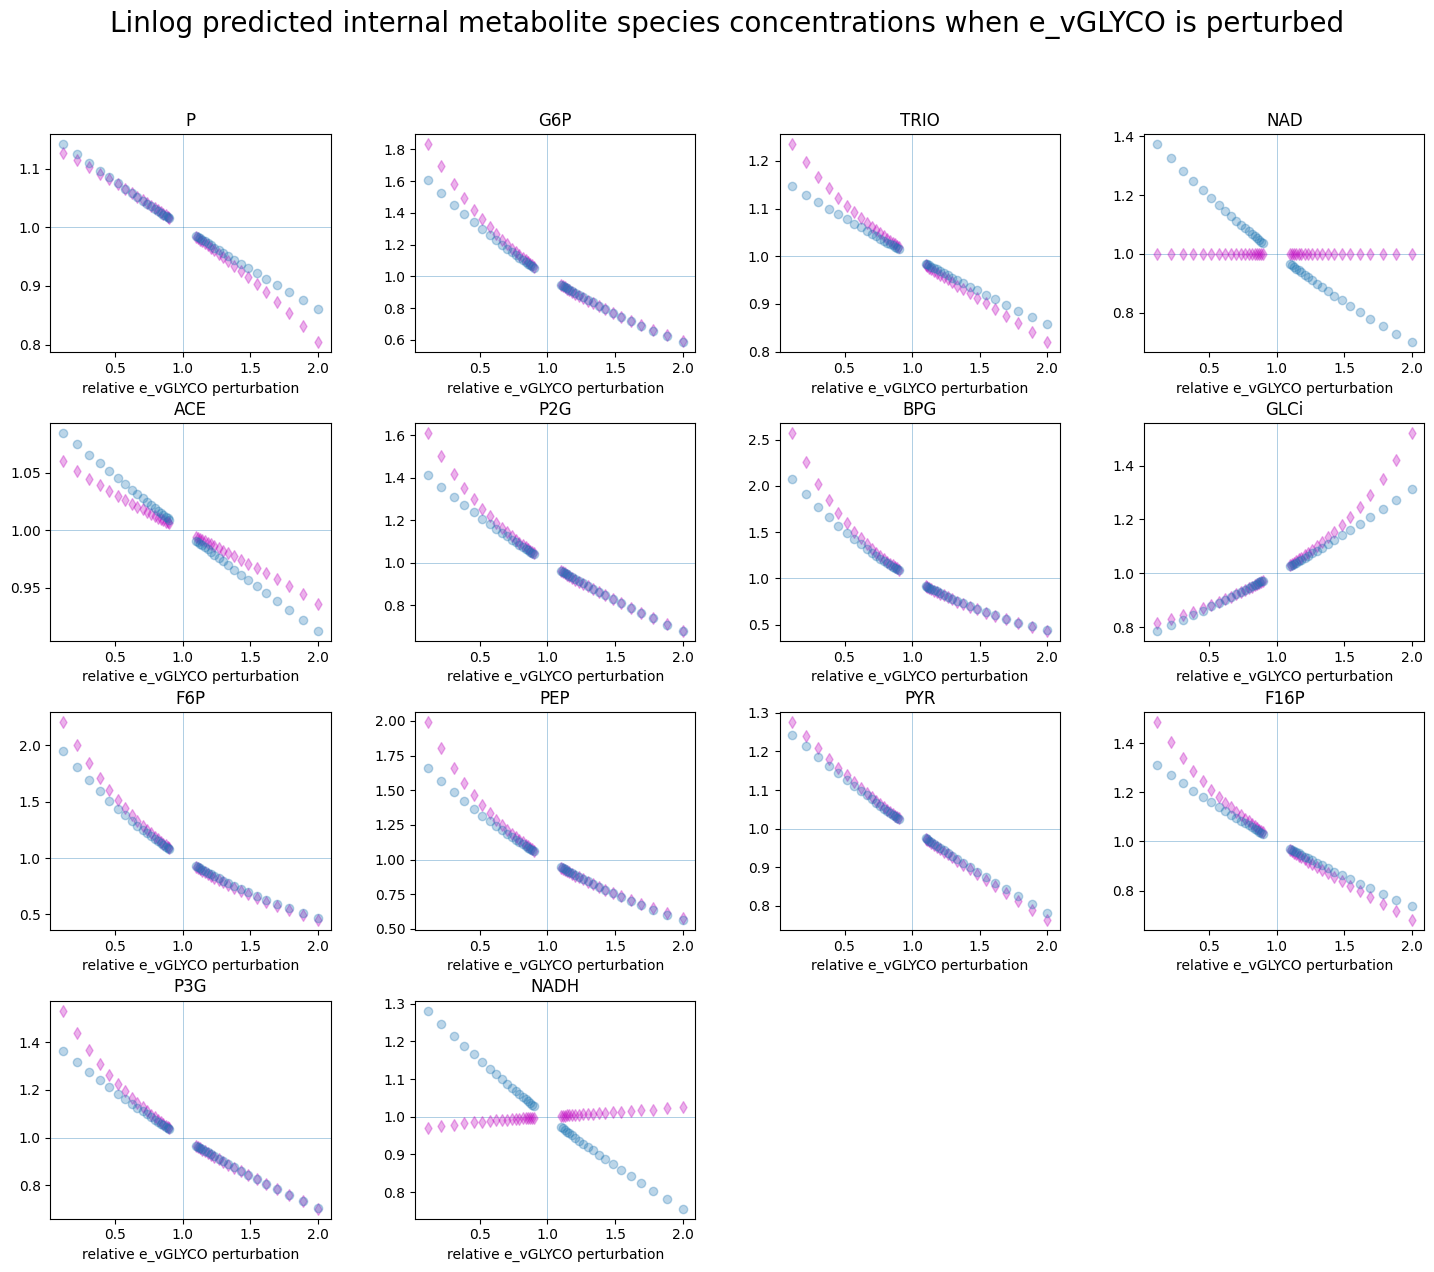

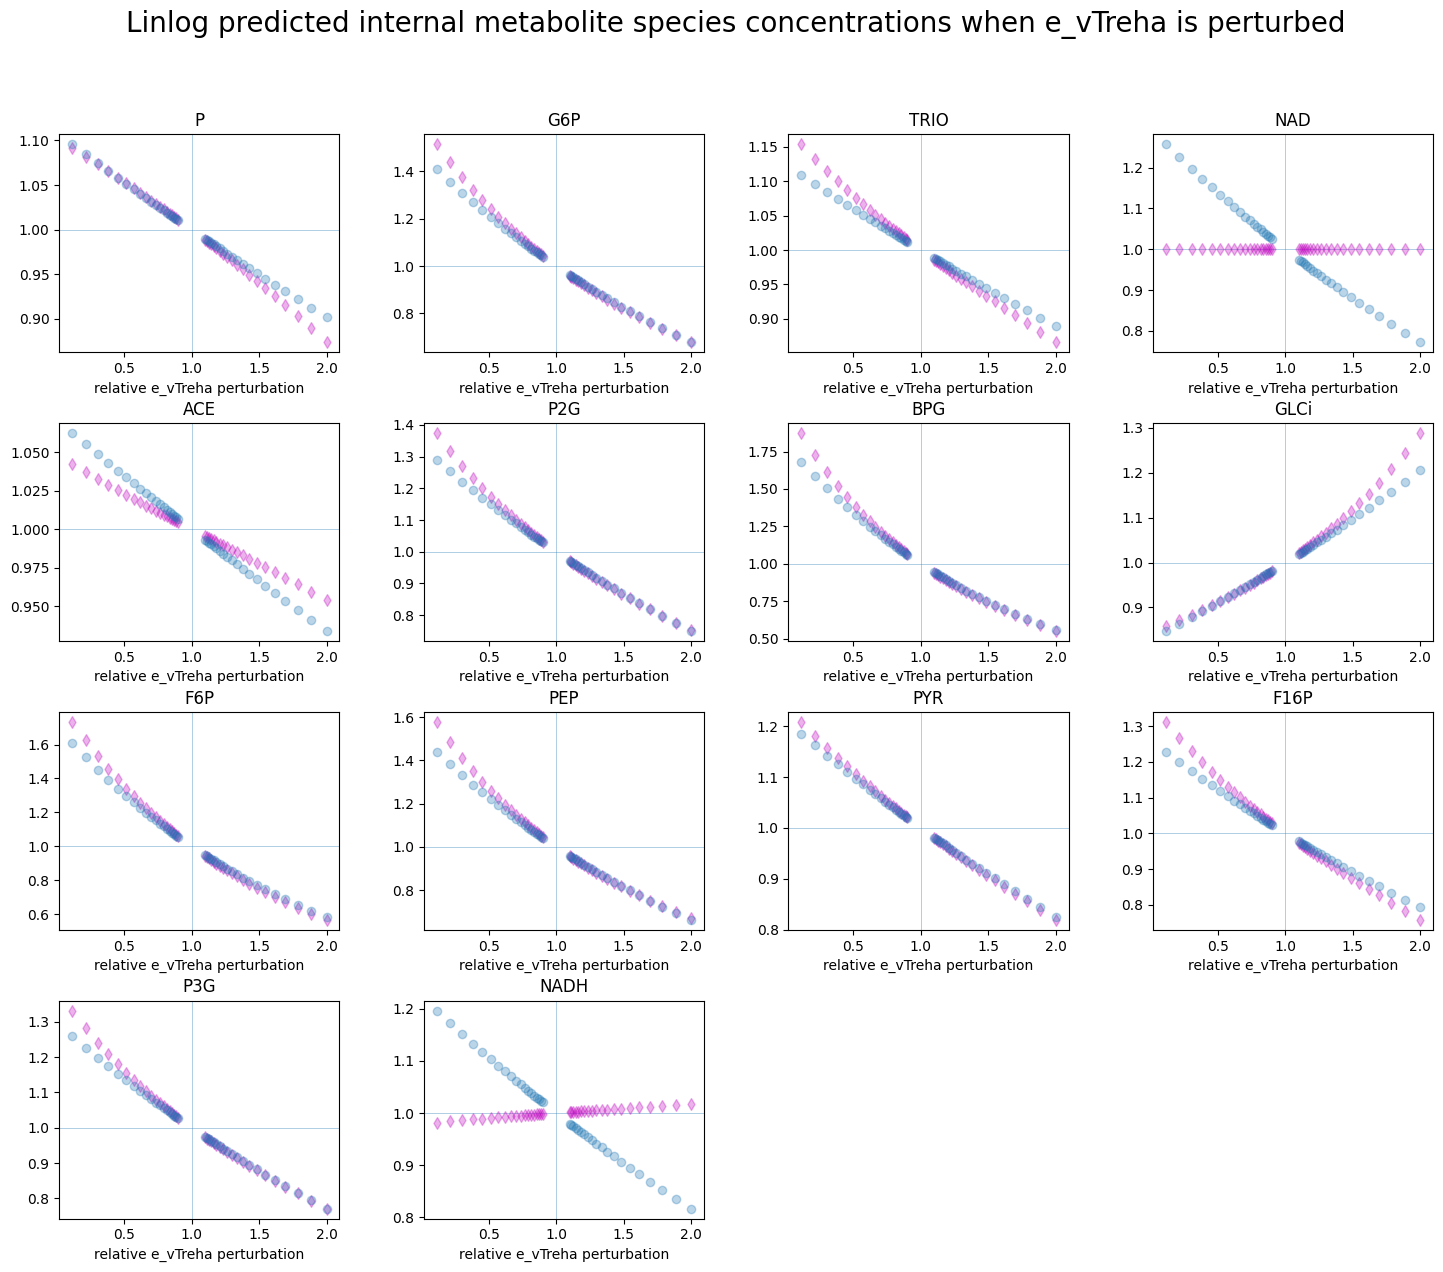

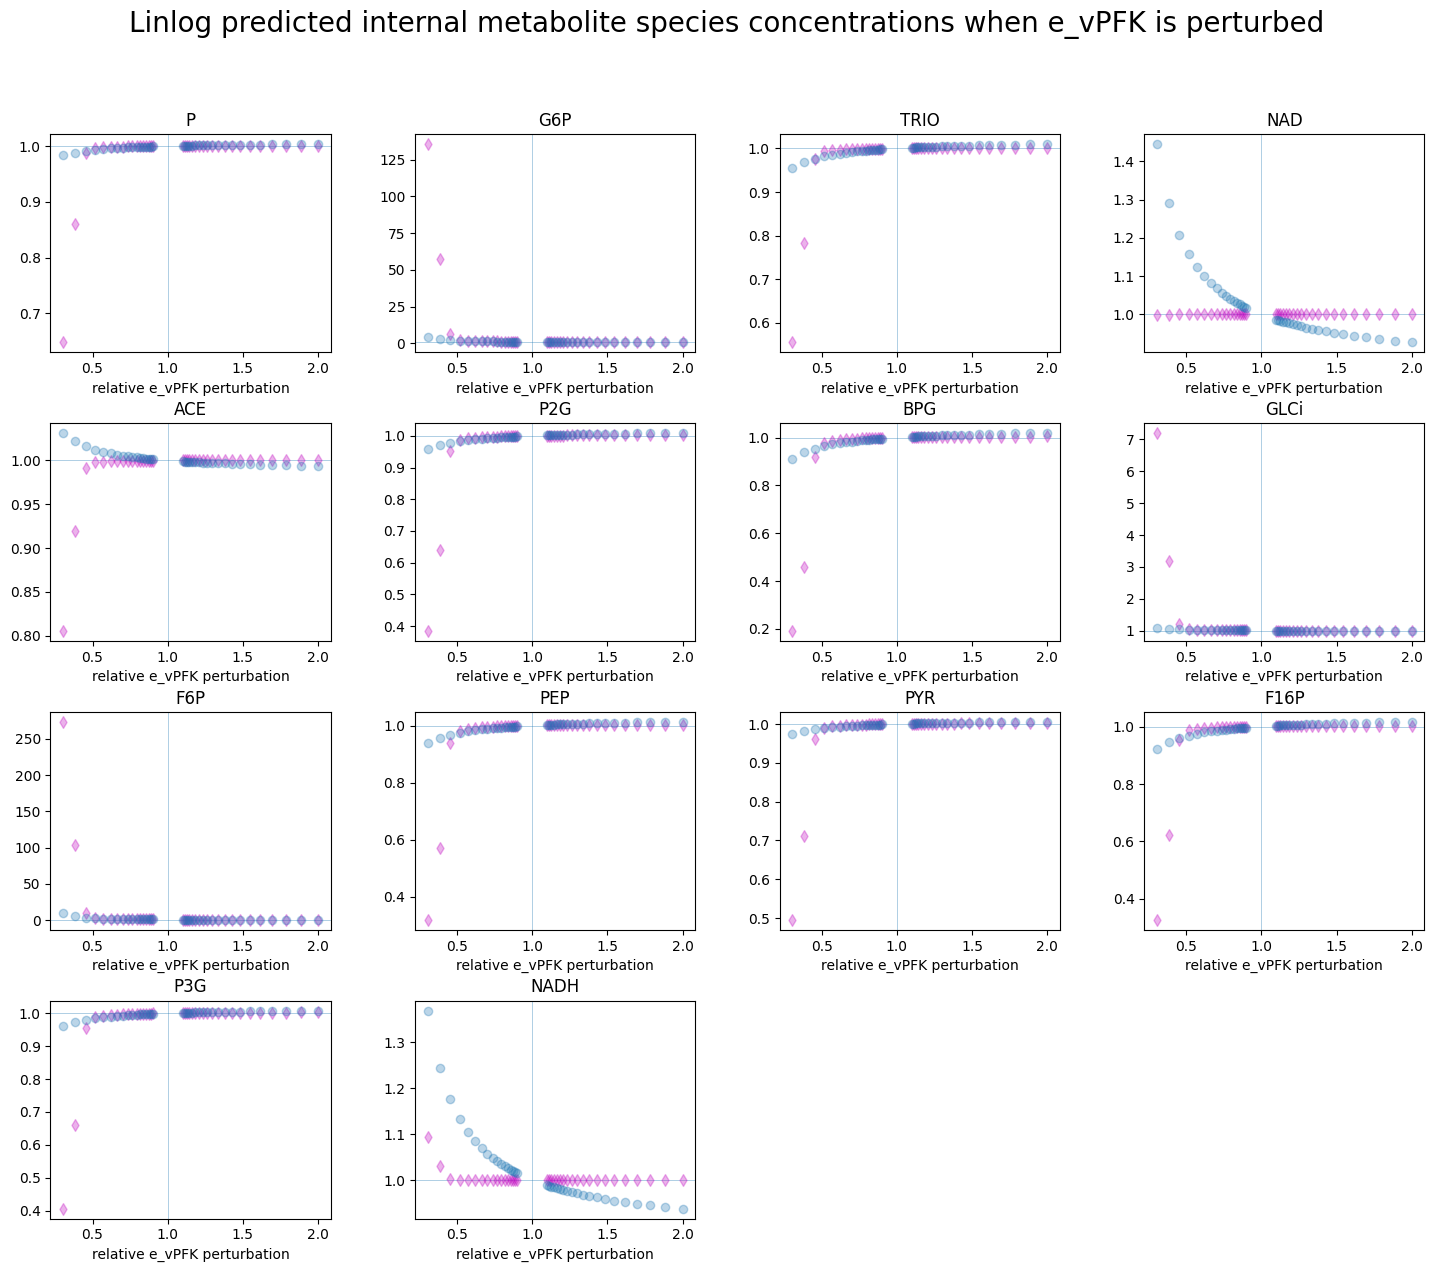

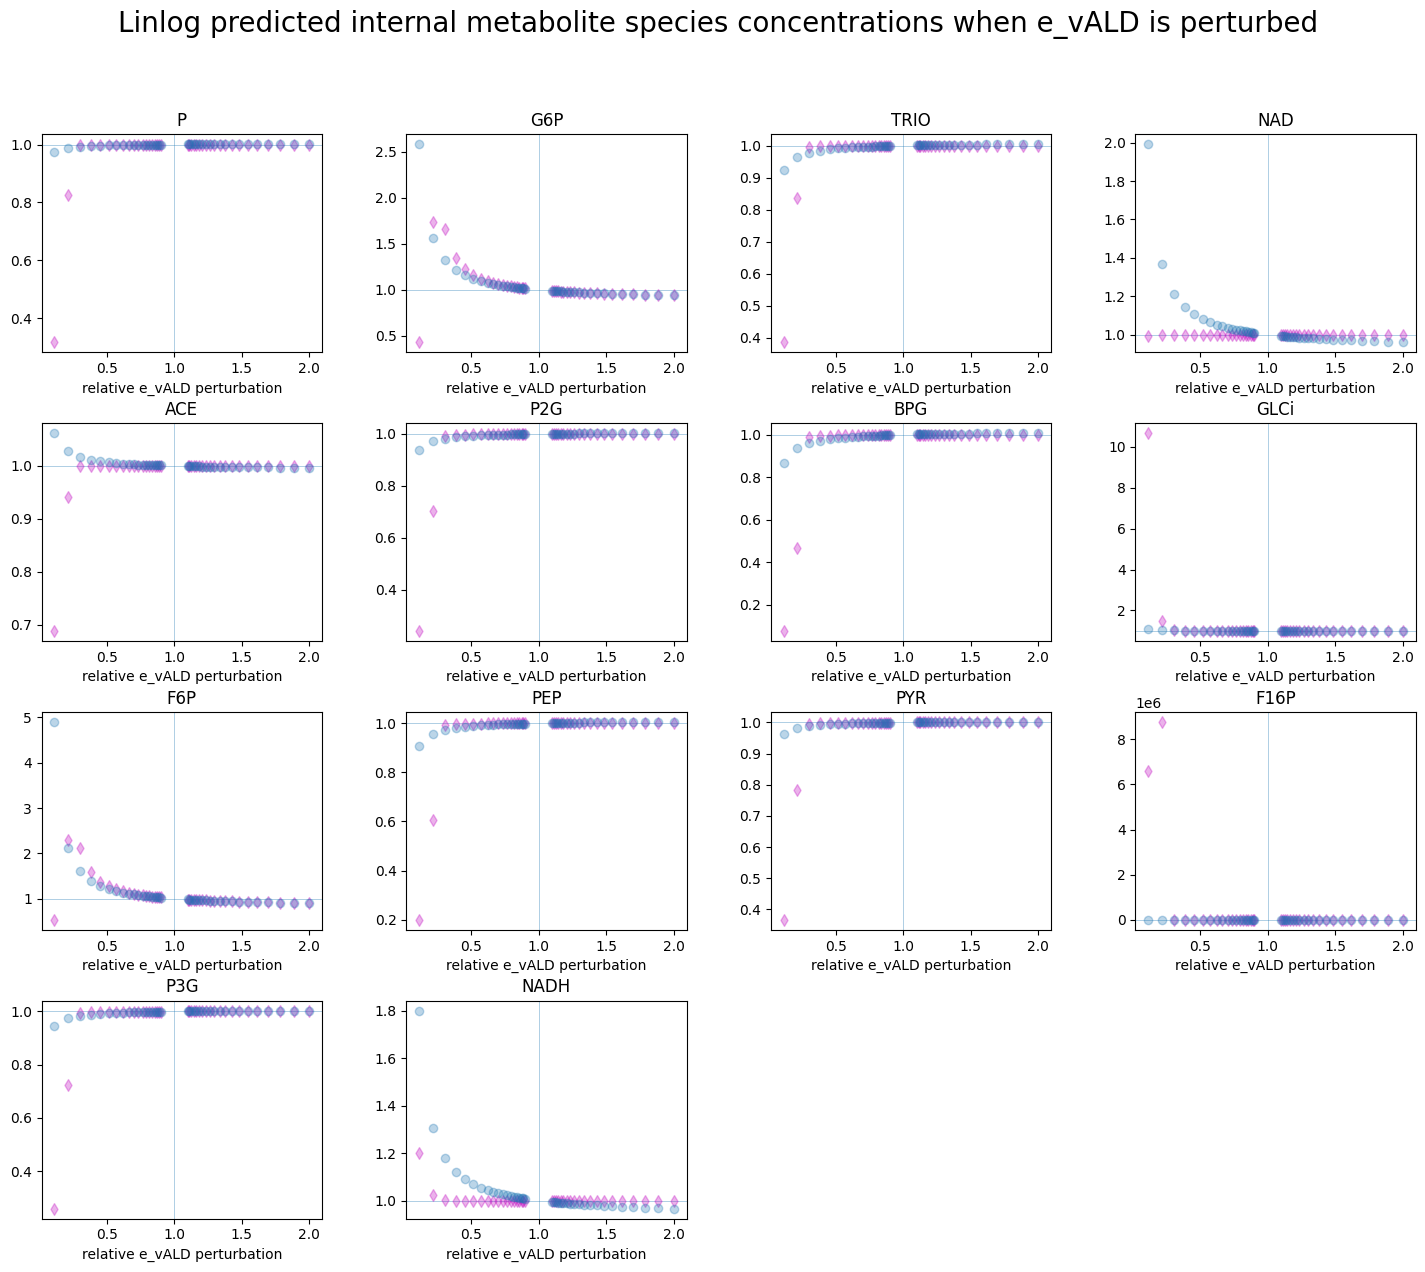

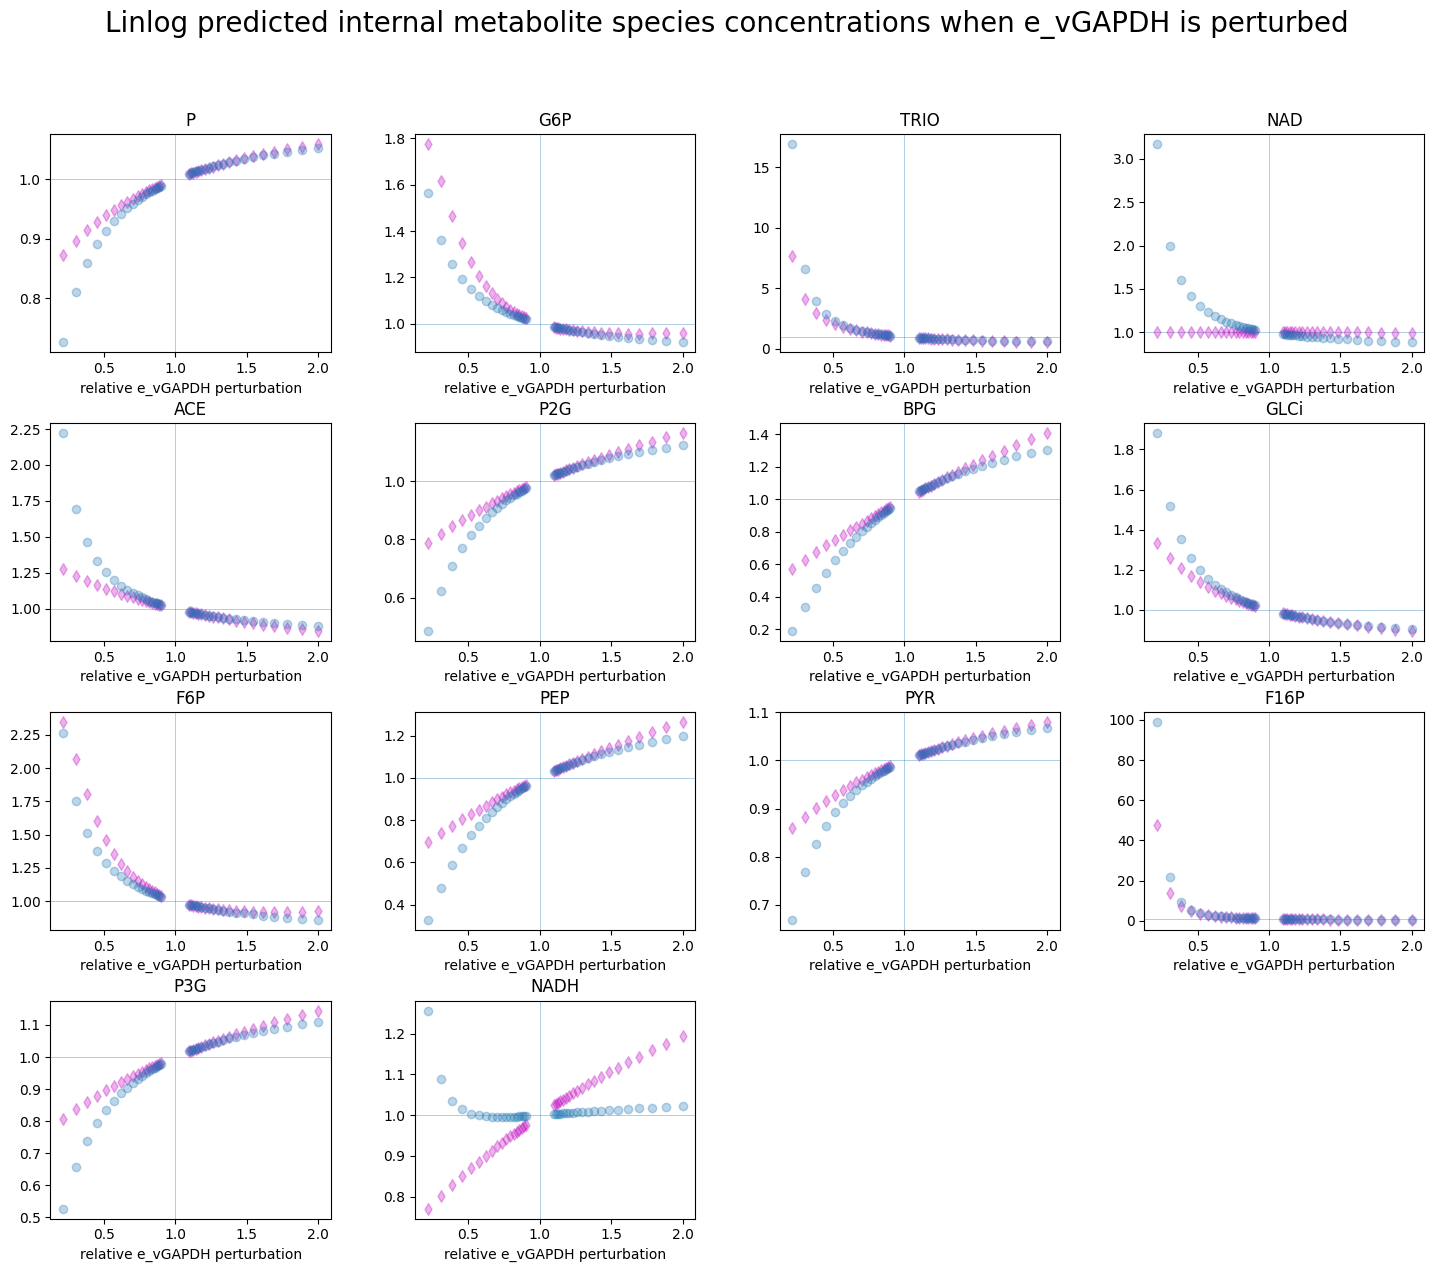

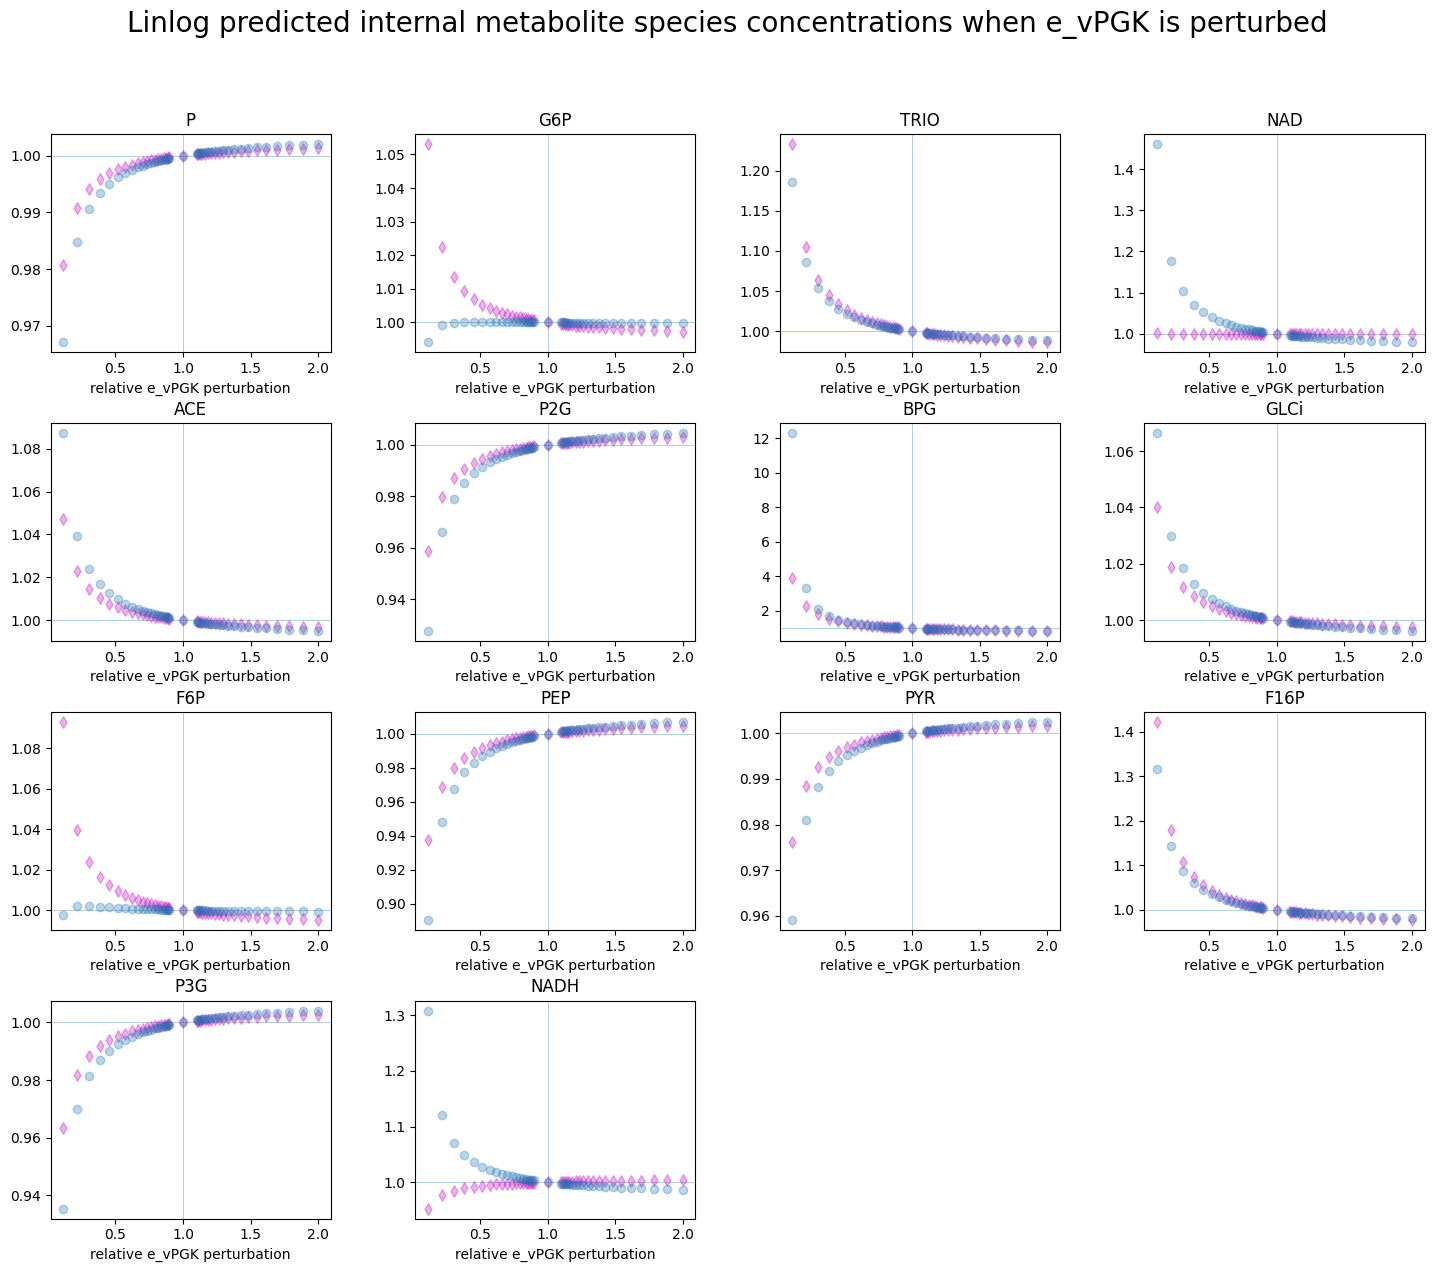

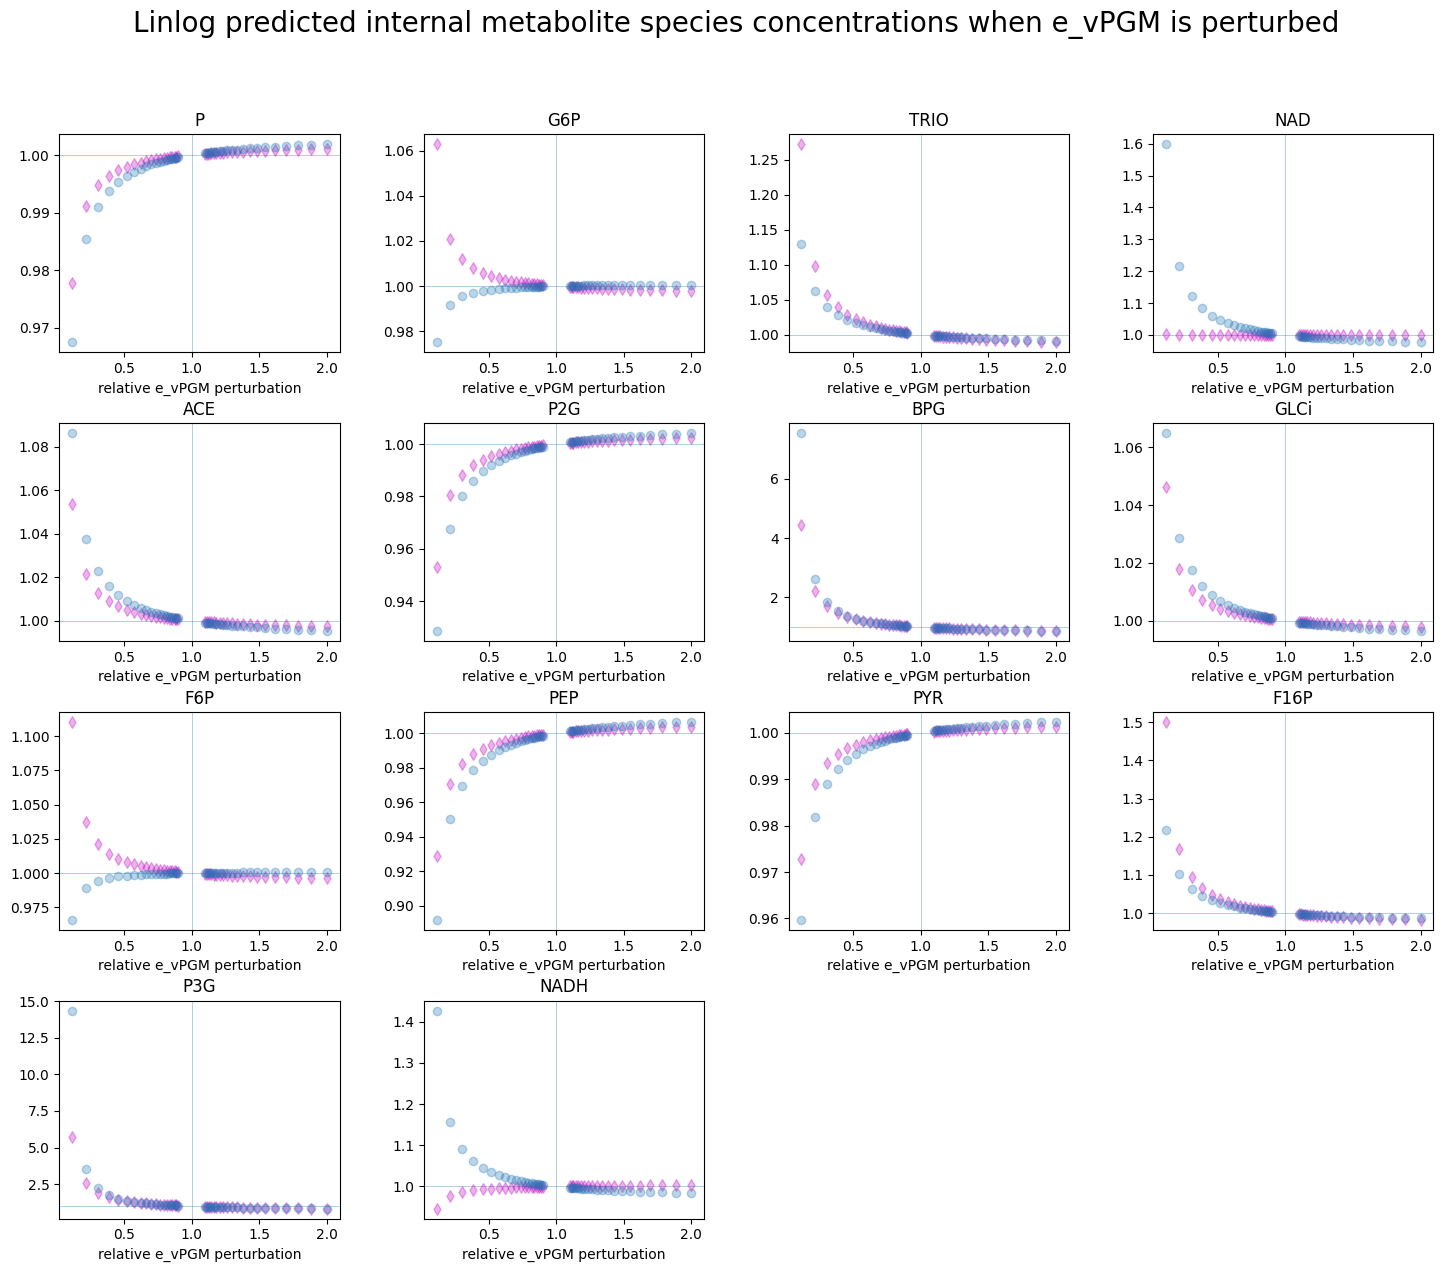

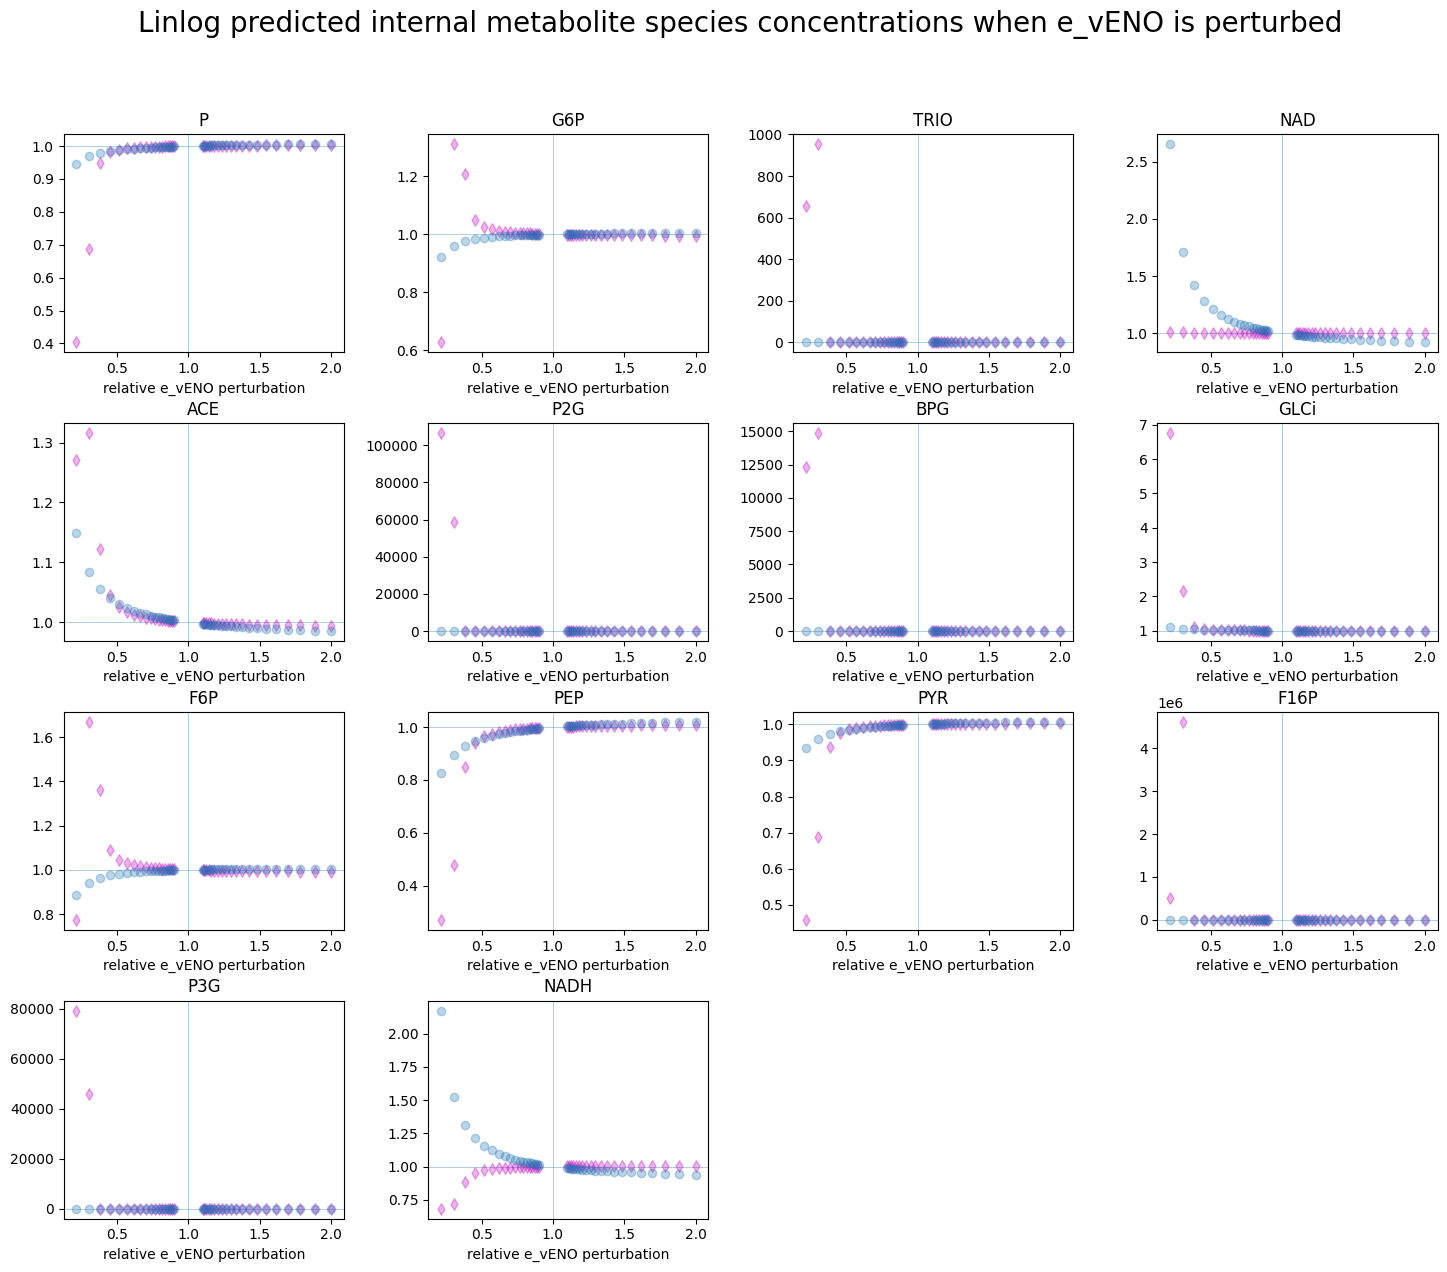

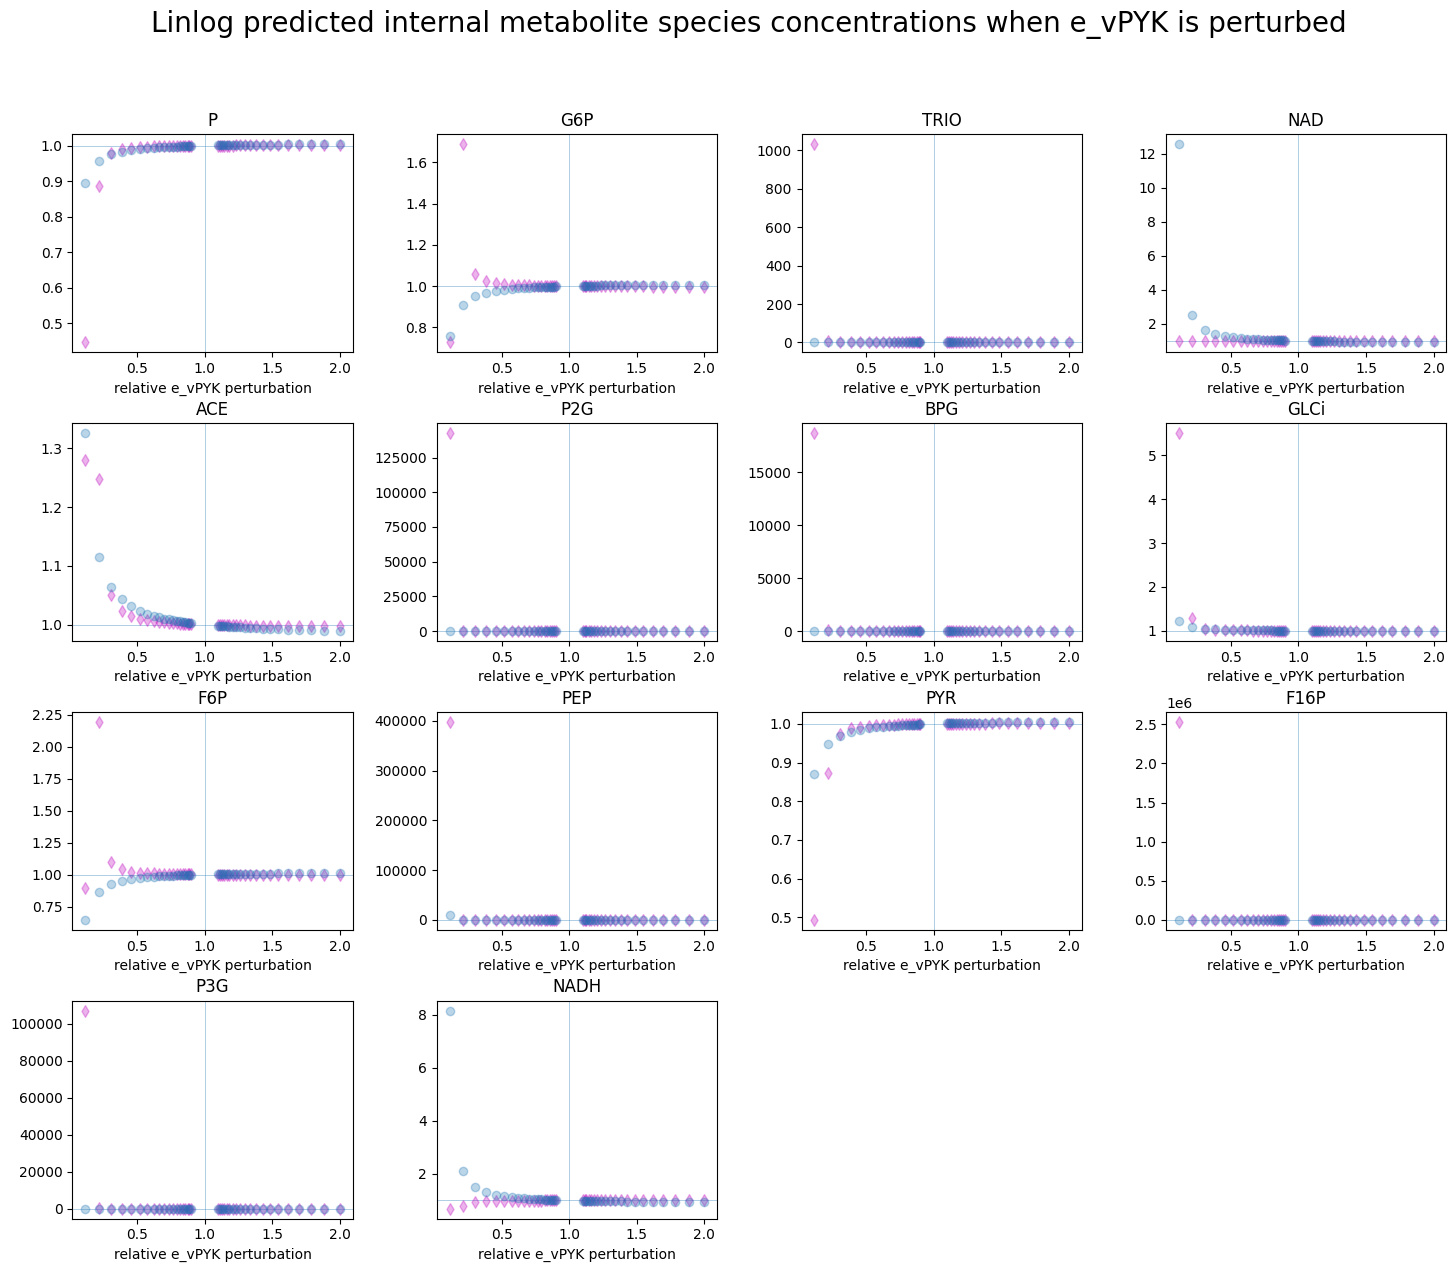

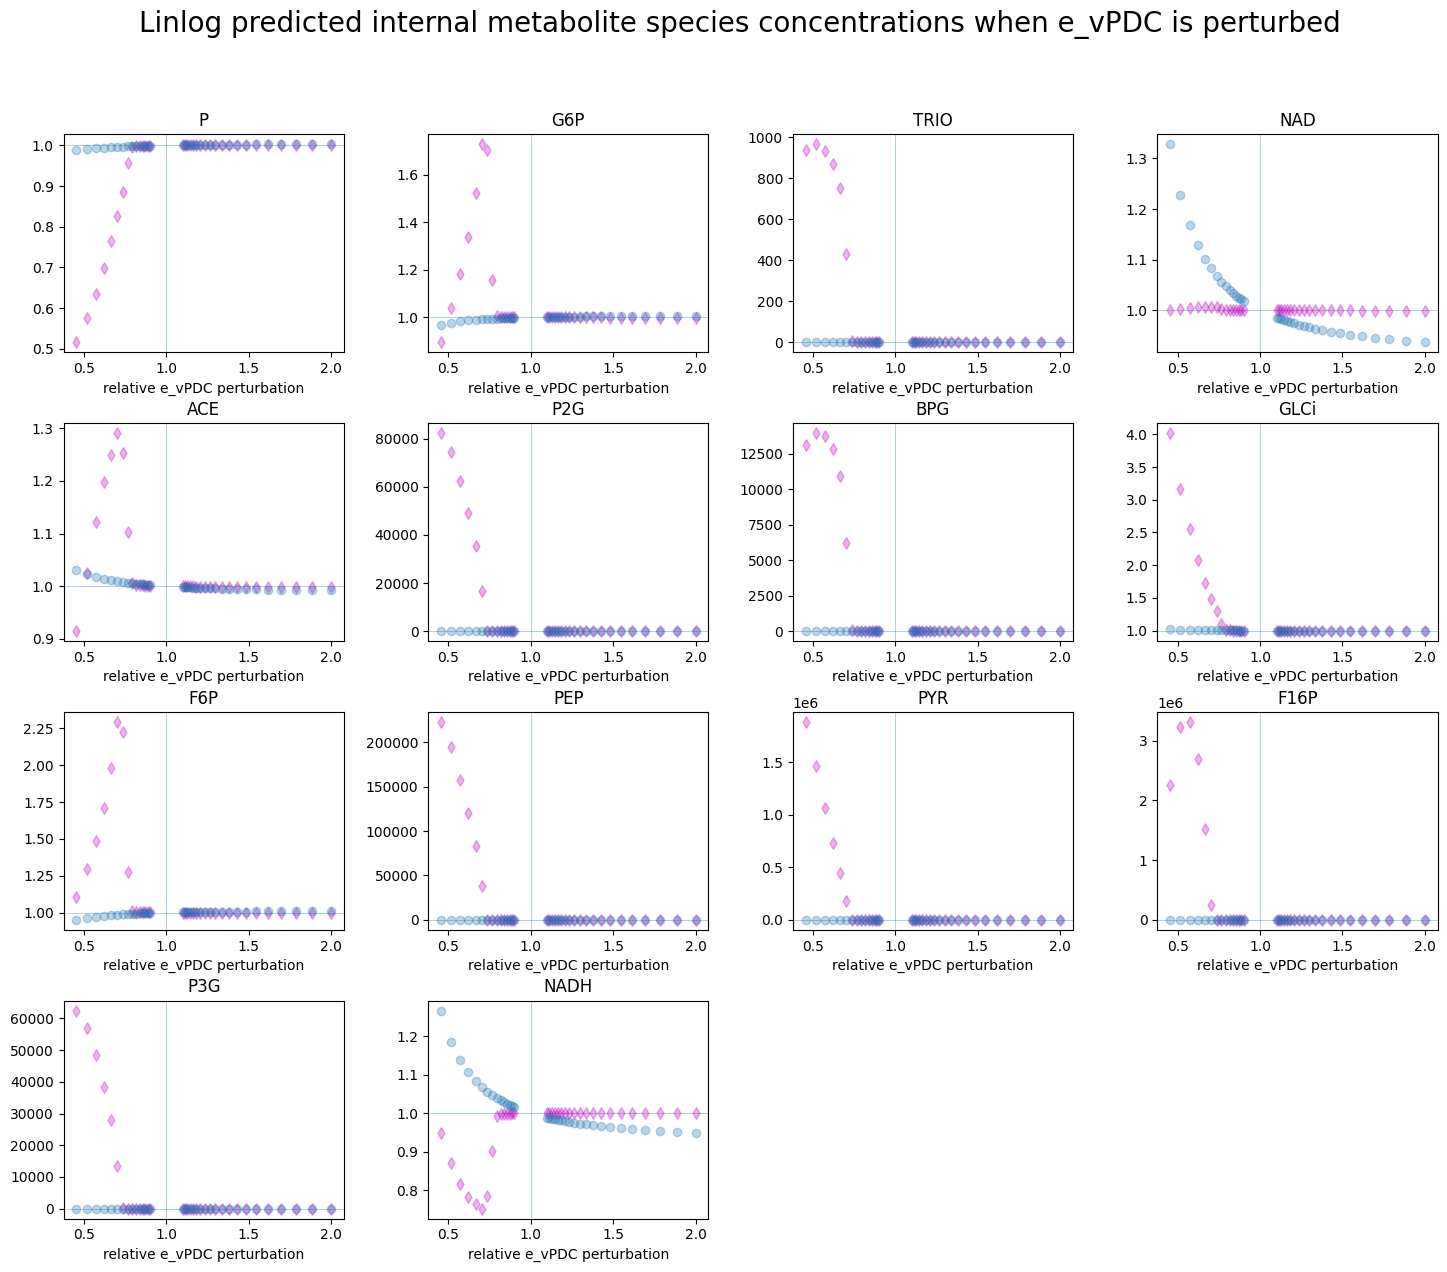

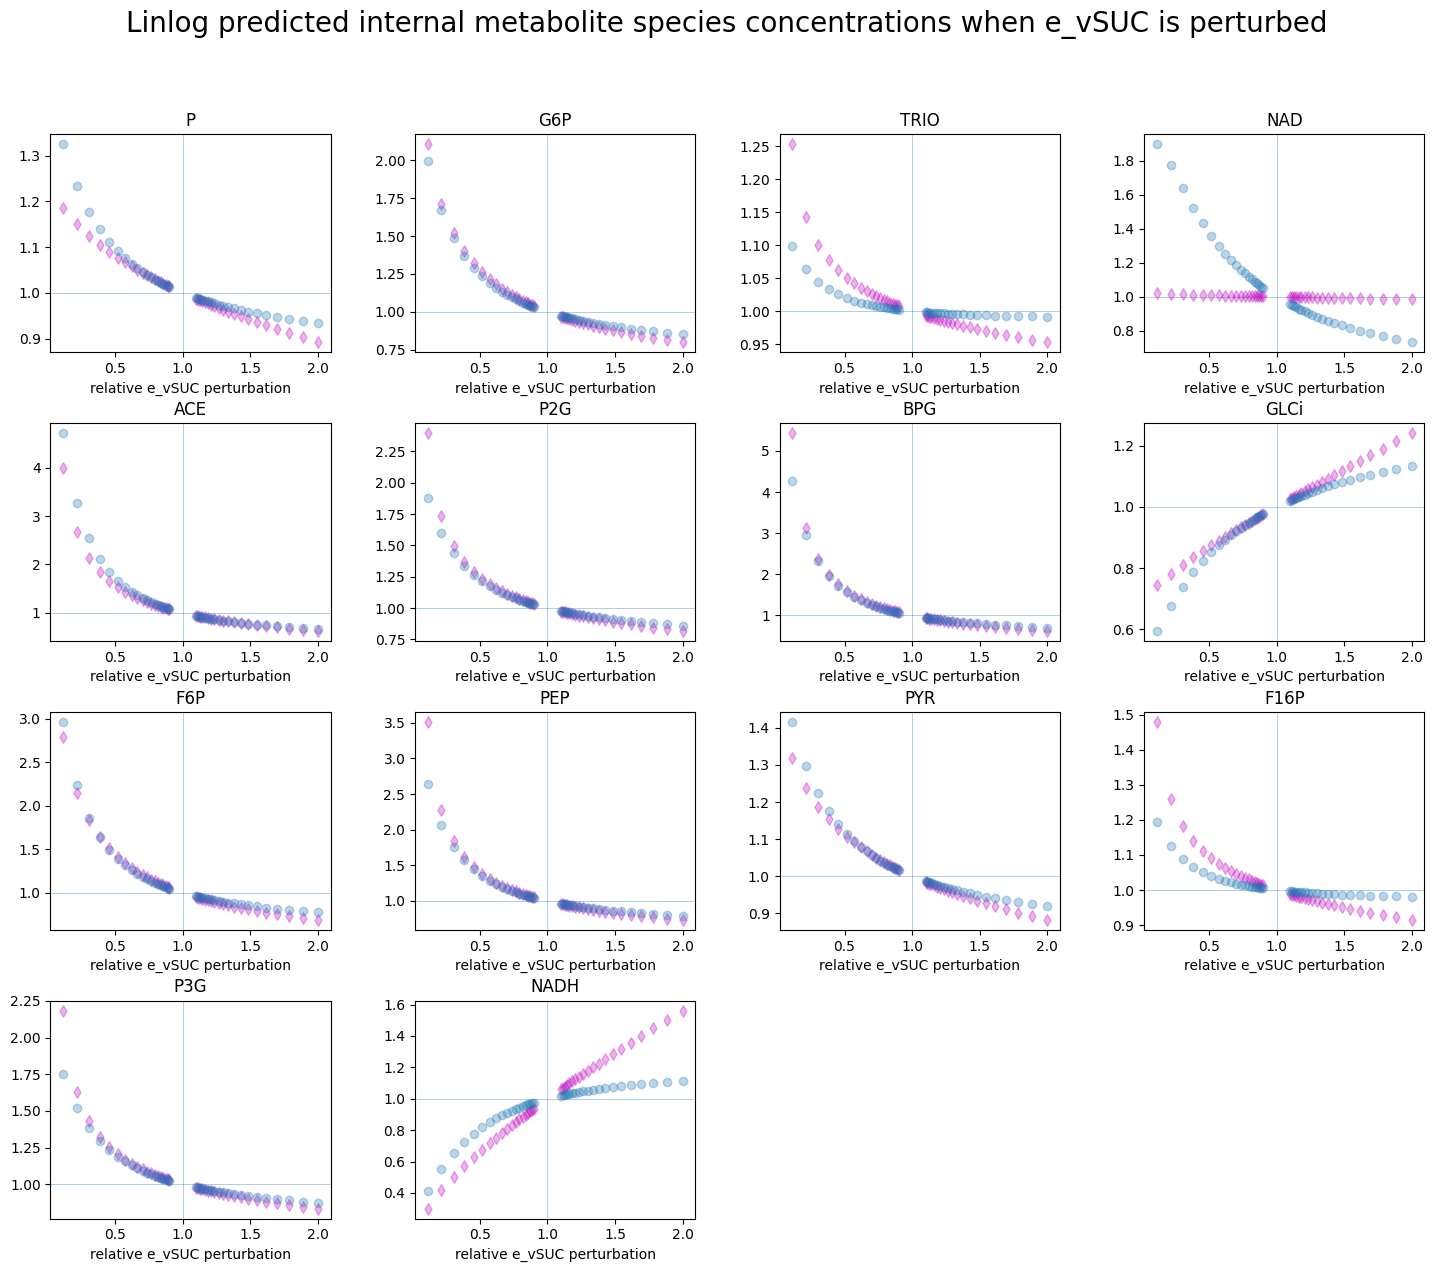

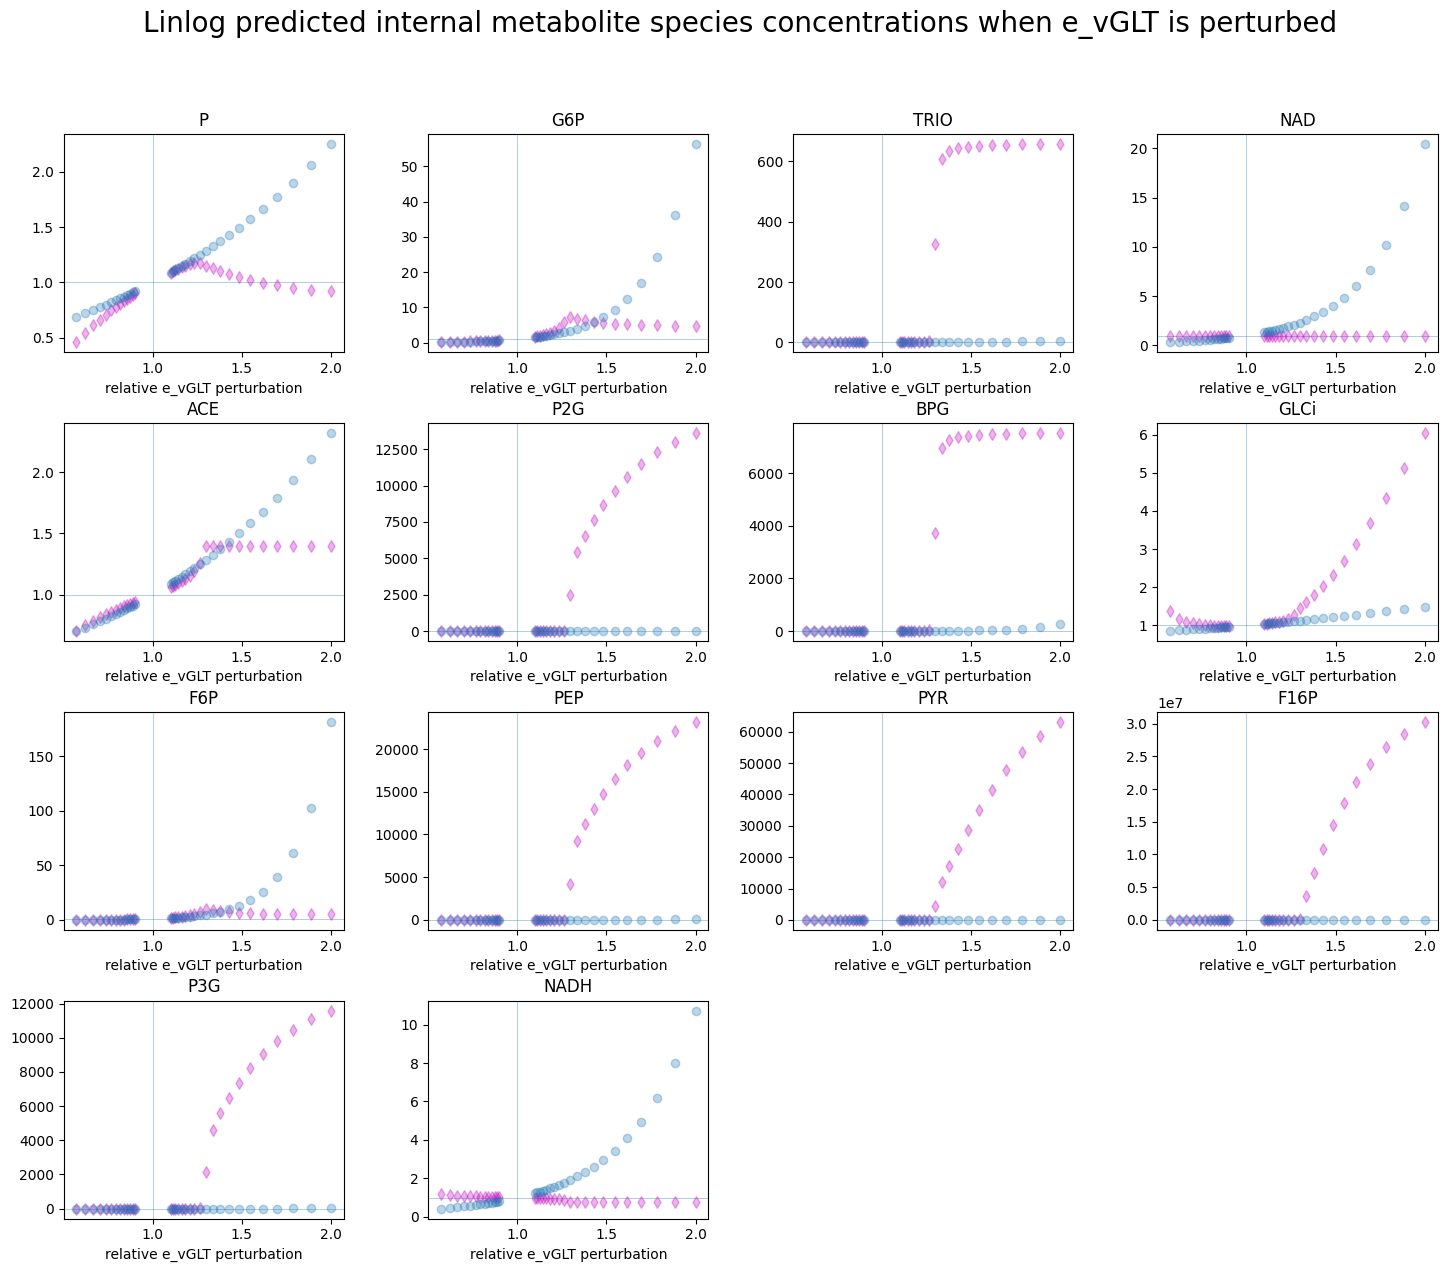

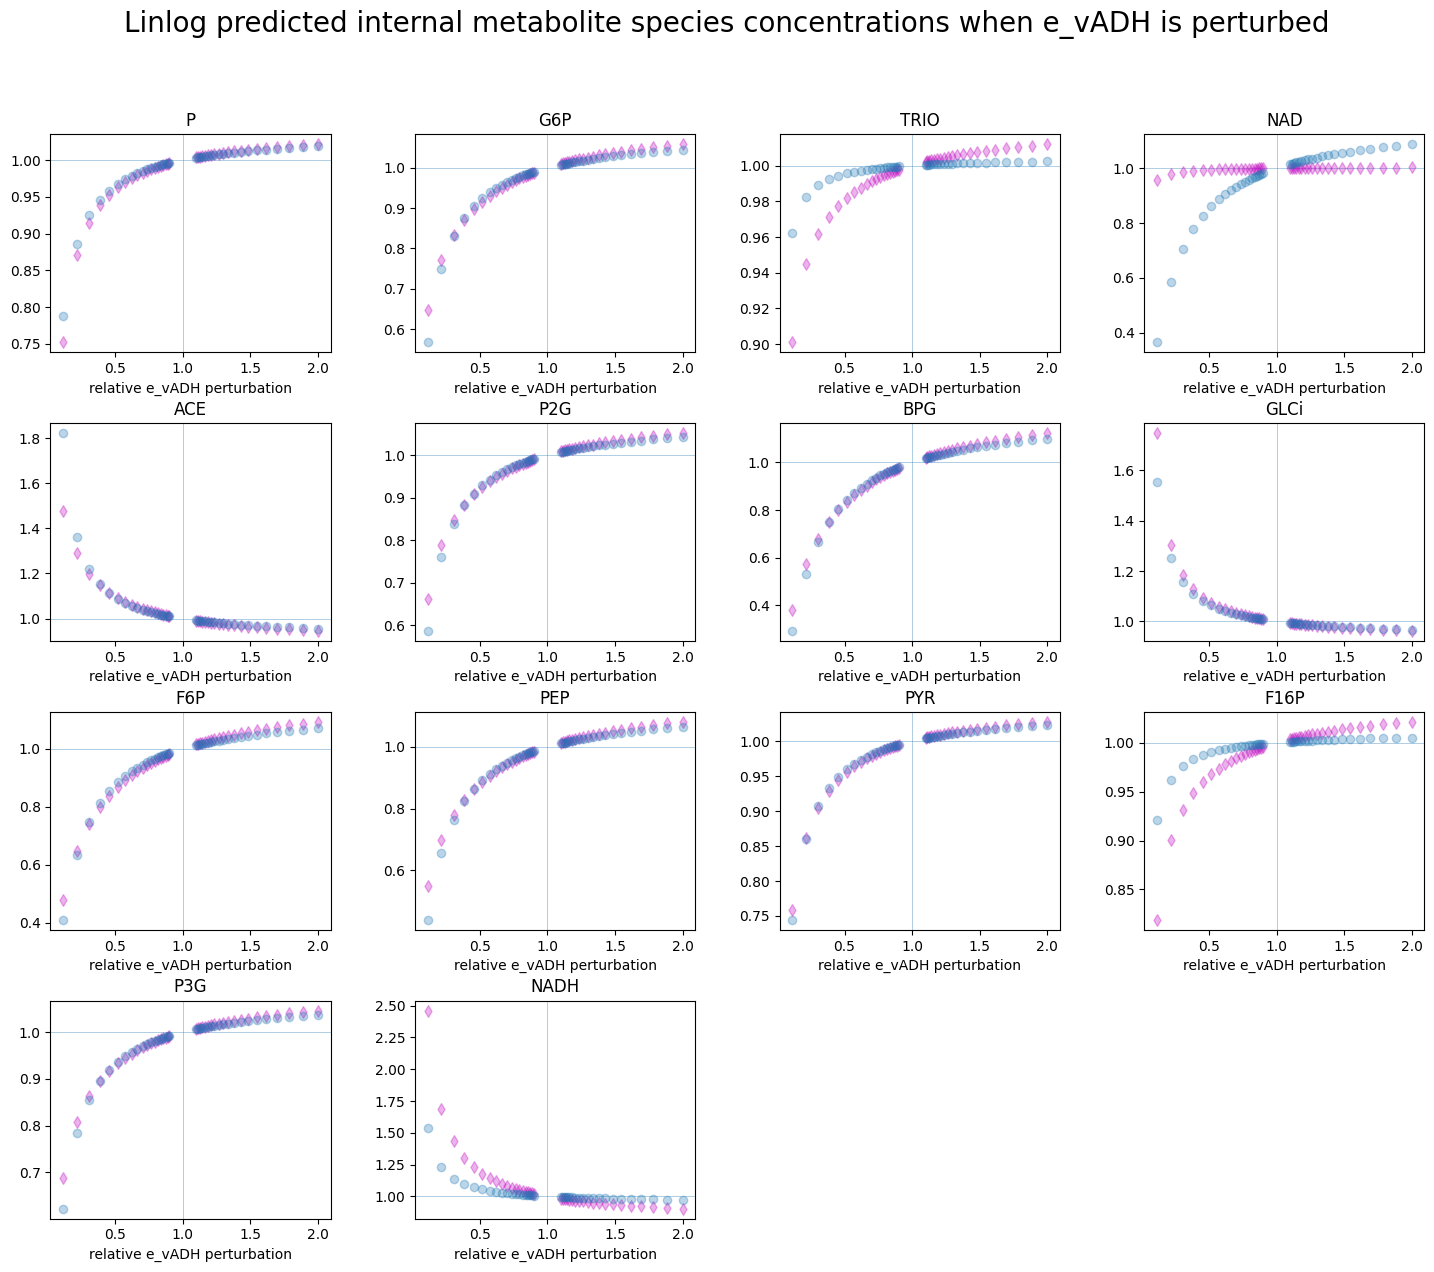

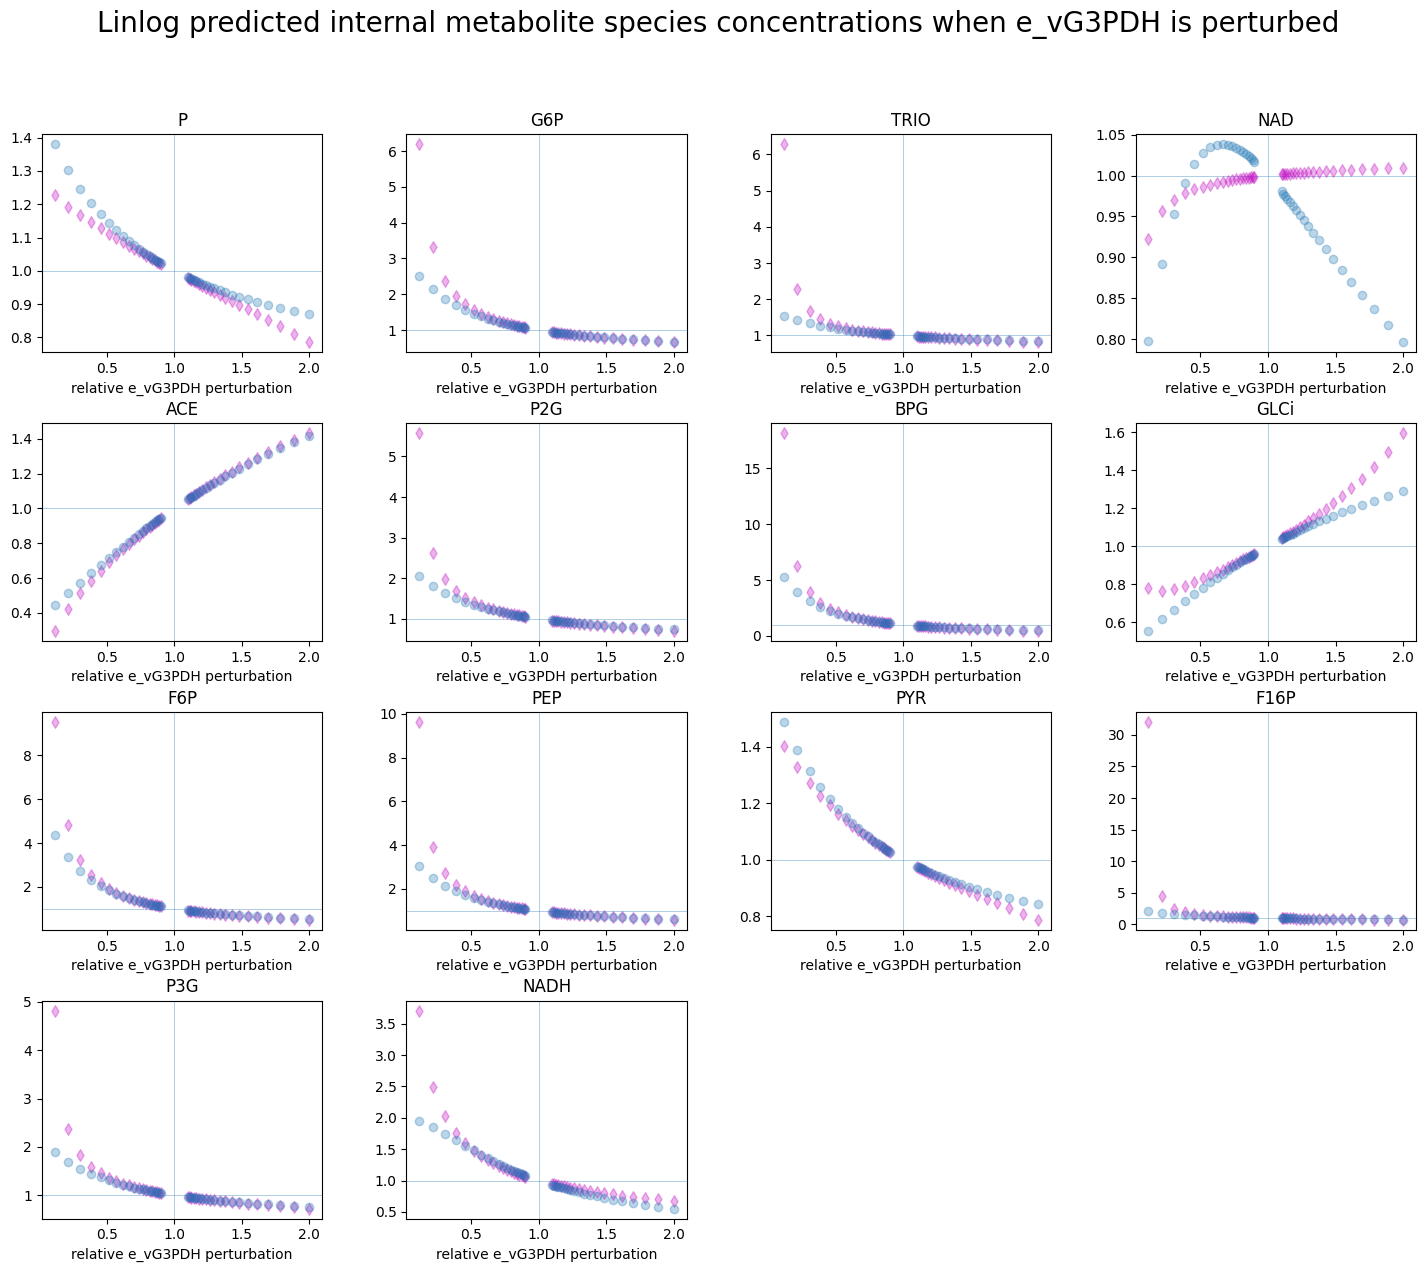

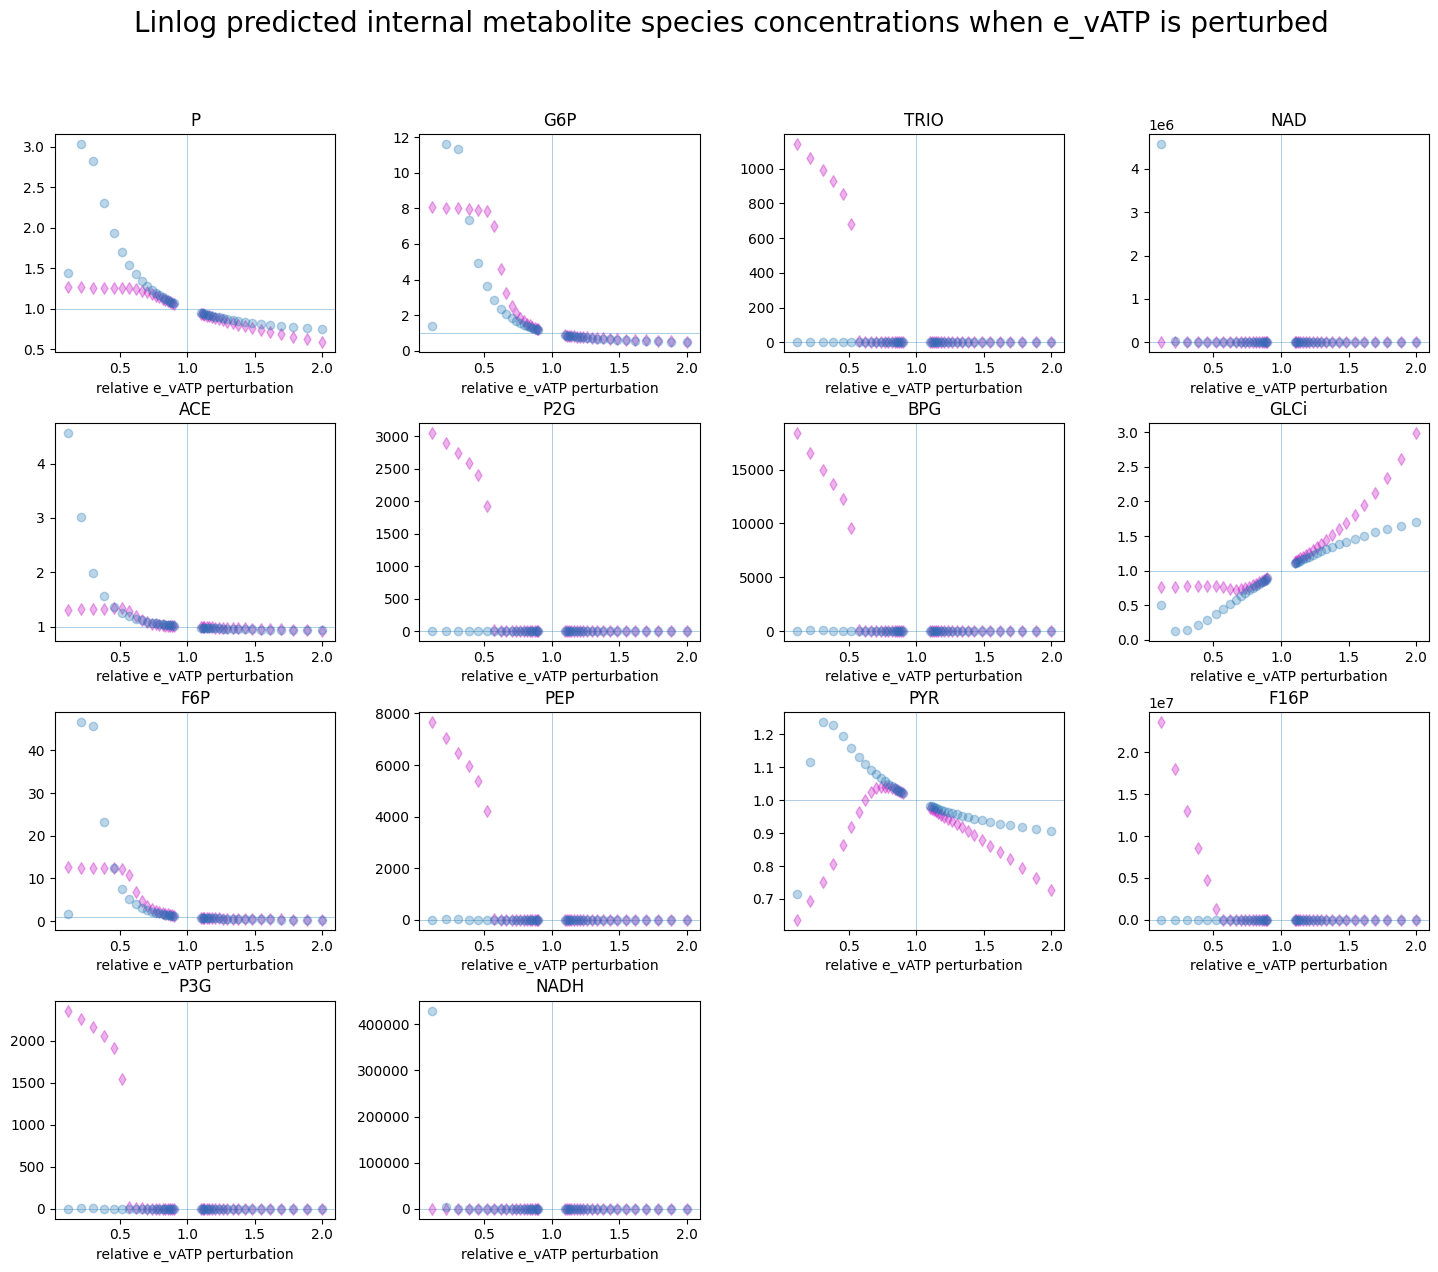

In [15]:
est_Xss = pd.DataFrame(np.exp(np.squeeze(np.array(Xss)).T), index=r.getFloatingSpeciesIds(), columns=enzPtLvls)
for rxn in r.getReactionIds(): 
    est_rxn_Xss = est_Xss[[i for i in est_Xss.columns if rxn in i]]
    est_rxn_Xss.columns = [float(i.split('|')[1]) for i in est_rxn_Xss.columns]
    est_rxn_Xss = est_rxn_Xss.reindex(sorted(est_rxn_Xss.columns), axis=1)
   
    rxn_inmet_perts = rel_real_inmet_values[[i for i in rel_real_inmet_values.columns if rxn in i]] 
    rxn_inmet_perts.columns=[i[7:] for i in rxn_inmet_perts.columns]
    rxn_inmet_perts = rxn_inmet_perts.reindex(sorted(rxn_inmet_perts.columns), axis=1)
    
    fig, axs = plt.subplots(4,4, figsize=(15, 13)) 
    idx_starter = -1

    fig.suptitle(f'Linlog predicted internal metabolite species concentrations when e_{rxn} is perturbed\n', fontsize = 20)
    fig.tight_layout(pad=3.0)

    for i,met in enumerate(r.getFloatingSpeciesIds()):
        if i%4==0:
            idx_starter += 1

        axs[idx_starter, i%4].scatter(est_rxn_Xss.columns, rxn_inmet_perts.loc[met].values, alpha=0.3, c='m', marker='d')
        axs[idx_starter, i%4].scatter(est_rxn_Xss.columns, est_rxn_Xss.loc[met], alpha=0.3)
        axs[idx_starter, i%4].set_xlabel(f'relative e_{rxn} perturbation')
        axs[idx_starter, i%4].axhline(1, linewidth=0.5, zorder=0, alpha=0.5)
        axs[idx_starter, i%4].axvline(x=1, linewidth=0.5, zorder=0, alpha=0.5)
        axs[idx_starter, i%4].set_title(met)
    
    fig.delaxes(axs[3,2]) 
    fig.delaxes(axs[3,3]) 


In [26]:
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BIOMD64.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BIOMD64.Ey.to_numpy(), name='Ey'))

    trace_prior = pm.sample_prior_predictive(samples=1000)

Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]


In [27]:
with pymc_model:
    
    e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BIOMD64.en.T)
    chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BIOMD64.xn.T)
    y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BIOMD64.yn.T)


In [ ]:
def steady_state_aesara(Ex, Ey, en=None, yn=None, method='scan'):
    n_exp = en.shape[0]

    en = at.as_tensor_variable(en)
    yn = at.as_tensor_variable(yn)

    e_diag = en.dimshuffle(0, 1, 'x') * np.diag(BIOMD64.v_star)
    N_rep = N.reshape((-1, *N.shape)).repeat(n_exp, axis=0)
    N_hat = at.batched_dot(N_rep, e_diag)

    inner_v = Ey.dot(yn.T).T + np.ones((len(N.T),n_exp), dtype=floatX)
    As = at.dot(N_hat, Ex)

    bs = at.batched_dot(-N_hat, inner_v.dimshuffle(0, 1, 'x'))
    
    def solve_aesara(self, A, b):
        rsolve_op = LeastSquaresSolve(driver=self.driver)
        return rsolve_op(A, b).squeeze()
    
    xn, _ = aesara.scan(
    lambda A, b: solve_aesara(A, b),
    sequences=[As, bs], strict=True)

    return xn

In [ ]:
with pymc_model:
    
    likelihood = pm.Deterministic('vn', e_obs * (np.ones((17,641)) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
    v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BIOMD64.vn.squeeze().T)

pymc_model.free_RVs

In [ ]:
N_ITERATIONS = 50000
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = advi.fit(
        n=       N_ITERATIONS, 
        callbacks = [tracker],
        obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
        total_grad_norm_constraint=0.7,
        obj_n_mc=1)
    
    trace_vi = approx.sample(draws=1000, random_seed=1) 
    ppc_vi = pm.sample_posterior_predictive(trace_vi, random_seed=1)
    

## Solving for steady state external metabolite concentrations (Y)

In [17]:
A = (N_rep@c@Ey) # (642, 14, 14)
arr = ((np.ones((len(N.T),n_exp)) + (Ex @ np.log(xn.T)))).values
arr = arr.T[:,:, np.newaxis]
b = -(N_rep@c) @ arr # (642, 14, 642)

Yss = []
for i in range(n_exp): 
    Yss.append(np.linalg.pinv(A[i])@b[i])

ValueError: shapes (17, 14) and (5, 642) not aligned

In [16]:
est_Yss = pd.DataFrame(np.exp(np.squeeze(np.array(Yss)).T), index=r.getFloatingSpeciesIds(), columns=enzPtLvls)
for rxn in r.getReactionIds(): 
    est_rxn_Yss = est_Yss[[i for i in est_Yss.columns if rxn in i]]
    est_rxn_Yss.columns = [float(i.split('|')[1]) for i in est_rxn_Yss.columns]
    est_rxn_Yss = est_rxn_Yss.reindex(sorted(est_rxn_Yss.columns), axis=1)
    
    rxn_exmet_perts = rel_real_exmet_values[[i for i in rel_real_exmet_values.columns if rxn in i]] 
    rxn_exmet_perts.columns=[i[7:] for i in rxn_exmet_perts.columns]
    rxn_exmet_perts = rxn_exmet_perts.reindex(sorted(rxn_exmet_perts.columns), axis=1)
    
    fig, axs = plt.subplots(2,3, figsize=(15, 13)) 
    idx_starter = -1

    fig.suptitle(f'Linlog predicted external metabolite species concentrations when e_{rxn} is perturbed\n', fontsize = 20)
    fig.tight_layout(pad=3.0)

    for i,met in enumerate(r.getBoundarySpeciesIds()):
        if i%3==0:
            idx_starter += 1

        axs[idx_starter, i%3].scatter(est_rxn_Yss.columns, rxn_exmet_perts.loc[met].values, alpha=0.3, c='m', marker='d')
        axs[idx_starter, i%3].scatter(est_rxn_Yss.columns, est_rxn_Yss.loc[met], alpha=0.3)
        axs[idx_starter, i%3].set_xlabel(f'relative e_{rxn} perturbation')
        axs[idx_starter, i%3].axhline(1, linewidth=0.5, zorder=0, alpha=0.5)
        axs[idx_starter, i%3].axvline(x=1, linewidth=0.5, zorder=0, alpha=0.5)
        axs[idx_starter, i%3].set_title(met)
    
    fig.delaxes(axs[1,2]) 


NameError: name 'Yss' is not defined

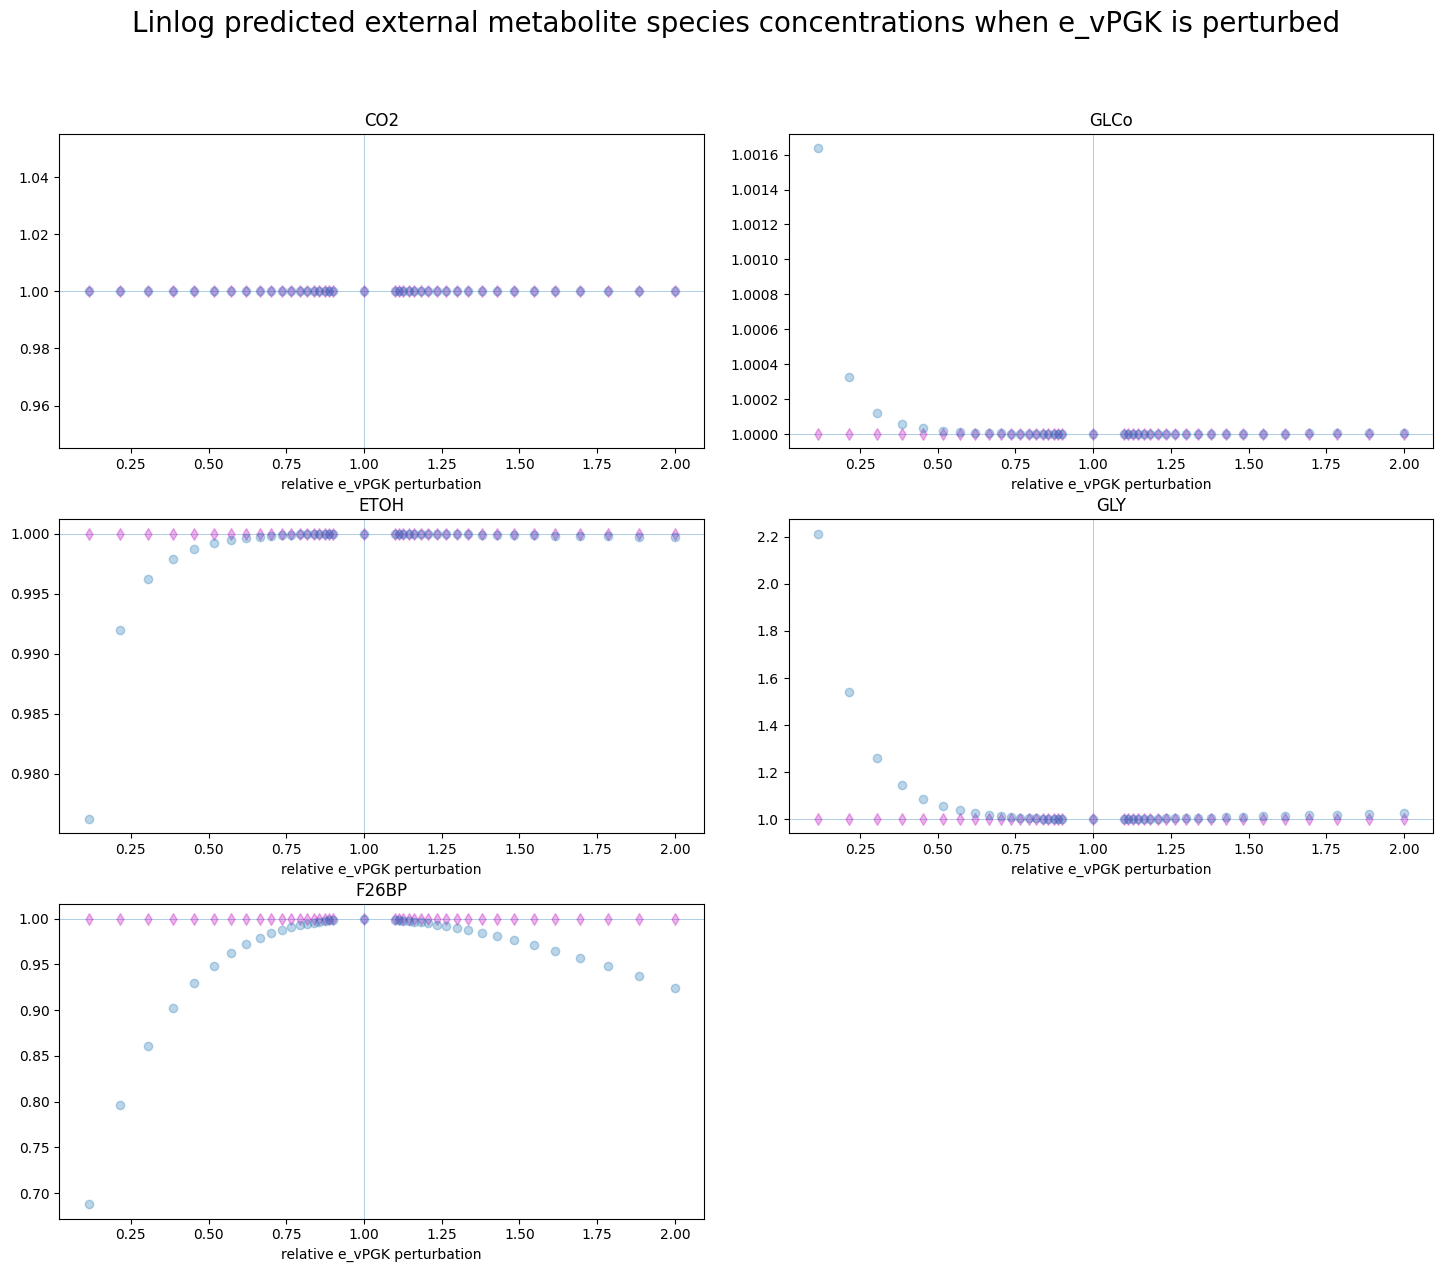

In [68]:
# establish the names of each boundary specie
Yss.index = r.getBoundarySpeciesIds()
# plot for each metabolite 
# create a subplot that is (3,2)
fig, axs = plt.subplots(3,2, figsize=(15, 13)) 
idx_starter = -1

fig.suptitle('Linlog predicted external metabolite species concentrations when e_vPGK is perturbed\n', fontsize = 20)
fig.tight_layout(pad=3.0)

for i,met in enumerate(r.getBoundarySpeciesIds()):
    if i%2==0:
        idx_starter += 1

    axs[idx_starter, i%2].scatter(Yss.columns, PGK_exmet_perts.loc[met], alpha=0.3, c='m', marker='d')
    axs[idx_starter, i%2].scatter(Yss.columns, Yss.loc[met], alpha=0.3)
    axs[idx_starter, i%2].set_xlabel('relative e_vPGK perturbation')
    axs[idx_starter, i%2].set_title(met)
  
    axs[idx_starter, i%2].axhline(1, linewidth=0.5, zorder=0, alpha=0.5)
    axs[idx_starter, i%2].axvline(x=1, linewidth=0.5, zorder=0, alpha=0.5)

fig.delaxes(axs[2,1]) 
